## Predicting the onset of Alzheimer's disease using machine learning 
### Authors

Vipul Satone$^{1}$, Rachneet Kaur$^{1}$, Faraz Faghri$^{2, 3}$, Roy H. Campbell$^{3}$

1 - Department of Industrial and Enterprise Systems Engineering, University of Illinois Urbana-Champaign, IL, 61820, USA

2 - Laboratory of Neurogenetics, National Institute on Aging, National Institutes of Health, MD, 20892, USA

3 - Department of Computer Science, University of Illinois Urbana-Champaign, IL, 61820, USA

### Abstract

Alzheimer’s disease is a degenerative brain disease which impairs person’s ability perform day to day activities. Research has shown AD to be a heterogeneous condition, having high variation in terms of the symptoms and disease progression rate. Treating Alzheimer's disease (AD) is especially challenging due to theses variations present in the disease progression stages.  The clinical symptoms of AD are identified by substantial diversity in terms of patients’ age, disease span, progression velocity and types of memory, cognitive and depression related features. Hence, the idea of personalized clinical care, with individualized risk, progression and prediction related patient advice in AD is narrow. This facilitates the yet unfulfilled need for an early prediction of the disease course to assist its treatment and therapy with the progression rate. 
Recent developments in machine learning techniques provide a huge potential not only to predict onset and progression of Alzheimer's disease but also to classify the disease into different subtypes. The advancement of these prediction models will thoroughly impact clinical test outline and improve the healthcare resource allocation. It will also lead to development of a personalized clinical care and counseling for patients with a cut down on AD treatment costs. The suggested work clusters patients in distinct progression groups of Alzheimer's disease and discusses an approach to predict the progression stage in an early baseline period through the implementation of machine learning techniques. By applying machine learning algorithms on the extensive clinical observations available at the Alzheimer's Disease Neuroimaging Initiative (ADNI) dataset, we depict the progression space for the Alzheimer’s disease into low, moderate and high disease progressors. This work suggests that the clinically related symptoms summarizing the Alzheimer's Disease progression space correspond to memory and cognition. The proposed work concludes notably accurate prediction of disease progression after four years from the 12 months of  diagnosis data ( AUC under ROC of 0.90 ± 0.04 for Controls, 0.96 ± 0.03 for High risk, 0.88 ± 0.03 for Moderate Risk 0.84 ± 0.03 for Low risk ). We validate our model through five-fold cross-validation to obtain robust prediction of the progression subtypes. These machine learning techniques will assist the medical practitioners to classify different progression 	rates within patients and might also lead to an improvement in the detection of significant clinical outcomes that otherwise may be harder to notice. With an additional  information about the onset rate of AD at hand, doctors may alter their treatments to better suit the patients. The predictive tests discussed in the proposed work allow early detection and characterization of distinct disease subtypes based on clinical heterogeneity, which helps doctors subduing AD effects with a better stage information. This will lead to an improved clinical test outline and personalized clinical care for patients, with a significant downscaling of the treatment costs.


In [ ]:

#Importing libraries 
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics 
import pandas as pd
from sklearn import decomposition
from sklearn.decomposition import PCA as sklearnPCA
from sklearn import decomposition
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
import imageio
import warnings
warnings.filterwarnings("ignore")
sns.set()

%matplotlib inline

In [2]:
#Keeping the directory correct
import os
os.chdir('C:\\Users\\Vipul Satone\\health data') # default directory
address = 'C:\\Users\\Vipul Satone\\health data\\ADNI\\final_code\\commented code\\github results\\github_drive\\github\\niips\\figures\\' # directory where images are to be stored
# Inside this folder (m24_m12) have a folder gif. Inside this folder have three different folders named ica, pca, nmf.


In [3]:
# assessment data
cols = {}
list_months_to_be_considered = ['bl','m06','m12']


In [4]:

# Following function gives information about dataset to be imputed.
def data_info(dataset):
    print('Name of dataset is: ' + dataset.name) 
    print('\n0th level of columns is ')
    print(list(pd.Series(dataset.columns.get_level_values(0)).unique()) )
    print('\n1st level of columns is: ')
    print(list(pd.Series(dataset.columns.get_level_values(1)).unique()) )
    print('\nShape of datset is:')
    print(dataset.shape)
    print('\nTotal number of missing values: ')
    print(dataset.isnull().sum().sum())

In [5]:

# Argument Train1 is dta to be normalized. IF argument b is 'z' the z normalization is done otherwise minmax normalization is done.
def normalize(Train1,b):
    col_names = list(Train1.columns)
    if (b == 'z'):
        for i in range(Train1.shape[1]):
            Train1[col_names[i]] = (Train1[col_names[i]] - Train1[col_names[i]].mean(skipna = True)) / Train1[col_names[i]].std(skipna = True)
    else:
        for i in range(Train1.shape[1]):
            Train1[col_names[i]] = (Train1[col_names[i]] - min(Train1[col_names[i]]) )/ ( max(Train1[col_names[i]] ) - min(Train1[col_names[i]]) )
    return Train1


In [115]:
#CDR
cols['cdr'] = ['RID','VISCODE2', 'CDMEMORY', 'CDORIENT', 'CDJUDGE' ,'CDCOMMUN' ,'CDHOME' ,'CDCARE']
cdr = pd.read_csv("ADNI\\Raw_Data\\Assessment\\CDR.csv",index_col='RID', usecols=cols['cdr'])
cdr1 = cdr.copy(deep = True)
print(cdr1.shape)
cdr = cdr[cdr['VISCODE2'].isin(['bl','m12','m06']) ]  
cdr = cdr.reset_index().set_index(['RID','VISCODE2'])
cdr = cdr[~cdr.index.duplicated()].unstack()
cdr = cdr[ (cdr.isnull().sum(axis = 1) <= 4) ]
cdr = cdr.T
cdr = cdr[cdr.index.get_level_values(1).isin(list_months_to_be_considered)].T
# reducing index level
cdr_ruf = cdr.T.reset_index()
cdr_ruf.iloc[:,0]  = 'cdr__' + cdr_ruf.iloc[:,0] +  '___' + cdr_ruf.iloc[:,1]
cdr_ruf = cdr_ruf.set_index('level_0')
cdr = cdr_ruf.iloc[:,1:].T
cdr_no_encoding = cdr

cdr.name = 'Clinical Dementia Rating'

(10414, 7)


In [7]:
#NEUROBAT - Just using the total scores CLCOKSCOR, COPYSCOR, BNTTOTAL
cols['neurobat'] = ['RID', 'VISCODE2', 'CLOCKSCOR', 'COPYSCOR', 'LMSTORY', 'LIMMTOTAL', 'LIMMEND',
       'AVTOT1', 'AVERR1', 'AVTOT2', 'AVERR2', 'AVTOT3', 'AVERR3', 'AVTOT4',
       'AVERR4', 'AVTOT5', 'AVERR5', 'AVTOT6', 'AVERR6', 'AVTOTB', 'AVERRB',
       'AVENDED', 'DSPANFOR', 'DSPANFLTH', 'DSPANBAC', 'DSPANBLTH',
       'CATANIMSC', 'CATANPERS', 'CATANINTR', 'CATVEGESC', 'CATVGPERS',
       'CATVGINTR', 'TRAASCOR', 'TRAAERRCOM', 'TRAAERROM', 'TRABSCOR',
       'TRABERRCOM', 'TRABERROM', 'DIGITSCOR', 'LDELBEGIN', 'LDELTOTAL',
       'LDELCUE','BNTTOTAL', 'AVDELBEGAN', 'AVDEL30MIN', 'AVDELERR1',
       'AVDELTOT', 'AVDELERR2', 'ANARTND', 'ANARTERR']
neurobat_1 = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat'], index_col = ['RID', 'VISCODE2'])
print(neurobat_1.shape)
cols['neurobat_clock'] = ['RID', 'VISCODE2', 'CLOCKSCOR']
neurobat_clock = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_clock'], index_col = ['RID', 'VISCODE2'])
neurobat_clock1 = neurobat_clock.copy(deep = True) 
neurobat_clock = neurobat_clock[~neurobat_clock.index.duplicated()].reset_index()
neurobat_clock = neurobat_clock[neurobat_clock.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_clock = neurobat_clock.unstack()
neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
new_col_list_neurobat_clock = neurobat_clock.columns.levels[0]
for a in new_col_list_neurobat_clock: 
    neurobat_clock[a] = neurobat_clock[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_clock.name = 'Neuropsychological Battery (subdata - clock)'
#data_info(neurobat_clock)

cols['neurobat_copy'] = ['RID', 'VISCODE2', 'COPYSCOR']
neurobat_copy = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_copy'], index_col = ['RID', 'VISCODE2'])
neurobat_copy1 = neurobat_copy.copy(deep = True) 
neurobat_copy = neurobat_copy[~neurobat_copy.index.duplicated()].reset_index()
neurobat_copy = neurobat_copy[neurobat_copy.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_copy = neurobat_copy.unstack()
neurobat_copy = neurobat_copy[ (neurobat_copy.isnull().sum(axis = 1) <= 1) ]
new_col_list_neurobat_copy = neurobat_copy.columns.levels[0]
for a in new_col_list_neurobat_copy: 
    neurobat_copy[a] = neurobat_copy[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_copy.name = 'Neuropsychological Battery (subdata - copy)'
#data_info(neurobat_copy)

cols['neurobat_limm_story'] = ['RID', 'VISCODE2', 'LIMMTOTAL']
neurobat_limm_story = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_limm_story'], index_col = ['RID', 'VISCODE2'])
neurobat_limm_story1 = neurobat_limm_story.copy(deep = True) 
neurobat_limm_story = neurobat_limm_story[~neurobat_limm_story.index.duplicated()].reset_index()
neurobat_limm_story = neurobat_limm_story[neurobat_limm_story.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_limm_story = neurobat_limm_story.unstack()
neurobat_limm_story = neurobat_limm_story.drop(['m06','bl'], axis=1, level=1)
#neurobat_limm_story = neurobat_limm_story.T[ (neurobat_limm_story.columns.levels[1]) == 'm12' ].T
neurobat_limm_story = neurobat_limm_story[ (neurobat_limm_story.isnull().sum(axis = 1) < 1) ]
neurobat_limm_story.name = 'Neuropsychological Battery (subdata - story)'
#data_info(neurobat_limm_story)

cols['neurobat_dspan'] = ['RID', 'VISCODE2','DSPANFOR', 'DSPANFLTH', 'DSPANBAC', 'DSPANBLTH']
neurobat_dspan = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_dspan'], index_col = ['RID', 'VISCODE2'])
neurobat_dspan1 = neurobat_dspan.copy(deep = True) 
neurobat_dspan = neurobat_dspan[~neurobat_dspan.index.duplicated()].reset_index()
neurobat_dspan = neurobat_dspan[neurobat_dspan.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_dspan = neurobat_dspan[ (neurobat_dspan.isnull().sum(axis = 1) < 4) ]
neurobat_dspan = neurobat_dspan.unstack()
neurobat_dspan = neurobat_dspan[ (neurobat_dspan.isnull().sum(axis = 1) <6) ]
new_col_list_neurobat_dspan = neurobat_dspan.columns.levels[0]
for a in new_col_list_neurobat_dspan: 
    neurobat_dspan[a] = neurobat_dspan[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_dspan.name = 'Neuropsychological Battery (subdata - digit span)'
#data_info(neurobat_dspan)

cols['neurobat_cat_flu'] = ['RID', 'VISCODE2','CATANIMSC', 'CATANPERS', 'CATANINTR', 'CATVEGESC', 'CATVGPERS','CATVGINTR']
neurobat_cat_flu = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_cat_flu'], index_col = ['RID', 'VISCODE2'])
neurobat_cat_flu1 = neurobat_cat_flu.copy(deep = True) 
neurobat_cat_flu = neurobat_cat_flu[~neurobat_cat_flu.index.duplicated()].reset_index()
neurobat_cat_flu = neurobat_cat_flu[neurobat_cat_flu.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_cat_flu = neurobat_cat_flu.replace({-1: np.NAN})
neurobat_cat_flu = neurobat_cat_flu[ (neurobat_cat_flu.isnull().sum(axis = 1) < 4) ]
del neurobat_cat_flu['CATVEGESC']
del neurobat_cat_flu['CATVGPERS']
del neurobat_cat_flu['CATVGINTR']
neurobat_cat_flu = neurobat_cat_flu.unstack()
neurobat_cat_flu = neurobat_cat_flu[ (neurobat_cat_flu.isnull().sum(axis = 1) <4) ]
new_col_list_neurobat_cat_flu = neurobat_cat_flu.columns.levels[0]
for a in new_col_list_neurobat_cat_flu: 
    neurobat_cat_flu[a] = neurobat_cat_flu[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_cat_flu.name = 'Neuropsychological Battery (subdata - category fluency : only animal examples)'
#data_info(neurobat_cat_flu)

cols['neurobat_trail'] = ['RID', 'VISCODE2', 'TRAASCOR', 'TRAAERRCOM', 'TRAAERROM', 'TRABSCOR','TRABERRCOM', 'TRABERROM']
neurobat_trail = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_trail'], index_col = ['RID', 'VISCODE2'])
neurobat_trail1 = neurobat_trail.copy(deep = True) 
neurobat_trail = neurobat_trail[~neurobat_trail.index.duplicated()].reset_index()
neurobat_trail = neurobat_trail[neurobat_trail.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_trail = neurobat_trail[ (neurobat_trail.isnull().sum(axis = 1) < 3) ]
neurobat_trail = neurobat_trail.unstack()
neurobat_trail = neurobat_trail[ (neurobat_trail.isnull().sum(axis = 1) <=6) ]
new_col_list_neurobat_trail = neurobat_trail.columns.levels[0]
for a in new_col_list_neurobat_trail: 
    neurobat_trail[a] = neurobat_trail[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_trail.name = 'Neuropsychological Battery (subdata - Trail making)'
#data_info(neurobat_trail)

cols['neurobat_av'] = ['RID', 'VISCODE2','AVTOT1', 'AVDELERR1','AVDELTOT', 'AVERR1', 'AVTOT2', 'AVERR2', 'AVTOT3',     'AVERR3','AVDELERR2', 'AVTOT4','AVERR4', 'AVTOT5', 'AVERR5', 'AVTOT6', 'AVERR6', 'AVTOTB', 'AVERRB','AVDEL30MIN']
neurobat_av = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_av'], index_col = ['RID', 'VISCODE2'])
neurobat_av1 = neurobat_av.copy(deep = True) 
neurobat_av = neurobat_av[~neurobat_av.index.duplicated()].reset_index()
neurobat_av = neurobat_av[neurobat_av.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_av = neurobat_av.unstack()
neurobat_av = neurobat_av[ (neurobat_av.isnull().sum(axis = 1) <25) ]
new_col_list_neurobat_av = neurobat_av.columns.levels[0]
for a in new_col_list_neurobat_av: 
    neurobat_av[a] = neurobat_av[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_av.name = 'Neuropsychological Battery (subdata - av)'
#data_info(neurobat_av)

cols['neurobat_digit_score'] = ['RID', 'VISCODE2','DIGITSCOR']
neurobat_digit_score = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_digit_score'], index_col = ['RID', 'VISCODE2'])
neurobat_digit_score1 = neurobat_digit_score.copy(deep = True) 
neurobat_digit_score = neurobat_digit_score[~neurobat_digit_score.index.duplicated()].reset_index()
neurobat_digit_score = neurobat_digit_score[neurobat_digit_score.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_digit_score = neurobat_digit_score[ (neurobat_digit_score.isnull().sum(axis = 1) < 1) ]
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_digit_score = neurobat_digit_score.unstack()
neurobat_digit_score = neurobat_digit_score[ (neurobat_digit_score.isnull().sum(axis = 1) <=1) ]
new_col_list_neurobat_digit_score = neurobat_digit_score.columns.levels[0]
for a in new_col_list_neurobat_digit_score: 
    neurobat_digit_score[a] = neurobat_digit_score[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_digit_score.name = 'Neuropsychological Battery (subdata - digit score)'
#data_info(neurobat_digit_score)

cols['neurobat_logical_memory'] = ['RID', 'VISCODE2','LDELTOTAL']
neurobat_logical_memory = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_logical_memory'], index_col = ['RID', 'VISCODE2'])
neurobat_logical_memory1 = neurobat_logical_memory.copy(deep = True) 
neurobat_logical_memory = neurobat_logical_memory[~neurobat_logical_memory.index.duplicated()].reset_index()
neurobat_logical_memory = neurobat_logical_memory[neurobat_logical_memory.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_logical_memory = neurobat_logical_memory[ (neurobat_logical_memory.isnull().sum(axis = 1) < 1) ]
neurobat_logical_memory = neurobat_logical_memory.unstack()
neurobat_logical_memory.name = 'Neuropsychological Battery (subdata - logical memeory test)'
#data_info(neurobat_logical_memory)

cols['neurobat_boston_naming_test'] = ['RID', 'VISCODE2', 'BNTSPONT','BNTSTIM','BNTCSTIM','BNTPHON','BNTCPHON']
neurobat_boston_naming_test = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_boston_naming_test'], index_col = ['RID', 'VISCODE2'])
neurobat_boston_naming_test1 = neurobat_boston_naming_test.copy(deep = True) 
neurobat_boston_naming_test = neurobat_boston_naming_test[~neurobat_boston_naming_test.index.duplicated()].reset_index()
neurobat_boston_naming_test = neurobat_boston_naming_test[neurobat_boston_naming_test.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_boston_naming_test = neurobat_boston_naming_test[ (neurobat_boston_naming_test.isnull().sum(axis = 1) < 5) ]
neurobat_boston_naming_test = neurobat_boston_naming_test.unstack()
neurobat_boston_naming_test = neurobat_boston_naming_test[ (neurobat_boston_naming_test.isnull().sum(axis = 1) <6) ]
new_col_list_neurobat_boston_naming_test = neurobat_boston_naming_test.columns.levels[0]
for a in new_col_list_neurobat_boston_naming_test: 
    neurobat_boston_naming_test[a] = neurobat_boston_naming_test[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_boston_naming_test.name = 'Neuropsychological Battery (subdata - Boston naming test)'
#data_info(neurobat_boston_naming_test)

cols['neurobat_anrt'] = ['RID', 'VISCODE2', 'ANARTND']
neurobat_anrt = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_anrt'], index_col = ['RID', 'VISCODE2'])
neurobat_anrt1 = neurobat_anrt.copy(deep = True) 
neurobat_anrt = neurobat_anrt[~neurobat_anrt.index.duplicated()].reset_index()
neurobat_anrt = neurobat_anrt[neurobat_anrt.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_anrt = neurobat_anrt[ (neurobat_anrt.isnull().sum(axis = 1) < 1) ]
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_anrt = neurobat_anrt.unstack()
neurobat_anrt = neurobat_anrt[ (neurobat_anrt.isnull().sum(axis = 1) <=1) ]
new_col_list_neurobat_anrt = neurobat_anrt.columns.levels[0]
for a in new_col_list_neurobat_anrt: 
    neurobat_anrt[a] = neurobat_anrt[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_anrt.name = 'Neuropsychological Battery (subdata - American national reading test)'
#data_info(neurobat_anrt)

neurobat1 = pd.merge(neurobat_clock,neurobat_copy , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_limm_story , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_av , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_cat_flu , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_trail , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_logical_memory , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_boston_naming_test , left_index = True, right_index = True, how='inner')
neurobat1 = neurobat1.T
neurobat1 = neurobat1[neurobat1.index.get_level_values(1).isin(list_months_to_be_considered)].T
# reducing index level
neurobat1_ruf = neurobat1.T.reset_index()
neurobat1_ruf.iloc[:,0]  = 'neurobat__' + neurobat1_ruf.iloc[:,0] +  '___' + neurobat1_ruf.iloc[:,1]
neurobat1_ruf = neurobat1_ruf.set_index('level_0')
neurobat1 = neurobat1_ruf.iloc[:,1:].T
neurobat1_no_encoding = neurobat1

neurobat = neurobat1

neurobat.name = 'Neuropsychological Battery (All combined)'



(12484, 48)


In [8]:




#MMSE
#cols['mmse'] = ['RID', 'VISCODE2','MMSCORE','MMDATE','MMYEAR','MMMONTH','MMDAY','MMSEASON','MMHOSPIT',    'MMFLOOR','MMCITY','MMAREA','MMSTATE','MMBALL','MMFLAG','MMTREE','MMD','MML','MMR','MMO','MMW',    'MMBALLDL','MMFLAGDL','MMTREEDL','MMWATCH','MMPENCIL','MMREPEAT','MMHAND','MMFOLD','MMONFLR','MMREAD',    'MMWRITE','MMDRAW']
cols['mmse'] = ['RID', 'VISCODE2','MMSCORE']

mmse = pd.read_csv('ADNI\\Raw_Data\\Assessment\\MMSE.csv', usecols=cols['mmse'], index_col = ['RID', 'VISCODE2'])
mmse1 = mmse.copy(deep = True)
print(mmse1.shape)
mmse = mmse[~mmse.index.duplicated()].reset_index()
mmse = mmse[mmse.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
mmse = mmse.replace({-4:np.NAN})
mmse = mmse.replace({-1:np.NAN})
mmse = mmse[ (mmse.isnull().sum(axis = 1) < 10) ]
mmse = mmse.unstack()
mmse = mmse[ (mmse.isnull().sum(axis = 1) < 20) ]
mmse = mmse[~mmse.index.duplicated()]
mmse = mmse.T
mmse = mmse[mmse.index.get_level_values(1).isin(list_months_to_be_considered)].T

# reducing index level
mmse_ruf = mmse.T.reset_index()
mmse_ruf.iloc[:,0]  = 'mmse__' + mmse_ruf.iloc[:,0] +  '___' + mmse_ruf.iloc[:,1]
mmse_ruf = mmse_ruf.set_index('level_0')
mmse = mmse_ruf.iloc[:,1:].T


mmse_no_encoding = mmse
## Hot encoding
#mmse_name_list = list( mmse.columns )
#mmse_empty = pd.DataFrame()
#for i in range(len(mmse_name_list)):
#    name = mmse_name_list[i]
#    mmse_with_dummies = pd.get_dummies(mmse[name], sparse=True, drop_first=True, prefix=name)
#    mmse_empty = pd.concat([mmse_empty,mmse_with_dummies] , axis = 1)
#    
    
    
mmse = mmse_no_encoding    



mmse.name = 'Mini Mental State Exam'

(10617, 1)


In [9]:

#GERIATRIC
cols['geriatric'] = ['VISCODE2', 'RID', 'GDTOTAL']
geriatric = pd.read_csv("ADNI\\Raw_Data\\Assessment\\GDSCALE.csv", index_col='RID', usecols=cols['geriatric'])
geriatric1 = geriatric.copy(deep = True)
print(geriatric1.shape)
geriatric = geriatric.replace({-4:np.NAN})
geriatric = geriatric.replace({-1:np.NAN})
geriatric = geriatric[geriatric['VISCODE2'].isin(['bl','m12','m06']) ]  
geriatric = geriatric.reset_index().set_index(['RID','VISCODE2'])
geriatric = geriatric[ (geriatric.isnull().sum(axis = 1) ==0) ]
geriatric = geriatric[~geriatric.index.duplicated()].unstack()
geriatric = geriatric[ (geriatric.isnull().sum(axis = 1) ==0) ]
geriatric = geriatric.T
geriatric = geriatric[geriatric.index.get_level_values(1).isin(list_months_to_be_considered)].T


# reducing index level
geriatric_ruf = geriatric.T.reset_index()
geriatric_ruf.iloc[:,0]  = 'gd_scale__' + geriatric_ruf.iloc[:,0] +  '___' + geriatric_ruf.iloc[:,1]
geriatric_ruf = geriatric_ruf.set_index('level_0')
geriatric = geriatric_ruf.iloc[:,1:].T
geriatric_no_encoding = geriatric

geriatric.name = 'Geriatric depression scale'


(9486, 2)


In [10]:


#UWNPSYCHSUM_10_27_17
cols['UWNPSYCHSUM_10_27_17'] = ['RID', 'VISCODE2', 'ADNI_MEM', 'ADNI_EF']
uwn = pd.DataFrame(pd.read_csv("ADNI\\Raw_Data\\Assessment\\UWNPSYCHSUM_10_27_17.csv",index_col= ['RID','VISCODE2'], usecols=cols['UWNPSYCHSUM_10_27_17']))
uwn1 = uwn.copy(deep = True)
print(uwn1.shape)
uwn = uwn[~uwn.index.duplicated()].reset_index()
uwn = uwn[uwn.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
uwn = uwn[~uwn.index.duplicated()].unstack()
uwn = uwn[ (uwn.isnull().sum(axis = 1) < 3) ]
new_col_list_uwn = uwn.columns.levels[0]
for a in new_col_list_uwn: 
    uwn[a] = uwn[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
uwn = uwn[ (uwn.isnull().sum(axis = 1) <1) ]
uwn = uwn.T
uwn = uwn[uwn.index.get_level_values(1).isin(list_months_to_be_considered)].T



# reducing index level
uwn_ruf = uwn.T.reset_index()
uwn_ruf.iloc[:,0]  = 'UW__' + uwn_ruf.iloc[:,0] +  '___' + uwn_ruf.iloc[:,1]
uwn_ruf = uwn_ruf.set_index('level_0')
uwn = uwn_ruf.iloc[:,1:].T
uwn_no_encoding = uwn



uwn.name = 'Crane Lab (UW) Neuropsych Summary Score'

(9207, 2)


In [11]:

#NPI
cols['npi'] = ['RID', 'VISCODE2','NPIATOT', 'NPIBTOT', 'NPICTOT',  'NPIDTOT',     'NPIETOT', 'NPIFTOT', 'NPIGTOT', 'NPIHTOT', 'NPIITOT', 'NPIJTOT','NPIKTOT', 'NPILTOT']
npi = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NPI.csv', usecols=cols['npi'], index_col = ['RID', 'VISCODE2'])
npi1 = npi.copy(deep = True)
print(npi1.shape)
npi = npi[~npi.index.duplicated()].reset_index()
# m12 only
npi_m12 = npi[npi.VISCODE2.isin(['m12'])].set_index(['RID','VISCODE2'])
npi_m12 = npi_m12[~npi_m12.index.duplicated()].unstack()
npi_m12 = npi_m12[ (npi_m12.isnull().sum(axis = 1) < 12) ]
# baseline
npi_bl = npi[npi.VISCODE2.isin(['bl'])].set_index(['RID','VISCODE2'])
npi_bl = npi_bl[~npi_bl.index.duplicated()].unstack()
npi_bl = npi_bl[ (npi_bl.isnull().sum(axis = 1) < 12) ]
# both baseline and m12
npi_all = npi[npi.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
npi_all = npi_all[~npi_all.index.duplicated()].unstack()
npi_all = npi_all[ (npi_all.isnull().sum(axis = 1) < 10) ]
npi_all = npi_all.T
npi_all = npi_all[npi_all.index.get_level_values(1).isin(list_months_to_be_considered)].T



# reducing index level
npi_all_ruf = npi_all.T.reset_index()
npi_all_ruf.iloc[:,0]  = 'npi_all__' + npi_all_ruf.iloc[:,0] +  '___' + npi_all_ruf.iloc[:,1]
npi_all_ruf = npi_all_ruf.set_index('level_0')
npi_all = npi_all_ruf.iloc[:,1:].T
npi_all_no_encoding = npi_all


(4447, 12)


In [12]:


#MOCA 
cols['moca'] = ['RID','VISCODE2', 'TRAILS', 'CUBE', 'CLOCKCON', 'CLOCKNO', 'CLOCKHAN','LION', 'RHINO', 'CAMEL', 'IMMT1W1', 'IMMT1W2', 'IMMT1W3', 'IMMT1W4',
       'IMMT1W5', 'IMMT2W1', 'IMMT2W2', 'IMMT2W3', 'IMMT2W4', 'IMMT2W5','DIGFOR', 'DIGBACK', 'LETTERS', 'SERIAL1', 'SERIAL2', 'SERIAL3',
       'SERIAL4', 'SERIAL5', 'REPEAT1', 'REPEAT2', 'FFLUENCY', 'ABSTRAN','ABSMEAS', 'DELW1', 'DELW2', 'DELW3', 'DELW4', 'DELW5', 'DATE', 'MONTH',
       'YEAR', 'DAY', 'PLACE', 'CITY']

cols['moca_trail_making'] = ['TRAILS']
cols['moca_visuosoconstructional'] = ['CUBE', 'CLOCKCON', 'CLOCKNO', 'CLOCKHAN']
cols['moca_naming'] = [ 'LION', 'RHINO', 'CAMEL']
cols['moca_immediate_recall'] = [ 'IMMT2W1', 'IMMT2W2', 'IMMT2W3', 'IMMT2W4', 'IMMT2W5','IMMT1W1', 'IMMT1W2', 'IMMT1W3', 'IMMT1W4', 'IMMT1W5']
cols['moca_attention'] = [ 'DIGFOR', 'DIGBACK', 'LETTERS', 'SERIAL1', 'SERIAL2', 'SERIAL3','SERIAL4', 'SERIAL5']
cols['moca_sen_repetetion'] = ['REPEAT1','REPEAT2']
cols['moca_fluency'] = ['FFLUENCY']
cols['moca_abstraction'] = ['ABSTRAN','ABSMEAS']
cols['moca_delayed_word_recall'] = [ 'DELW1', 'DELW2', 'DELW3', 'DELW4', 'DELW5']
cols['moca_orientation'] = [ 'DATE', 'MONTH', 'YEAR', 'DAY', 'PLACE', 'CITY' ]
moca = pd.read_csv('ADNI\\Raw_Data\\Assessment\\MOCA.csv', usecols=cols['moca'], index_col = ['RID', 'VISCODE2'])
moca['moca_trail_making'] = moca[cols['moca_trail_making']].sum(axis=1)
moca['moca_visuosoconstructional'] = moca[cols['moca_visuosoconstructional']].sum(axis=1)
moca['moca_naming'] = moca[cols['moca_naming']].sum(axis = 1)
moca['moca_immediate_recall'] = moca[cols['moca_immediate_recall']].sum(axis=1)
moca['moca_attention'] = moca[cols['moca_attention']].sum(axis=1)
moca['moca_sen_repetetion'] = moca[cols['moca_sen_repetetion']].sum(axis=1)
moca['moca_fluency'] = moca[cols['moca_fluency']].sum(axis=1)
moca['moca_abstraction'] = moca[cols['moca_abstraction']].sum(axis=1)
moca['moca_delayed_word_recall'] = moca[cols['moca_delayed_word_recall']].sum(axis=1)
moca['moca_orientation'] = moca[cols['moca_orientation']].sum(axis=1)
moca = moca[['moca_trail_making', 'moca_visuosoconstructional', 'moca_naming', 'moca_attention', 'moca_immediate_recall',             'moca_sen_repetetion', 'moca_fluency','moca_abstraction','moca_delayed_word_recall','moca_orientation']] # drop extra
moca1 = moca.copy(deep = True) 
print(moca1.shape)
#Dropping the Duplicated Index (Only 1)
moca = moca[~moca.index.duplicated()].reset_index()
moca = moca[moca.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
moca = moca.unstack()
moca = moca[ (moca.isnull().sum(axis = 1) < 15) ]
new_col_list_moca = moca.columns.levels[0]
for a in new_col_list_moca: 
    moca[a] = moca[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
moca = moca.T
moca = moca[moca.index.get_level_values(1).isin(list_months_to_be_considered)].T
  
    
# reducing index level
moca_ruf = moca.T.reset_index()
moca_ruf.iloc[:,0]  = 'moca__' + moca_ruf.iloc[:,0] +  '___' + moca_ruf.iloc[:,1]
moca_ruf = moca_ruf.set_index('level_0')
moca = moca_ruf.iloc[:,1:].T
moca_no_encoding = moca


## Hot encoding
#moca_name_list = list( moca.columns )
#moca_empty = pd.DataFrame()
#for i in range(len(moca_name_list)):
#    name = moca_name_list[i]
#    moca_with_dummies = pd.get_dummies(moca[name], sparse=True, drop_first=True, prefix=name)
#    indexex = moca_with_dummies.index 
#    moca_empty = pd.concat([moca_empty,moca_with_dummies] , axis = 1)  
#moca = moca_empty        

moca = moca_no_encoding
moca.name = 'Montreal Cognitive Assessment'

(5509, 10)


In [13]:

#FAQ
cols['faq'] = ['RID', 'VISCODE2', 'FAQTOTAL']
faq = pd.read_csv('ADNI\\Raw_Data\\Assessment\\FAQ.csv', usecols=cols['faq'], index_col = ['RID', 'VISCODE2'])
faq1 = faq.copy(deep = True) 
print(faq1.shape)
faq = faq[~faq.index.duplicated()].reset_index()
faq = faq[faq.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
faq = faq[~faq.index.duplicated()]
#Unstacking 
faq = faq.unstack()
faq = faq[ (faq.isnull().sum(axis = 1) < 2) ]
new_col_list_faq = faq.columns.levels[0]
for a in new_col_list_faq: 
    faq[a] = faq[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
    
faq = faq.T
faq = faq[faq.index.get_level_values(1).isin(list_months_to_be_considered)].T
      
# reducing index level
faq_ruf = faq.T.reset_index()
faq_ruf.iloc[:,0]  = 'FAQ__' + faq_ruf.iloc[:,0] +  '___' + faq_ruf.iloc[:,1]
faq_ruf = faq_ruf.set_index('level_0')
faq = faq_ruf.iloc[:,1:].T
faq_no_encoding = faq

## Hot encoding
#faq_name_list = list( faq.columns )
#faq_empty = pd.DataFrame()
#for i in range(len(faq_name_list)):
#    name = faq_name_list[i]
#    faq_with_dummies = pd.get_dummies(faq[name], sparse=True, drop_first=True, prefix=name)
#    faq_empty = pd.concat([faq_empty,faq_with_dummies] , axis = 1)
#faq = faq_empty    
faq = faq_no_encoding
faq.name = 'Functional Assessment Questionnaire'


(9525, 1)


In [14]:


#EXOGPT
cols['ecogpt'] =  ['RID', 'VISCODE2',        'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8', 'LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9', 'VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8',       'PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5', 'ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6', 'DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']
ecogpt = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ecogpt.csv",index_col='RID', usecols=cols['ecogpt'])

list_memory = [ 'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8']
list_lang = ['LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9']
list_vis = ['VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8']
list_plan = ['PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5']
list_org = ['ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6']
list_div = ['DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']

ecogpt_new = pd.DataFrame()
ecogpt1 = ecogpt.copy(deep = True)
print(ecogpt1.shape)
ecogpt = ecogpt[ecogpt['VISCODE2'].isin(['bl','m12','m06']) ]  
ecogpt = ecogpt.reset_index().set_index(['RID','VISCODE2'])
ecogpt = ecogpt[~ecogpt.index.duplicated()]
ecogpt = ecogpt[ (ecogpt.isnull().sum(axis = 1) <= 30) ]
ecogpt = ecogpt.unstack()
ecogpt = ecogpt[ (ecogpt.isnull().sum(axis = 1) < 41) ]
new_col_list_ecogpt = ecogpt.columns.levels[0]
for a in new_col_list_ecogpt: 
    ecogpt[a] = ecogpt[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
    
ecogpt = ecogpt.replace({9: None })
ecogpt = ecogpt.T
ecogpt_bl = ecogpt[ecogpt.index.get_level_values(1).isin(['bl'])]
ecogpt_m06 = ecogpt[ecogpt.index.get_level_values(1).isin(['m06'])]
ecogpt_m12 = ecogpt[ecogpt.index.get_level_values(1).isin(['m12'])]
 
ecogpt_new['memory_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogpt_new['memory_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogpt_new['memory_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )



# reducing index level
ecogpt_ruf = ecogpt_new.T.reset_index()
ecogpt_ruf.iloc[:,0]  = 'ecogpt___'  + ecogpt_ruf.iloc[:,0]
ecogpt_ruf = ecogpt_ruf.set_index(['index'])
ecogpt_ruf = ecogpt_ruf.T
ecogpt_no_encoding = ecogpt_ruf


## Hot encoding
#ecogpt_name_list = list( ecogpt.columns )
#ecogpt_empty = pd.DataFrame()
#for i in range(len(ecogpt_name_list)):
#    name = ecogpt_name_list[i]
#    ecogpt_with_dummies = pd.get_dummies(ecogpt[name], sparse=True, drop_first=True, prefix=name)
#    ecogpt_empty = pd.concat([ecogpt_empty,ecogpt_with_dummies] , axis = 1)
#    
ecogpt = ecogpt_no_encoding   

(5238, 40)


In [15]:


ecogpt.name = 'Everyday cognition - study partner'

#EXOGSP
cols['ecogsp'] =  ['RID', 'VISCODE2',        'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8', 'LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9', 'VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8',       'PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5', 'ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6', 'DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']
ecogsp = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ECOGSP.csv",index_col='RID', usecols=cols['ecogsp'])

list_memory = [ 'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8']
list_lang = ['LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9']
list_vis = ['VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8']
list_plan = ['PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5']
list_org = ['ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6']
list_div = ['DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']

ecogsp_new = pd.DataFrame()
ecogsp1 = ecogsp.copy(deep = True)
print(ecogsp1.shape)
ecogsp = ecogsp[ecogsp['VISCODE2'].isin(['bl','m12','m06']) ]  
ecogsp = ecogsp.reset_index().set_index(['RID','VISCODE2'])
ecogsp = ecogsp[~ecogsp.index.duplicated()]
ecogsp = ecogsp[ (ecogsp.isnull().sum(axis = 1) <= 30) ]
ecogsp = ecogsp.unstack()
ecogsp = ecogsp[ (ecogsp.isnull().sum(axis = 1) < 41) ]
new_col_list_ecogsp = ecogsp.columns.levels[0]
for a in new_col_list_ecogsp: 
    ecogsp[a] = ecogsp[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
    
ecogsp = ecogsp.replace({9: None })
ecogsp = ecogsp.T
ecogsp_bl = ecogsp[ecogsp.index.get_level_values(1).isin(['bl'])]
ecogsp_m06 = ecogsp[ecogsp.index.get_level_values(1).isin(['m06'])]
ecogsp_m12 = ecogsp[ecogsp.index.get_level_values(1).isin(['m12'])]
 
ecogsp_new['memory_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogsp_new['memory_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogsp_new['memory_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )



# reducing index level
ecogsp_ruf = ecogsp_new.T.reset_index()
ecogsp_ruf.iloc[:,0]  = 'ecogsp___'  + ecogsp_ruf.iloc[:,0]
ecogsp_ruf = ecogsp_ruf.set_index(['index'])
ecogsp_ruf = ecogsp_ruf.T
ecogsp_no_encoding = ecogsp_ruf


## Hot encoding
#ecogsp_name_list = list( ecogsp.columns )
#ecogsp_empty = pd.DataFrame()
#for i in range(len(ecogsp_name_list)):
#    name = ecogsp_name_list[i]
#    ecogsp_with_dummies = pd.get_dummies(ecogsp[name], sparse=True, drop_first=True, prefix=name)
#    ecogsp_empty = pd.concat([ecogsp_empty,ecogsp_with_dummies] , axis = 1)
#    
ecogsp = ecogsp_no_encoding   



ecogsp.name = 'Everyday cognition - self'


(5463, 40)


In [16]:

# datasets and visits of interest
# dict_datasets dictionary will contain all the data sets.
# common_rids is a list of all the common ridsin the datset
datasets_of_interest = ['moca', 'neurobat','npi_all', 'mmse', 'geriatric', 'ecogsp', 'ecogpt', 'cdr' , 'faq' ]

dict_datasets = {}
dict_datasets['moca'] = moca    
dict_datasets['neurobat'] = neurobat    
dict_datasets['npi_all'] = npi_all
dict_datasets['mmse'] = mmse             
dict_datasets['geriatric'] = geriatric   
dict_datasets['ecogsp'] = ecogsp
#dict_datasets['UWNPSYCHSUM_10_27_17'] = uwn
dict_datasets['ecogpt'] = ecogpt
dict_datasets['cdr'] = cdr
dict_datasets['faq'] = faq 


size_matrix = pd.DataFrame(np.zeros((len(dict_datasets),2)) )
for r in range(len(dict_datasets) ):
    size_matrix.iloc[r,0] = datasets_of_interest[r]
    size_matrix.iloc[r,1] = len(dict_datasets[datasets_of_interest[r]])

size_matrix.columns = ['dataset','count']
size_matrix =size_matrix.set_index('dataset')
size_matrix = size_matrix.sort_values(by = ['count'],ascending= False )
             
sorted_cols = list(size_matrix.index)
common_rids = pd.DataFrame(np.zeros((len(dict_datasets),len(dict_datasets))))
common_rids.columns = sorted_cols
common_rids.index = sorted_cols

for i in range(len(dict_datasets)):
    for u in range(len(dict_datasets)):
        if (u>=i):
            a = list(dict_datasets[sorted_cols[i]].index)
            b = list(dict_datasets[sorted_cols[u]].index)
        
            common = list(set(a).intersection(b))
            common_rids.iloc[i,u] = len(common)

Max_intersection_dataset_item = ['moca', 'neurobat','npi_all', 'mmse', 'geriatric', 'ecogsp', 'ecogpt', 'cdr' , 'faq' ]

print('************************')
print('Datasets considered {} :'.format(Max_intersection_dataset_item)  )
print('************************')

************************
Datasets considered ['moca', 'neurobat', 'npi_all', 'mmse', 'geriatric', 'ecogsp', 'ecogpt', 'cdr', 'faq'] :
************************


In [17]:

# Argument Train1 is dta to be normalized. IF argument b is 'z' the z normalization is done otherwise minmax normalization is done.
def normalize(Train1,b):
    col_names = list(Train1.columns)
    Train1 = pd.DataFrame(Train1)
    if (b == 'z'):
        for i in range(Train1.shape[1]):
            Train1[col_names[i]] = (Train1[col_names[i]] - Train1[col_names[i]].mean(skipna = True)) / Train1[col_names[i]].std(skipna = True)
    else:
        for i in range(Train1.shape[1]):
            Train1[col_names[i]] = (Train1[col_names[i]] - min(Train1[col_names[i]]) )/ ( max(Train1[col_names[i]] ) - min(Train1[col_names[i]]) )
    return Train1


In [94]:

def project_data(Max_intersection_dataset, visit, list_months_to_be_considered):
    patno_filtered_visited = dict_datasets[Max_intersection_dataset[0]]

    for t in range(len(Max_intersection_dataset)):
        patients = dict_datasets[Max_intersection_dataset[t]]
        patno_filtered_visited = pd.merge(patno_filtered_visited, patients, left_index = True, right_index = True, how='inner')
        
    
    print('AAAAAAAAAAAAAAAAAAAA')
    M_chosen = normalize(patno_filtered_visited,'m')
    M_chosen = M_chosen.T[ M_chosen.T.isnull().sum(axis = 1)== 0 ].T
    print(M_chosen.shape)
    M_W_columns = ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_2_1', 'PCA_2_2','ICA_1', 'ICA_2', 'NMF_2_1', 'NMF_2_2', 
               'NMF_3_1', 'NMF_3_2', 'NMF_3_3','ICA_3_1', 'ICA_3_2', 'ICA_3_3']
    M_W = pd.DataFrame(index=M_chosen.index, columns=M_W_columns)
    
    # PCA
    model_pca = sklearnPCA(n_components=3)
    M_W[['PCA_1', 'PCA_2', 'PCA_3']] = model_pca.fit_transform(M_chosen)
    model_pca = sklearnPCA(n_components=2)
    M_W[['PCA_2_1', 'PCA_2_2']] = model_pca.fit_transform(M_chosen)
    print('pcaaaaaaaaaaaaaaaaaaaaa')
    # ICA
    model_ICA = decomposition.FastICA(n_components=2)
    M_W[['ICA_1', 'ICA_2']] = model_ICA.fit_transform(M_chosen)
    model_ICA = decomposition.FastICA(n_components=3)
    M_W[['ICA_3_1', 'ICA_3_2', 'ICA_3_3']] = model_ICA.fit_transform(M_chosen)
    print('iiiiiiiiiiiiiiiiiiiiiAAAAAAAAAAAAAAAAAAAA')
    # NMF
    model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=200)
    model_NMF3 = decomposition.NMF(n_components=3, init='nndsvda', max_iter=200)
    M_W[['NMF_2_1', 'NMF_2_2']] = model_NMF.fit_transform(M_chosen)
    M_W[['NMF_3_1', 'NMF_3_2', 'NMF_3_3']] = model_NMF3.fit_transform(M_chosen)
    print('nmffffffffffffffffff')
    
    
    H = model_NMF.components_
    H_columns = M_chosen.columns
    M_H = pd.DataFrame(columns=H_columns)
    M_H.loc[0] = H[0,:]
    M_H.loc[1] = H[1,:]
    M_H_T = M_H.T.sort_values(by=[1],ascending=False)
    M_H_T3 = M_H_T
    M_H_T.columns = ['axis 1','axis 2']
    M_H_T = pd.DataFrame(M_H_T)
    M_H_T = M_H_T.div(M_H_T.sum(axis=1), axis=0)
    M_H_T['new'] = 0
    M_H_T['new'] = M_H_T.apply(lambda M_H_T :  'axis 1' if (M_H_T['axis 1']> M_H_T['axis 2']+(M_H_T['axis 2'] *0.05) ) else 'axis 2' if (M_H_T['axis 2'] > M_H_T['axis 1'] +(M_H_T['axis 1']*0.05) ) else 'ambigious', axis=1)
    M_H_T2 = M_H_T
    M_H_T.to_csv(address + "all_2d_list.csv") 
    
    
    cg = sns.clustermap(data=M_H_T3.fillna(0), col_cluster=False, figsize=(30, 40), standard_scale=3)
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=8);
    plt.savefig(address + "all_2d_clustermap.png", dpi = 100)
    plt.title('all features ', fontsize=40)
    plt.show()
    cg_list = list(cg.dendrogram_row.reordered_ind)
    custom_dict  = pd.DataFrame(np.zeros((len(M_H_T),1)))
    list_col_M_H_T3 = list(M_H_T3.index.get_level_values(0))
    for i in range(len(M_H_T3)) :
        custom_dict.iloc[i,0] = list_col_M_H_T3[cg_list[i]]
    custom_dict.to_csv(address + "cluster_sorted_24_2d_list.csv")   
    
    
    
    
    H = model_NMF3.components_
    H_columns = M_chosen.columns
    M_H = pd.DataFrame(columns=H_columns)
    M_H.loc[0] = H[0,:]
    M_H.loc[1] = H[1,:]
    M_H.loc[2] = H[2,:]
    M_H_T = M_H.T.sort_values(by=[2],ascending=False)
    M_H_T.columns = ['axis 1','axis 2', 'axis 3']
    M_H_T = pd.DataFrame(M_H_T)
    M_H_T = M_H_T.div(M_H_T.sum(axis=1), axis=0)
    M_H_T['new'] = 0
    M_H_T['new'] = M_H_T.apply(lambda M_H_T :  'axis 1' if (M_H_T['axis 1']> M_H_T['axis 2']+M_H_T['axis 3'] ) else 'axis 2' if (M_H_T['axis 2'] > M_H_T['axis 1'] +M_H_T['axis 3']) else 'axis 3' if (M_H_T['axis 3'] > M_H_T['axis 1'] +M_H_T['axis 2']) else 'ambigious'  , axis=1)
    M_H_T.to_csv(address + "all_3d_list.csv") 
    M_H_T3 = M_H_T
    redued_data = pd.DataFrame(M_W) # this datset contains all the ICA, PCA and NMF vectors
    # plot the dimension reduction color makrked with participants' "categories", and "gender"
    dignosis = pd.read_csv("ADNI\\Raw_Data\\Assessment\\dxsum.csv",  usecols= ['RID','DXCHANGE','DXMDUE','DXCONFID','VISCODE'])
    dignosis = dignosis[ ~(dignosis['DXCHANGE'].isnull())]
    dignosis = dignosis[ ~(dignosis['DXMDUE'] == 'MCI due to other etiology')]
    dignosis = dignosis[ ~(dignosis['DXCONFID'] == 'Mildly Confident')]
    dignosis = dignosis[ ~(dignosis['DXCONFID'] == 'Uncertain')]
    dignosis = dignosis[dignosis['RID'].isin(redued_data.index)]
    dignosis = dignosis.set_index('RID')
    dignosis = dignosis[dignosis['VISCODE'] == visit]
    redued = redued_data.merge(dignosis, how = 'inner', left_index = True, right_index = True)
    redued = redued[ ~(redued['DXCHANGE'].isnull())]
#     redued.DXCHANGE = redued.DXCHANGE.replace(['Stable: NL to NL', 'Stable: NL','Stable: MCI','Stable: MCI to MCI',\
#                                                'Stable: Dementia', 'Stable: Dementia to Dementia',\
#                                                'Conversion: NL to MCI','Conversion: MCI to Dementia','Conversion: NL to Dementia',\
#                                                'Reversion: MCI to NL', 'Reversion: Dementia to MCI'],[1,1,2,2,3,3,4,5,6,7,8])
    
    redued.DXCHANGE = redued.DXCHANGE.replace(['Stable: NL to NL', 'Stable: NL','Stable: MCI','Stable: MCI to MCI',                                               'Stable: Dementia', 'Stable: Dementia to Dementia',                                               'Conversion: NL to MCI','Conversion: MCI to Dementia','Conversion: NL to Dementia',                                               'Reversion: MCI to NL', 'Reversion: Dementia to MCI'],[1,1,2,2,3,3,4,5,6,7,8])
    
    # Replacing the codes as described earlier
    redued.DXCHANGE = redued.DXCHANGE.replace([1,2,3,4,5,6,7,8],[1,2,3,2,3,3,1,2]) 
    colors_categories = redued.DXCHANGE.replace([1,2,3], ['red', 'blue', 'green'])
    # use this or above 2 lines
    #colors_categories = redued.DXCHANGE.replace([1,2,3,4,5,6,7,8,9,10,11], ['red', 'blue', 'green', 'yellow','purple','pink','black','cyan','magenta','white','firebrick'])


    return redued, colors_categories, M_chosen,dignosis,M_H_T2, M_H_T3

AAAAAAAAAAAAAAAAAAAA
(583, 218)
pcaaaaaaaaaaaaaaaaaaaaa
iiiiiiiiiiiiiiiiiiiiiAAAAAAAAAAAAAAAAAAAA
nmffffffffffffffffff


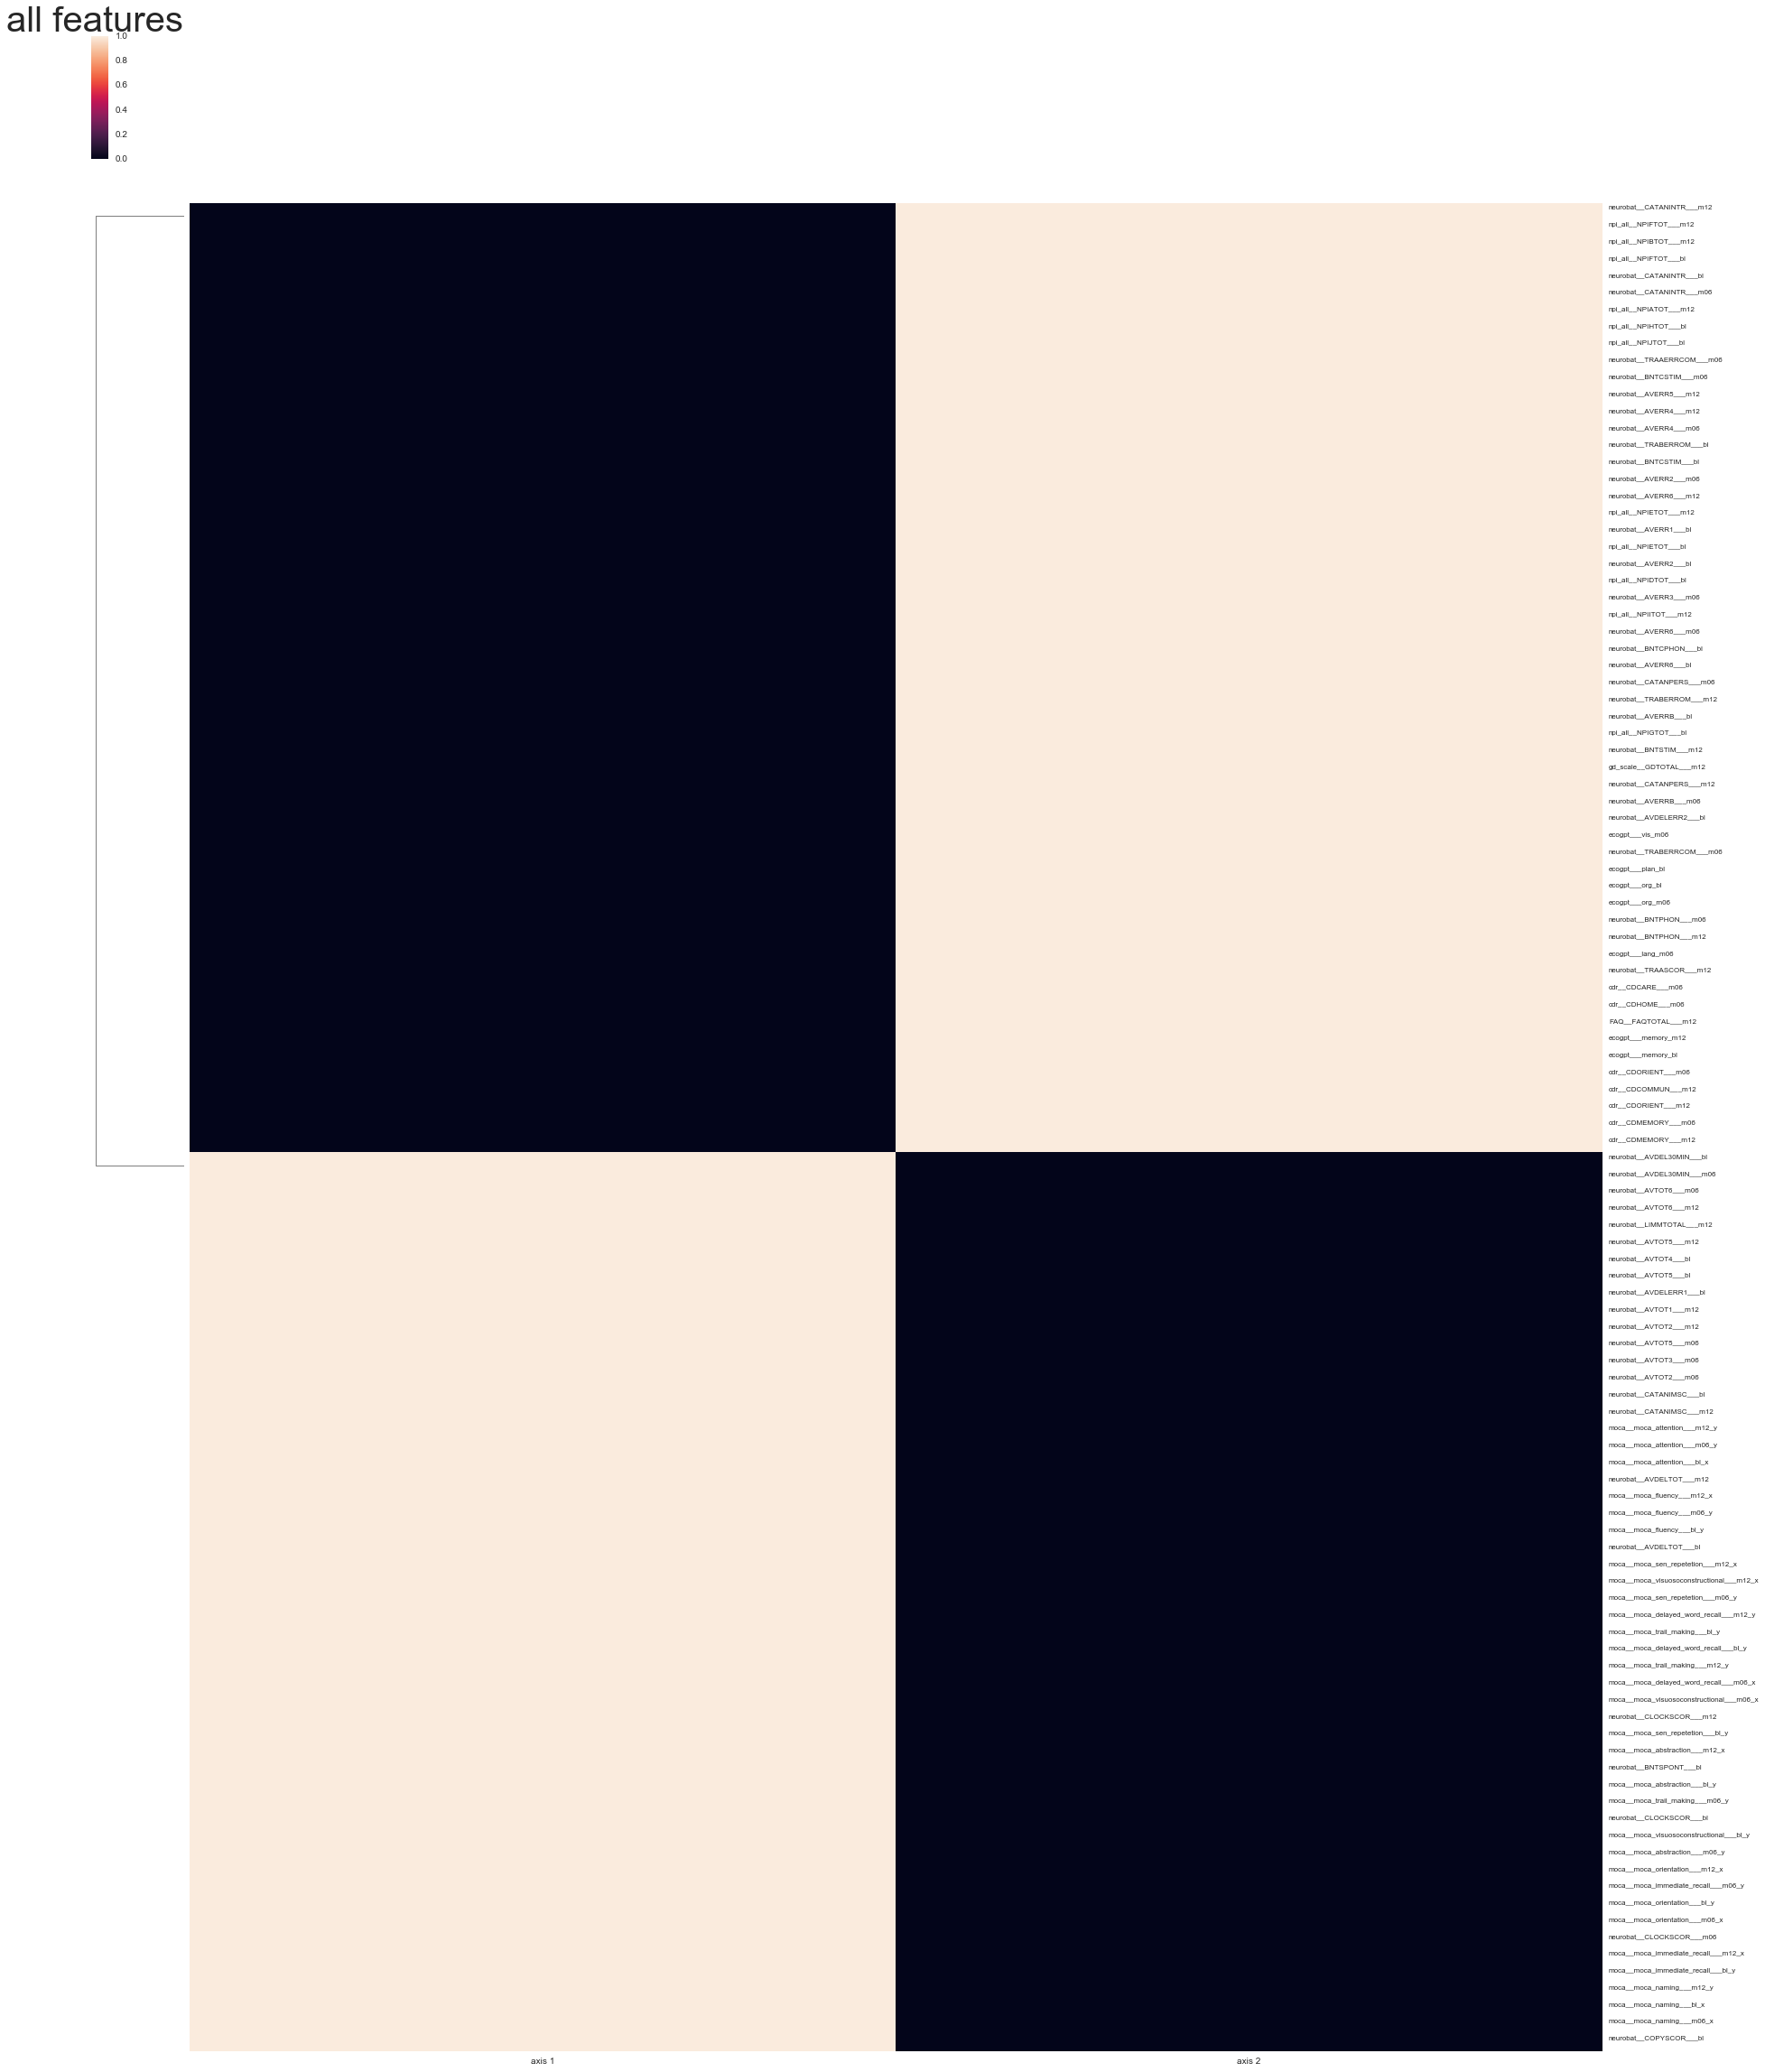

************************
Number of observations :
453
2    197
1    170
3     86
Name: DXCHANGE, dtype: int64
************************


In [95]:

list_months_to_be_considered = ['bl', 'm06','m12']
visits = 'm24'
redued_item_24, colors_categories_item_24, M_chosen_item_24,dignosis, M_H_T2, M_H_T3 = project_data(Max_intersection_dataset_item, visits, list_months_to_be_considered)
print('************************')
print('Number of observations :')
print(len(redued_item_24))
print(redued_item_24['DXCHANGE'].value_counts())
print('************************')


In [112]:

def plot_side_by_side_2d(M_mci_dem_nmf_proj,Predict, redued_item_24, colors_categories_item_24, case,algorithm):
    mlp.rc('font', size= 40)
    mlp.rc('axes', titlesize= 40)
    # in this function axis 3 is visualizing new predicted values and axis 4 is visualing old values obtained fron data
    Predict1 = Predict.copy(deep = True)
    f9 = plt.figure(figsize=(36,20))
    f9.suptitle("Alzheimer's Progression Space at 24th month\n (Using 12 month of data)", fontsize = 40)
    ax3 = f9.add_subplot(1, 2, 1)
    ax4 = f9.add_subplot(1, 2, 2)
    colors = pd.DataFrame(Predict1.replace([0,1,2,4],['yellow','blue','hotpink','cyan']))
    ax3.scatter(M_mci_dem_nmf_proj[['NMF_2_1']], M_mci_dem_nmf_proj[['NMF_2_2']], c = colors.iloc[:,0], alpha=0.5, s = 700)
    ax3.grid(True)
    ax3.set_xlabel('Cognitive decline', fontsize = 40)
    ax3.set_ylabel('Memory decline', fontsize = 40)
    ax3.set_title(" Classification by Algorithm ", fontsize = 40)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'yellow')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='hotpink')
    ax3.legend((p1,p2,p3), ('low','medium','High'), loc='best', fontsize = 40)
    #ax3.legend((p1,p3), ('low','High'), loc='best')
    ax4.scatter(redued_item_24[['NMF_2_1']], redued_item_24[['NMF_2_2']], c = colors_categories_item_24, alpha=0.5, s = 700)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
    ax4.legend((p1,p2,p3), ('Control','MCI','Dementia'), loc='best', fontsize = 40);
    ax4.grid(True)
    ax4.set_xlabel('Cognitive decline', fontsize = 40)
    ax4.set_ylabel('Memory decline', fontsize = 40)
    ax4.set_title(" Original Labels", fontsize = 40)
    plt.savefig(address + 'nmf_side_by_side.png',dpi = 100)
    
    # plot single grapf of new clusters
    mlp.rc('font', size= 40)
    mlp.rc('axes', titlesize= 40)
    Predict1 = Predict.copy(deep = True)
    f11 = plt.figure(figsize=(15,20))
    f11.suptitle("Alzheimer's Progression Space at 24th month\n (Using 12 month of data)", fontsize = 40)
    f11 = plt.figure(figsize=(18,18))
    ax5 = f11.add_subplot(1, 1, 1)
    colors = pd.DataFrame(Predict1.replace([0,1,2,4],['yellow','blue','hotpink','cyan']))
    ax5.scatter(M_mci_dem_nmf_proj[['NMF_2_1']], M_mci_dem_nmf_proj[['NMF_2_2']], c = colors.iloc[:,0], alpha=0.5, s = 700)
    ax5.grid(True)
    ax5.set_xlabel('Cognitive decline', fontsize = 40)
    ax5.set_ylabel('Memory decline', fontsize = 40)
    ax5.set_title(" Classification by Algorithm ", fontsize = 40)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'yellow')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='hotpink')
    ax5.legend((p1,p2,p3), ('low','medium','High'), loc='best')
    #ax3.legend((p1,p3), ('low','High'), loc='best')
    plt.savefig(address + 'nmf_single.png',dpi = 50)  


In [113]:

def plot_side_by_side_3d(M_mci_dem_nmf_proj,Predict, redued_item_24, colors_categories_item_24, case,algorithm):
    mlp.rc('font', size= 18)
    mlp.rc('axes', titlesize= 18)
    
    # in this function axis 3 is visualizing new predicted values and axis 4 is visualing old values obtained fron data
    Predict1 = Predict.copy(deep = True)
    f10 = plt.figure(figsize=(20,15))
    f10.suptitle("Classification by Algorithm", fontsize = 18)
    ax3 = plt.axes(projection='3d')
    colors = pd.DataFrame(Predict1.replace([0,1,2,4],['yellow','blue','hotpink','cyan']))
    ax3.scatter(M_mci_dem_nmf_proj[['NMF_3_1']], M_mci_dem_nmf_proj[['NMF_3_2']],M_mci_dem_nmf_proj[['NMF_3_3']] ,c = colors.iloc[:,0], alpha=0.8)
    ax3.grid(True)
    ax3.set_xlabel('Cognition', fontsize = 18)
    ax3.set_ylabel('Memory and Depression ', fontsize = 18)
    ax3.set_zlabel('Memory and Depression', fontsize = 18)
    ax3.view_init(30, 30)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'yellow')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='hotpink')
    ax3.legend((p1,p2,p3), ('low','medium','High'), loc='best')
    ax3.view_init(30, 30)
    #ax3.legend((p1,p3), ('low','High'), loc='best')
    plt.savefig(address + 'nmf_side_by_side_3d_original.png',dpi = 200)

0    143
1     79
2     61
Name: 0, dtype: int64
3.0    170
0.0    143
1.0     79
2.0     61
Name: predicted, dtype: int64


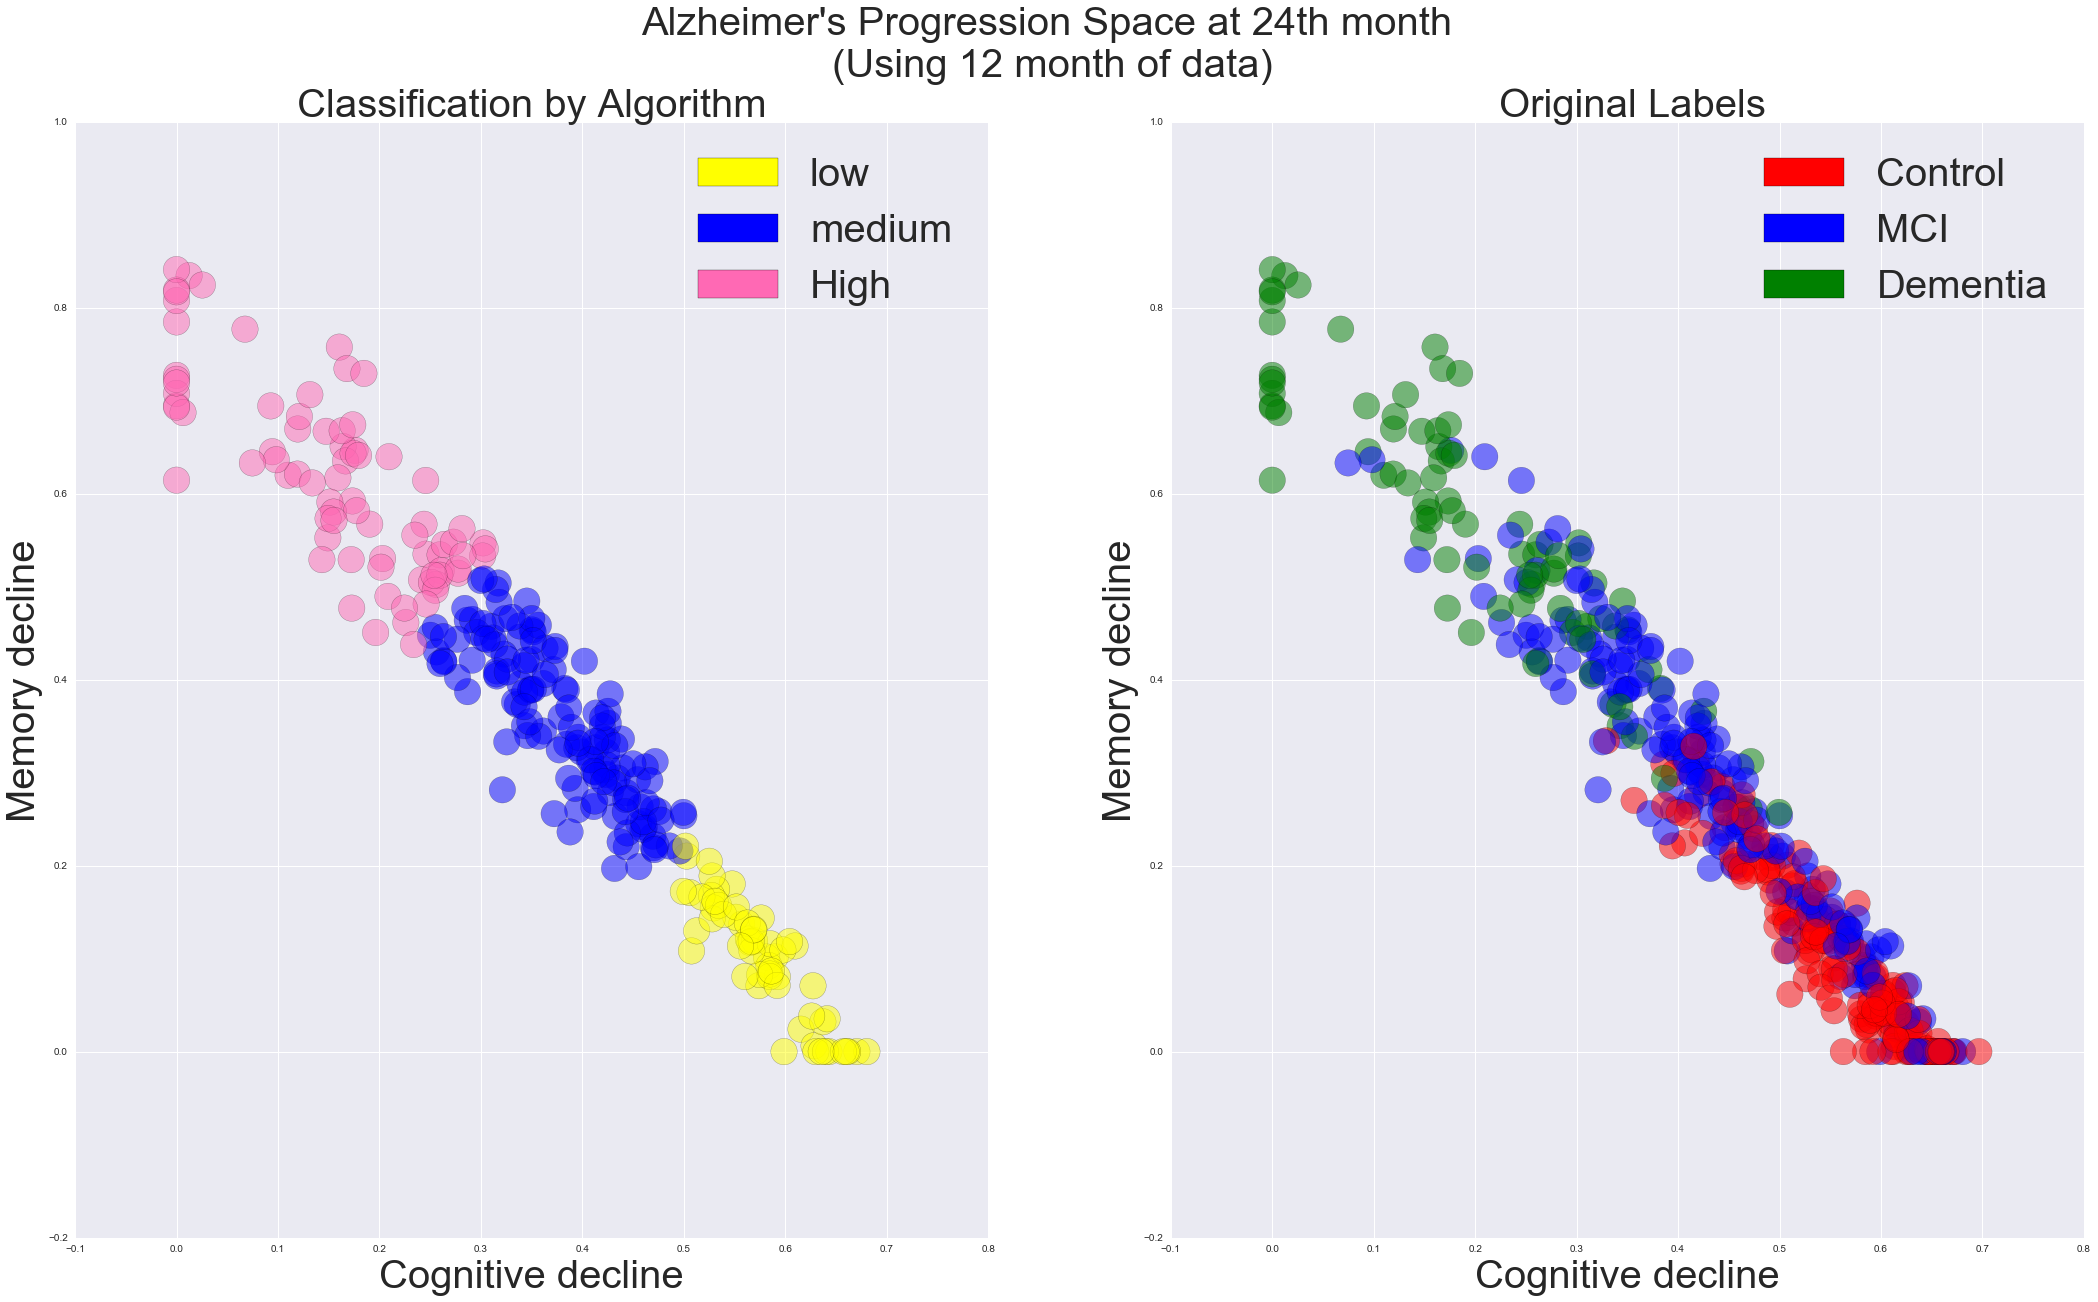

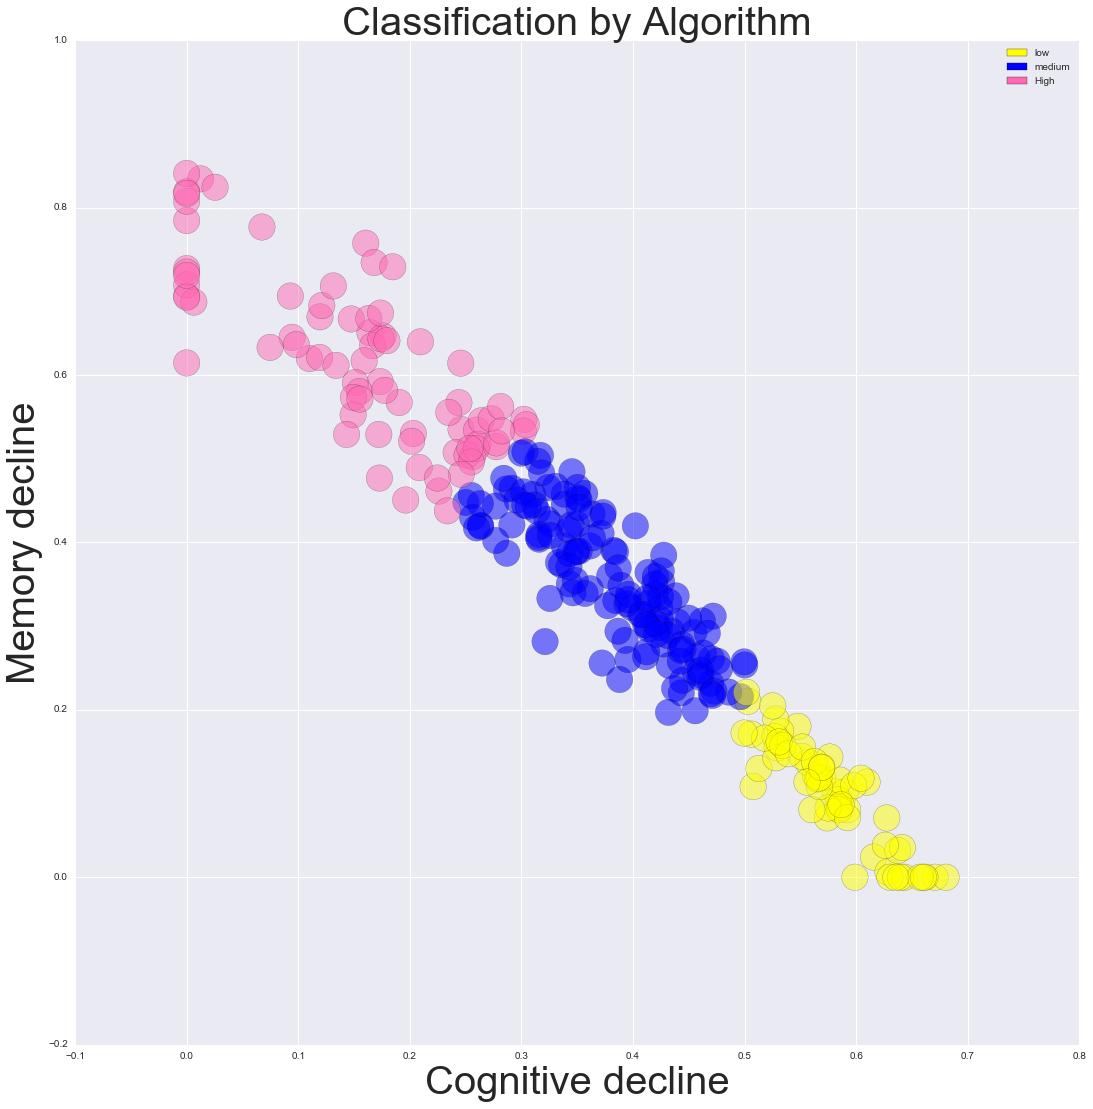

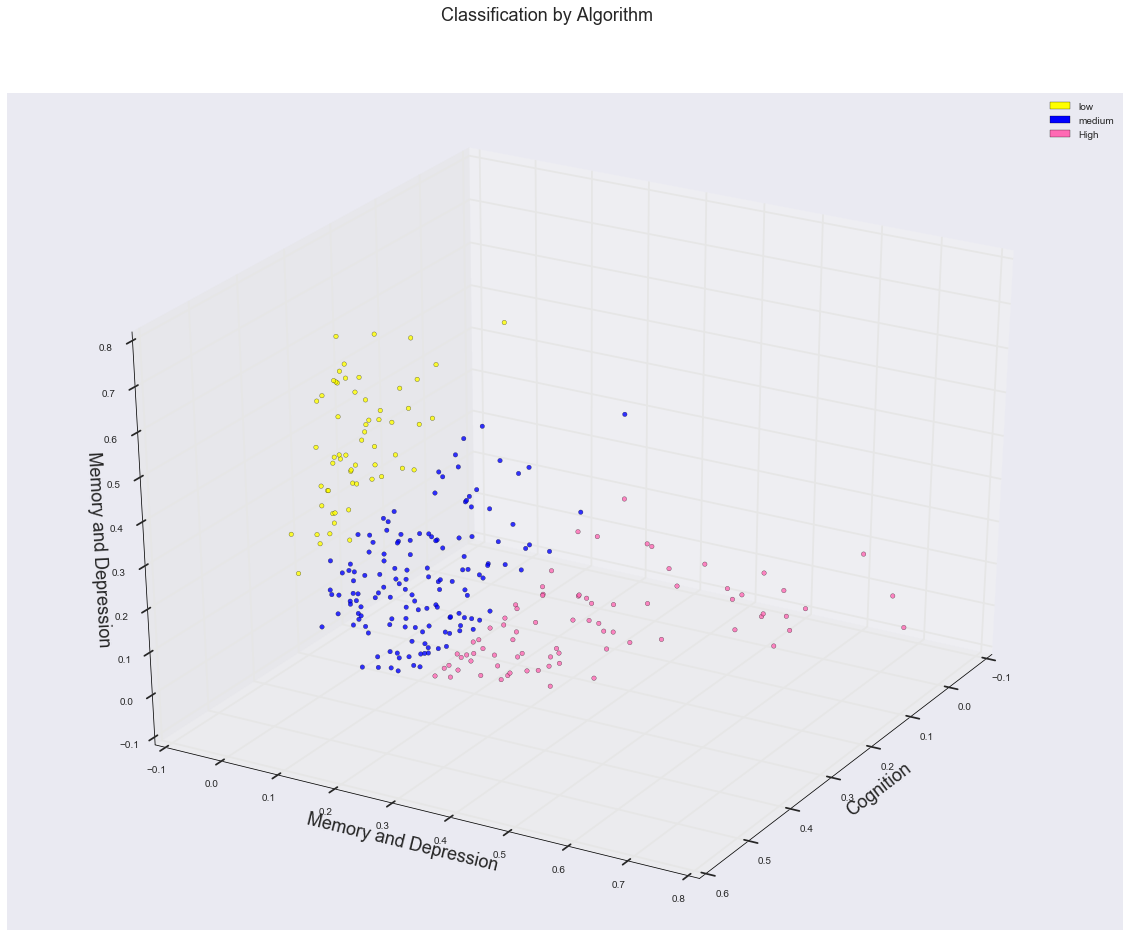

In [114]:
M_mci_dem = redued_item_24
M_mci_dem_nmf_all = M_mci_dem[['NMF_2_1','NMF_2_2','NMF_3_1', 'NMF_3_2','NMF_3_3']].copy()
M_mci_dem_nmf = M_mci_dem[['NMF_2_1', 'NMF_2_2']]
M_mci_dem_nmf_proj_all = M_mci_dem_nmf_all[~(redued_item_24.DXCHANGE.isin([1]) )] # removing controls
M_mci_dem_nmf_proj_3d_only = M_mci_dem_nmf_proj_all[['NMF_3_1','NMF_3_2','NMF_3_3']]
M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_all[['NMF_2_1','NMF_2_2']]

try:
    colors_categories_item_24_no_controls = redued_item_24[~(redued_item_24.DXCHANGE.isin([1]) )]['DXCHANGE'].replace([1,2,3], ['red', 'blue', 'green'])
except:
    pass

def organize_prediction_moca(M_mci_dem_nmf_proj_3d_only,Predict_gmm):
    M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_3d_only
    M_mci_dem_nmf_proj['predicted'] = Predict_gmm
    a = list(pd.unique(Predict_gmm.iloc[:,0]))
    srt = np.empty((len(a),2))
    for i in a:
        a = M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #b =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #c =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,0].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        srt[i,1] = a
        srt[i,0] = i
    srt = pd.DataFrame(srt).sort([1])
    Predict_gmm.replace([srt.iloc[0,0],srt.iloc[1,0], srt.iloc[2,0] ],[0,1,2], inplace=True)   
    return pd.DataFrame(Predict_gmm)

    


from sklearn import mixture
model_gmm = mixture.GaussianMixture(n_components=3, covariance_type='diag',  random_state = 0)
model_gmm.fit(M_mci_dem_nmf_proj) # print(gmm.means_)
# label the predicted and only keep HC and PDs
Predict_gmm = pd.DataFrame(model_gmm.predict(M_mci_dem_nmf_proj))
print(Predict_gmm.iloc[:,0].value_counts())

Predict_gmm.index = M_mci_dem_nmf_proj.index
Predict_gmm = organize_prediction_moca(M_mci_dem_nmf_proj,Predict_gmm)

plot_side_by_side_2d(M_mci_dem_nmf_proj,Predict_gmm,redued_item_24,colors_categories_item_24,'item24','gmm')       
plot_side_by_side_3d(M_mci_dem_nmf_proj_3d_only,Predict_gmm,redued_item_24,colors_categories_item_24,'item24','gmm')       
 

# line below will convert 4 classes into 3 classes
# Predict_gmm = Predict_gmm.replace([1,2],[1,1])
nl_data = M_mci_dem_nmf[(redued_item_24.DXCHANGE.isin([1]) )]
data_prediction_labels = pd.concat([nl_data,M_mci_dem_nmf_proj]).fillna(3)
print(data_prediction_labels.iloc[:,-1].value_counts())

data_prediction = pd.merge(M_chosen_item_24,pd.DataFrame(data_prediction_labels['predicted']),left_index = True, right_index = True, how='inner')

#[0,1,2,4],['yellow','blue','hotpink','cyan']


[ -413.02835711  -945.60041258 -4327.83237625 -4303.87418705
 -4346.82519342 -4327.79292852 -4317.62383019]


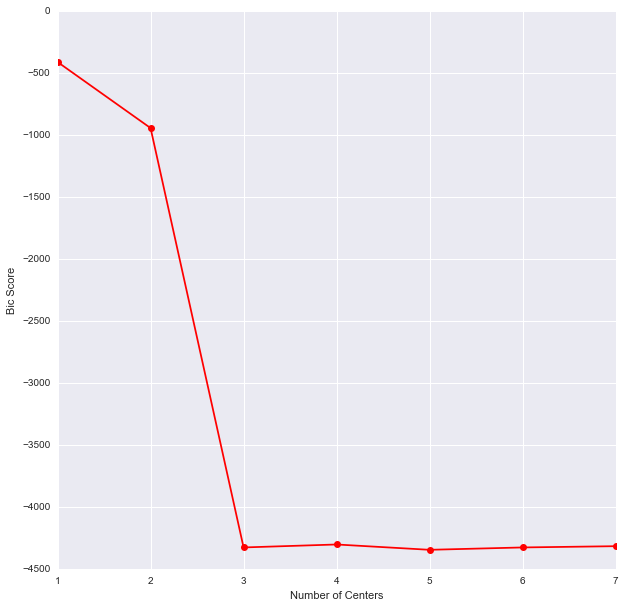

In [102]:


from sklearn import mixture
fig, ax = plt.subplots(figsize=(10, 10))
Nclusters = np.arange(1, 8)
# find best number of clusters via BIC
#clfs = [mixture.GaussianMixture(n_components=N, covariance_type='tied').fit(M_mci_dem_nmf_proj) for N in Nclusters]
clfs = [mixture.GaussianMixture(n_components=N, covariance_type='tied').fit(M_mci_dem_nmf_proj) for N in Nclusters]
BICs = np.array([clf.bic(M_mci_dem_nmf_proj) for clf in clfs])
clf = clfs[np.argmin(BICs)]
print(BICs)
# scatter the points
ax.plot(Nclusters, BICs, 'ro-')
plt.savefig(address + 'bic_48.png',dpi = 200)  
plt.xlabel('Number of Centers')
plt.ylabel('Bic Score')
plt.show()

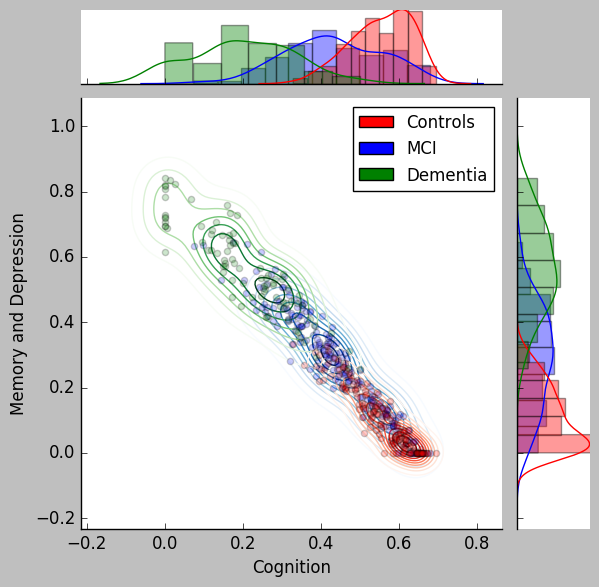

In [28]:

colors_categories_item_24 = pd.DataFrame(colors_categories_item_24)

import matplotlib as mpl
mpl.style.use('default')


x_blue = redued_item_24.loc[colors_categories_item_24.DXCHANGE.isin(['blue']),'NMF_2_1']
y_blue = redued_item_24.loc[colors_categories_item_24.DXCHANGE.isin(['blue']),'NMF_2_2']

x_red = redued_item_24.loc[colors_categories_item_24.DXCHANGE.isin(['red']),'NMF_2_1']
y_red = redued_item_24.loc[colors_categories_item_24.DXCHANGE.isin(['red']),'NMF_2_2']

x_green = redued_item_24.loc[colors_categories_item_24.DXCHANGE.isin(['green']),'NMF_2_1']
y_green = redued_item_24.loc[colors_categories_item_24.DXCHANGE.isin(['green']),'NMF_2_2']


plt.ion()
plt.show()
plt.pause(0.001)
a = 0.2
l = 10
zo = 0

p = sns.JointGrid(x = x_blue, y = y_blue)
p = p.plot_joint(plt.scatter, c="b", alpha = a)
# p.ax_marg_x.hist(-x_hc, alpha = 0.5, color='r')
# p.ax_marg_y.hist(y_hc, orientation = 'horizontal', alpha = 0.5, color='r')
p.plot_marginals(sns.distplot, color='b', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Blues")

p.x = x_red
p.y = y_red
p.plot_joint(plt.scatter, c="r", alpha = a)
p.plot_marginals(sns.distplot, color='r', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Reds")

p.x = x_green
p.y = y_green
p.plot_joint(plt.scatter, c="g", alpha = a)
p.plot_marginals(sns.distplot, color='g', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Greens")


p.set_axis_labels(xlabel='Cognition', ylabel='Memory and Depression')
# p.ax_joint.set_xticklabels([])
# p.ax_joint.set_yticklabels([])
# p.ax_marg_x.legend_.remove()

p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
plt.legend((p1, p2, p3), ('Controls', 'MCI', 'Dementia'), loc='best',prop={'size':12});
plt.savefig(address + 'gmm_original_joint_plot.png',dpi = 200)

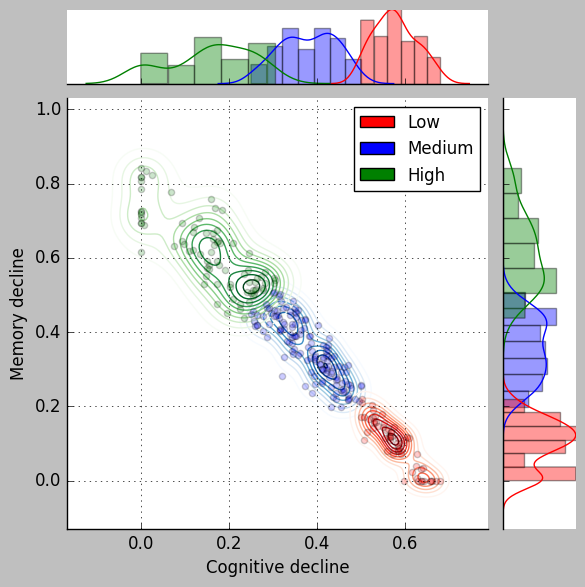

In [93]:
colors_categories_item_24 = pd.DataFrame(colors_categories_item_24)

import matplotlib as mpl
mpl.style.use('default')

x_red = M_mci_dem_nmf_proj.loc[Predict_gmm.iloc[:,0].isin([0]),'NMF_2_1']
y_red = M_mci_dem_nmf_proj.loc[Predict_gmm.iloc[:,0].isin([0]),'NMF_2_2']

x_blue = M_mci_dem_nmf_proj.loc[Predict_gmm.iloc[:,0].isin([1]),'NMF_2_1']
y_blue = M_mci_dem_nmf_proj.loc[Predict_gmm.iloc[:,0].isin([1]),'NMF_2_2']

x_green = M_mci_dem_nmf_proj.loc[Predict_gmm.iloc[:,0].isin([2]),'NMF_2_1']
y_green = M_mci_dem_nmf_proj.loc[Predict_gmm.iloc[:,0].isin([2]),'NMF_2_2']
plt.ion()
plt.show()
plt.pause(0.001)
a = 0.2
l = 10
zo = 0

p = sns.JointGrid(x = x_blue, y = y_blue)
p = p.plot_joint(plt.scatter, c="b", alpha = a)
# p.ax_marg_x.hist(-x_hc, alpha = 0.5, color='r')
# p.ax_marg_y.hist(y_hc, orientation = 'horizontal', alpha = 0.5, color='r')
p.plot_marginals(sns.distplot, color='b', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Blues")

p.x = x_red
p.y = y_red
p.plot_joint(plt.scatter, c="r", alpha = a)
p.plot_marginals(sns.distplot, color='r', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Reds")

p.x = x_green
p.y = y_green
p.plot_joint(plt.scatter, c="g", alpha = a)
p.plot_marginals(sns.distplot, color='g', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Greens")
plt.grid()

p.set_axis_labels(xlabel='Cognitive decline', ylabel='Memory decline')
# p.ax_joint.set_xticklabels([])
# p.ax_joint.set_yticklabels([])
# p.ax_marg_x.legend_.remove()

p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
plt.legend((p1, p2, p3), ('Low', 'Medium', 'High'), loc='best',prop={'size':12});
plt.savefig(address + 'Figure2.png',dpi = 200)


In [30]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.cross_validation import train_test_split
# from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
h = .02  # step size in the mesh
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

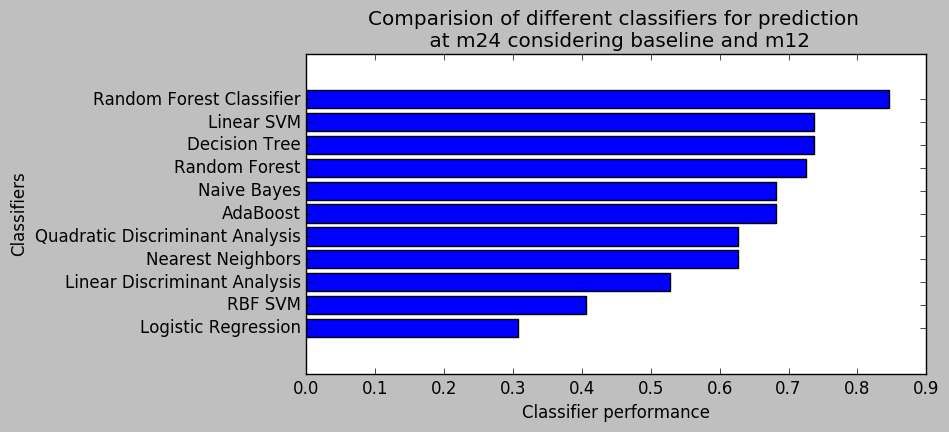

In [31]:

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "Linear Discriminant Analysis",
         "Quadratic Discriminant Analysis", "Logistic Regression"
         , "Random Forest Classifier"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    LogisticRegression(),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    RandomForestClassifier(n_estimators = 40)]

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# considering low mci and control same 
data_prediction1 = data_prediction.copy(deep = True)
data_prediction1['predicted'] = data_prediction1['predicted'].replace([3],[3])
del data_prediction1['predicted'] 

Predict_gmm = Predict_gmm.rename(columns={0: "predicted"})
data_prediction1 = pd.merge(data_prediction1,Predict_gmm,left_index = True, right_index = True, how='outer')
data_prediction1 = data_prediction1.fillna(3)

X_train, X_test, y_train, y_test = train_test_split(data_prediction1.iloc[:,0:-1], data_prediction1['predicted'], test_size=0.2, random_state=42)

x_full = data_prediction1.iloc[:,0:-1]
y_full = data_prediction1['predicted']


scores1 = []
score_entry = {}
y_pred = {}

# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score1 = clf.score(X_test, y_test)
    y_pred[name] = (clf.predict(X_test))
    scores1.append(score1)
    score_entry[name] = score1
  
    
# figure = plt.figure(figsize=(27, 9))
plt.figure(2, figsize=(8, 4))
imp, names = zip(*sorted(zip(scores1, names)))
plt.barh(range(len(names)), imp, align = 'center')
plt.yticks(range(len(names)), names)
plt.xlabel('Classifier performance')
plt.ylabel('Classifiers')
plt.title('Comparision of different classifiers for prediction \n at m24 considering baseline and m12')
plt.savefig(address + 'm48_m12_comparison.png',dpi = 200)
plt.show()

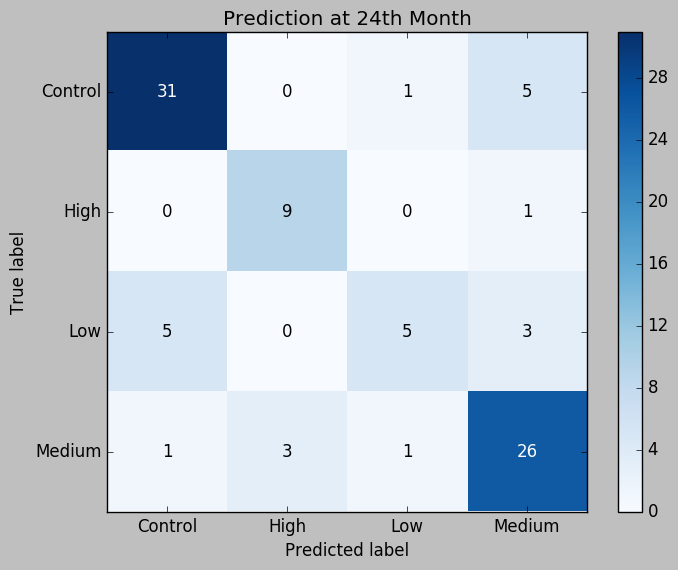

accuracy on test is
0.7802197802197802


In [32]:
#y_train = y_train.replace([1,2,3],['High MCI+Low Dementia', 'High Dementia', 'low MCI + control'])
rf = RandomForestClassifier(max_features= 'auto', n_estimators=25, max_depth= 10,class_weight= None, random_state= 0, min_samples_leaf =1)
rf.fit(X_train, y_train)
predictions  = rf.predict_proba(X_test)

y_predicted = rf.predict(X_test)
s = y_test.replace([1,2,0,3],['Medium', 'High', 'Low','Control'])
c = pd.DataFrame(y_predicted).replace([1,2,0,3],['Medium', 'High', 'Low','Control'])
skplt.metrics.plot_confusion_matrix(s,c, title = 'Prediction at 24th Month')
plt.savefig(address + 'confusion_matrix_24.png',dpi = 200)
plt.show()

score_on_test = accuracy_score(y_test, y_predicted)
print('accuracy on test is')
print(score_on_test)


In [33]:


# considering low mci and control same 
data_prediction1 = data_prediction.copy(deep = True)
data_prediction1['predicted'] = data_prediction1['predicted'].replace([3],[3])
del data_prediction1['predicted'] 

Predict_gmm = Predict_gmm.rename(columns={0: "predicted"})
data_prediction1 = pd.merge(data_prediction1,Predict_gmm,left_index = True, right_index = True, how='outer')
data_prediction1 = data_prediction1.fillna(3)


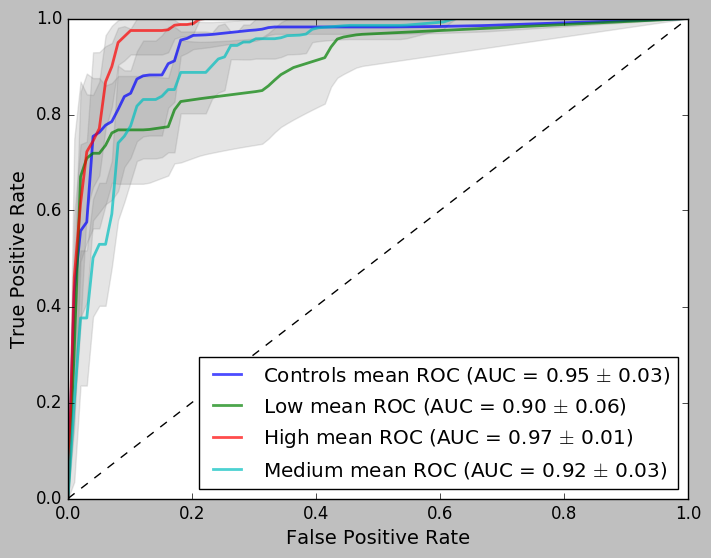

In [235]:

# 5 fold cv
from sklearn import metrics 
X,Y = data_prediction1.iloc[:,0:-1],data_prediction1['predicted']
n_classes = y_train.unique()
cv = StratifiedKFold(n_splits=5)
for k in n_classes:
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for train, test in cv.split(X,Y):
            pipeline = Pipeline([('classifier', RandomForestClassifier(max_features= None, n_estimators=35, max_depth= 10,class_weight= 'balanced', random_state= 0))])
            pipeline.fit(X.iloc[train], Y.iloc[train]==k)
            preds  = pipeline.predict_proba(X.iloc[test])
            label =  Y.iloc[test] == k
            fpr, tpr, _ = metrics.roc_curve(label, preds[:,1])
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = metrics.auc(fpr, tpr)
            aucs.append(roc_auc)
            i += 1
            
    class_name = 'Controls' if k==3 else 'Low' if k==0 else 'Medium' if k==1 else 'High'
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr,label= r'{0} mean ROC (AUC = {1:0.2f} $\pm$ {2:0.2f})'.format(class_name, mean_auc, std_auc) ,lw=2, alpha=.7)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2)
    #print(mean_fpr- tprs_upper)
    #print(std_tpr)


plt.figure(1, figsize=(18, 18))
plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([-0.025, 1.025])
# plt.ylim([-0.025, 1.025])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
#plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig(address + 'Figure3.png',dpi = 200)
plt.show()




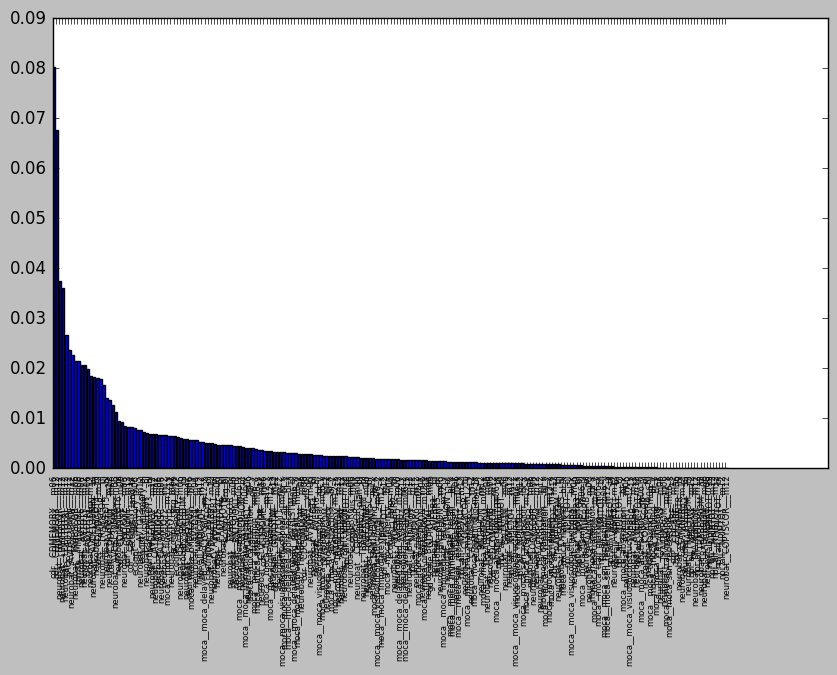

In [233]:
g = pd.DataFrame(np.empty((X_train.shape[1],2)))
ada = rf
ada.fit(X_train, y_train)
g.iloc[:,0] = (X_train.columns)
g.iloc[:,1] = ada.feature_importances_  
g = g.sort_values(by=[1],ascending=False)
plt.figure(figsize=(10,10))
plt.gcf().subplots_adjust(bottom=0.45)
plt.bar(range(g.shape[0]),g.iloc[:,1])
plt.xticks(range(len(g)),g.iloc[:,0] ,rotation=90)
plt.tick_params(axis='x', which='major', labelsize=6 )
plt.show()


In [34]:
#VISUALISATIONS 
cols['adni_merge'] = ['RID', 'VISCODE','COLPROT','AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY']
adni_merge = pd.read_csv('ADNI\\Raw_Data\\Demographic_Plots\\ADNIMERGE.csv', usecols=cols['adni_merge'], index_col = ['RID'])

#The patient who visited again and again in different VISCODES, keeping only the first visit
adni_merge = adni_merge.groupby(adni_merge.index).min()
adni_merge_chosen = adni_merge[adni_merge.index.isin(redued_item_24.index)] #CHANGE HERE FOR DIFFERENT DATASETS 

result = pd.concat([adni_merge_chosen, redued_item_24] , axis = 1, ignore_index= False)




result_control = result
x_min = np.min(result_control['NMF_2_1'] )
x_max = np.max (result_control['NMF_2_1'] )

y_min = np.min( result_control['NMF_2_2'] )
y_max = np.max( result_control['NMF_2_2'] )

x1 = x_min + 1*(x_max-x_min) / 2
#x2 = x_min + 2*(x_max-x_min) / 3


y1 = y_min + 1*(y_max-y_min) / 2
#y2 = y_max + 2*(y_max-y_min) / 3


print('4')
print(  np.mean(  result_control[   (result_control['NMF_2_2'] < y1 ) &  (result_control['NMF_2_1'] > x1 )    ]['AGE']  )  )
print(  np.std(  result_control[   (result_control['NMF_2_2'] < y1 ) &  (result_control['NMF_2_1'] > x1 )    ]['AGE']  )  )
print('1')
print(  np.mean(  result_control[( result_control['NMF_2_2'] > y1)&  (result_control['NMF_2_1'] > x1   )    ]['AGE']    ) )
print( np.std(    result_control[ (result_control['NMF_2_2'] > y1 )&  (result_control['NMF_2_1'] > x1)     ]['AGE']) )
print('2')
print(  np.mean(  result_control[ (result_control['NMF_2_2'] > y1) & ( result_control['NMF_2_1'] < x1 )      ]['AGE']    ) )
print( np.std(    result_control[ (result_control['NMF_2_2'] > y1) &  (result_control['NMF_2_1'] < x1 )    ]['AGE']) )
print('3')
print(  np.mean(  result_control[( result_control['NMF_2_2'] < y1) &  (result_control['NMF_2_1'] < x1 )      ]['AGE']    ) )
print( np.std(    result_control[ (result_control['NMF_2_2'] < y1) &  (result_control['NMF_2_1'] < x1 )    ]['AGE']) )



4
71.94476190476192
6.857145238094825
1
70.65555555555555
8.448946168488984
2
73.59722222222224
7.719005625046929
3
72.58571428571427
6.213984667037476


In [35]:
result_control['NMF_2_1_new'] = result_control['NMF_2_1'] * math.cos(math.radians(30)) -  result_control['NMF_2_2'] * math.sin(math.radians(30))


NameError: name 'math' is not defined

In [ ]:
import math
print( math.sin(math.radians(60))    )
result_control['NMF_2_1_new'] = result_control['NMF_2_1'] * math.cos(math.radians(50)) -  result_control['NMF_2_2'] * math.sin(math.radians(50))
result_control['NMF_2_2_new'] = result_control['NMF_2_2'] * math.cos(math.radians(50)) +  result_control['NMF_2_1'] * math.sin(math.radians(50))

#plot = plt.scatter(result_control['NMF_2_1_new'], result_control['NMF_2_2_new'], alpha=0.5, s = 100)
    
x_min = np.min(result_control['NMF_2_1_new'] )
x_max = np.max (result_control['NMF_2_1_new'] )

y_min = np.min( result_control['NMF_2_2_new'] )
y_max = np.max( result_control['NMF_2_2_new'] )

x1 = x_min + 1*(x_max-x_min) / 2
#x2 = x_min + 2*(x_max-x_min) / 3


y1 = y_min + 1*(y_max-y_min) / 2
#y2 = y_max + 2*(y_max-y_min) / 3


# print('4')
# print(  np.mean(  result_control[   (result_control['NMF_2_2_new'] < y1 )    ]['AGE']  )  )
# print(  np.std(  result_control[   (result_control['NMF_2_2_new'] < y1 )   ]['AGE']  )  )
# print('1')
# print(  np.mean(  result_control[( result_control['NMF_2_2_new'] > y1)    ]['AGE']    ) )
# print( np.std(    result_control[ (result_control['NMF_2_2_new'] > y1 )    ]['AGE']) )
print('2')
print(  np.mean(  result_control[result_control['NMF_2_1_new'] < x1      ]['AGE']    ) )
print( np.std(    result_control[ result_control['NMF_2_1_new'] < x1   ]['AGE']) )
print('3')
print(  np.mean(  result_control[ result_control['NMF_2_1_new'] > x1       ]['AGE']    ) )
print( np.std(    result_control[ result_control['NMF_2_1_new'] > x1     ]['AGE']) )








# print(  np.mean(  result_control[   (result_control['NMF_2_2'] < result_control['NMF_2_1'] ) ]['AGE']  )  )
# print(  np.std(  result_control[  (result_control['NMF_2_2'] < result_control['NMF_2_1'] )  ]['AGE']  )  )
# print(  np.mean(  result_control[   (result_control['NMF_2_2'] > result_control['NMF_2_1'] ) ]['AGE']  )  )
# print(  np.std(  result_control[  (result_control['NMF_2_2'] > result_control['NMF_2_1'] )  ]['AGE']  )  )



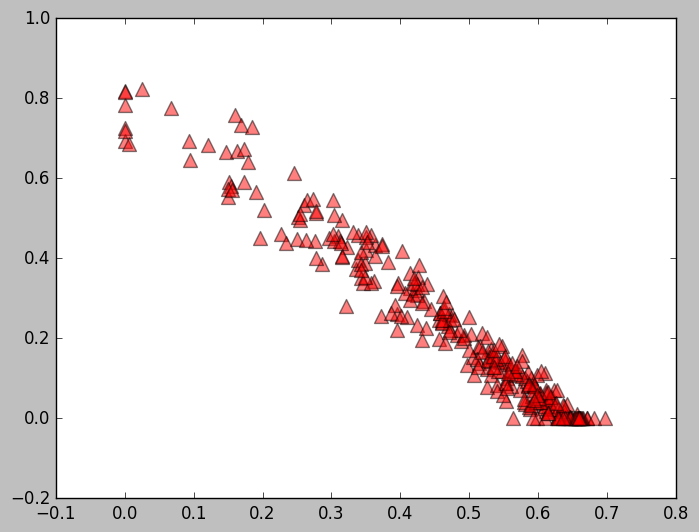

In [36]:
result_control_low = result_control[  result_control['AGE'] < 75 ]
result_control_high = result_control[  result_control['AGE'] > 75 ]
plt.scatter(result_control_low[['NMF_2_1']], result_control_low[['NMF_2_2']], c = 'red', marker = '^', s=100, alpha = 0.5)
#plt.scatter(result_control_high[['NMF_2_1']], result_control_high[['NMF_2_2']], marker = 'o', s=100, alpha = 0.5)


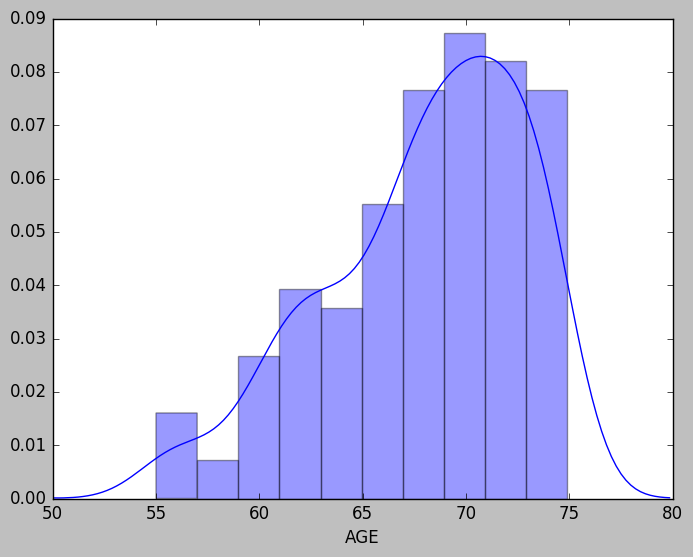

In [37]:
sns.distplot(result_control_low['AGE'])

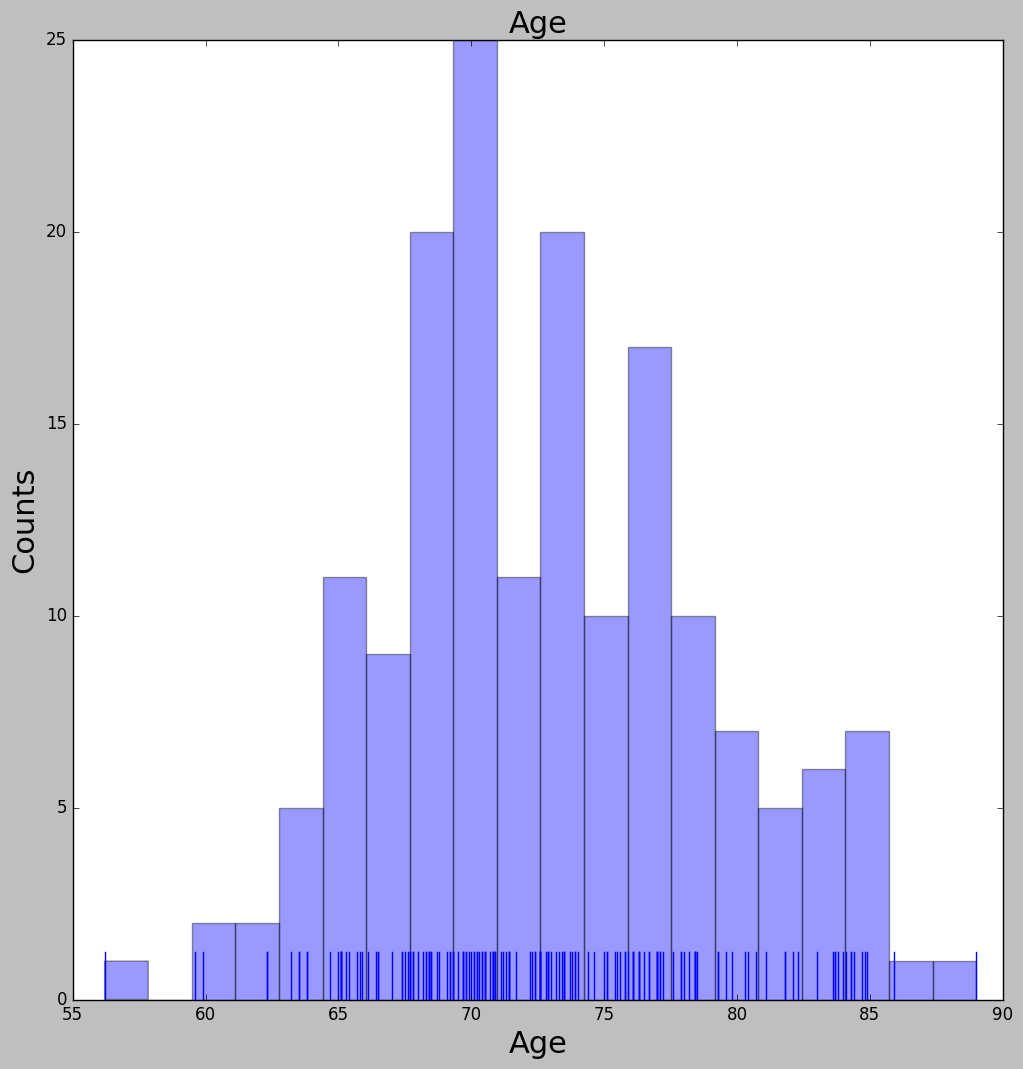

72.8929411764706
6.068607518653207
bottom
70.5524861878453
6.045075335165003
Top
73.53419117647054
7.516152220301666
left
73.64982332155472
7.409889173662305
right
70.16705882352944
5.999870356154159


In [38]:
result_control = result[result['DXCHANGE']==1] #Plotting only for a particular visit code
plt.figure(figsize = (12, 12))
sns.distplot(result_control['AGE'], bins=20, kde=False, rug=True);
plt.xlabel('Age', fontsize = 22)
plt.title('Age', fontsize = 22)
plt.ylabel('Counts', fontsize = 22)
plt.show()
print(result_control['AGE'].mean())
print(result_control['AGE'].std())

result_control = result
print('bottom')
print( np.mean(result_control[ result_control['NMF_2_2'] < 0.175       ]['AGE']) )
print( np.std(result_control[ result_control['NMF_2_2'] < 0.175      ]['AGE']) )
print('Top')
print( np.mean(result_control[ result_control['NMF_2_2'] > 0.175      ]['AGE']) )
print( np.std(result_control[ result_control['NMF_2_2'] > 0.175      ]['AGE']) )
print('left')
print( np.mean(result_control[ result_control['NMF_2_1'] < 0.525       ]['AGE']) )
print( np.std(result_control[ result_control['NMF_2_1'] < 0.525      ]['AGE']) )
print('right')
print( np.mean(result_control[ result_control['NMF_2_1'] > 0.525       ]['AGE']) )
print( np.std(result_control[ result_control['NMF_2_1'] > 0.525      ]['AGE']) )

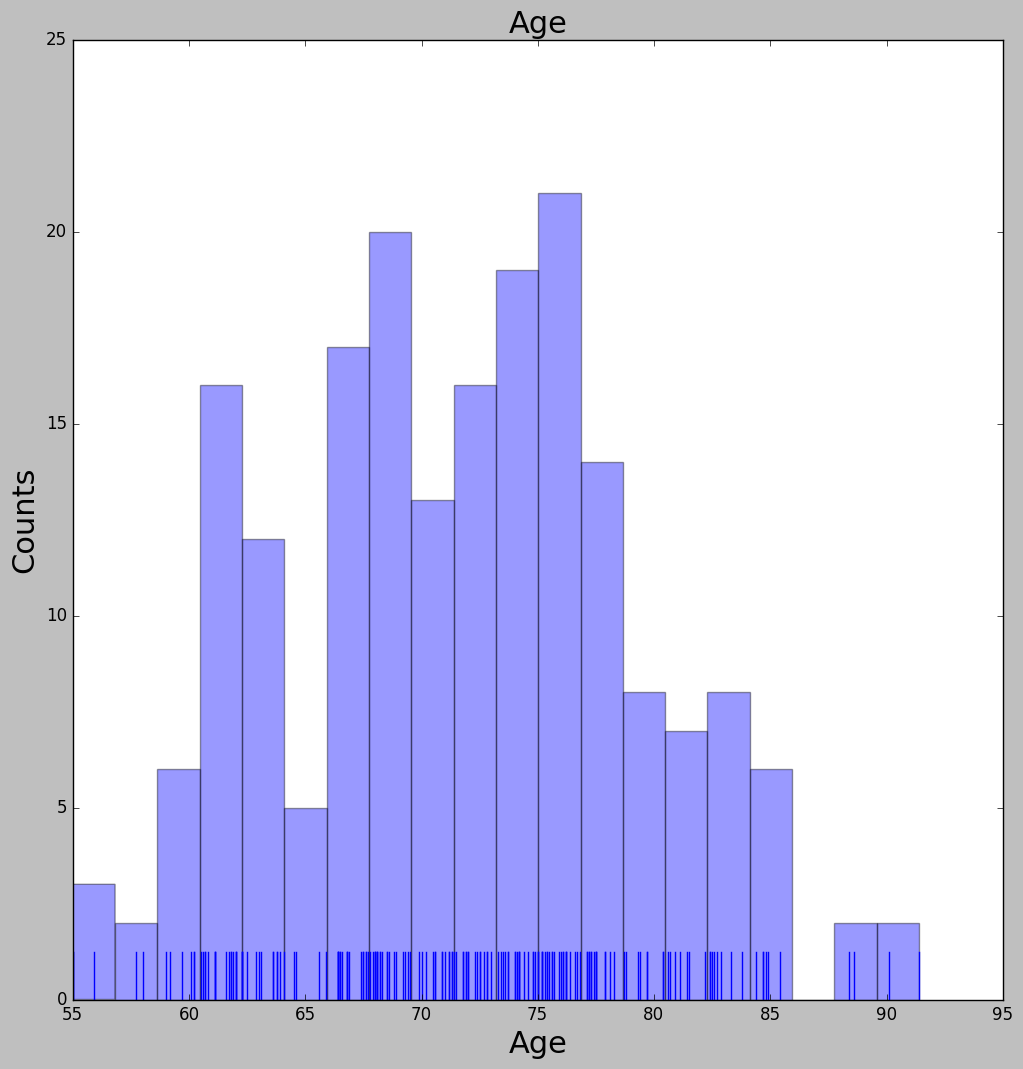

71.6147208121828
7.470973528086603
bottom
70.5524861878453
6.045075335165003
Top
73.53419117647054
7.516152220301666
left
73.64982332155472
7.409889173662305
right
70.16705882352944
5.999870356154159


In [39]:
result_control = result[result['DXCHANGE']==2] #Plotting only for a particular visit code
plt.figure(figsize = (12, 12))
sns.distplot(result_control['AGE'], bins=20, kde=False, rug=True);
plt.xlabel('Age', fontsize = 22)
plt.title('Age', fontsize = 22)
plt.ylabel('Counts', fontsize = 22)
plt.show()
print(result_control['AGE'].mean())
print(result_control['AGE'].std())
result_control = result
print('bottom')
print( np.mean(result_control[ result_control['NMF_2_2'] < 0.175       ]['AGE']) )
print( np.std(result_control[ result_control['NMF_2_2'] < 0.175      ]['AGE']) )
print('Top')
print( np.mean(result_control[ result_control['NMF_2_2'] > 0.175      ]['AGE']) )
print( np.std(result_control[ result_control['NMF_2_2'] > 0.175      ]['AGE']) )
print('left')
print( np.mean(result_control[ result_control['NMF_2_1'] < 0.525       ]['AGE']) )
print( np.std(result_control[ result_control['NMF_2_1'] < 0.525      ]['AGE']) )
print('right')
print( np.mean(result_control[ result_control['NMF_2_1'] > 0.525       ]['AGE']) )
print( np.std(result_control[ result_control['NMF_2_1'] > 0.525      ]['AGE']) )

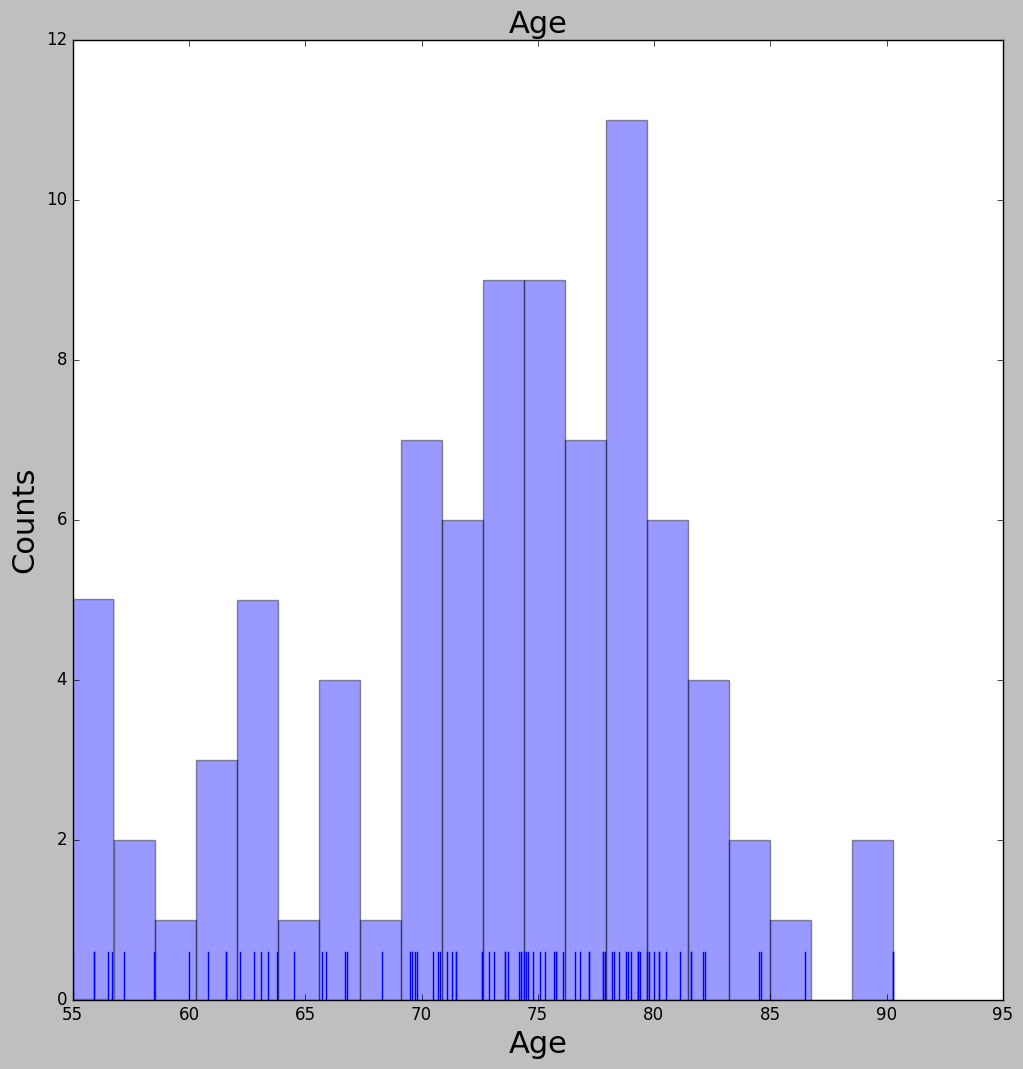

72.92325581395352
8.115238743450563
bottom
70.5524861878453
6.045075335165003
Top
73.53419117647054
7.516152220301666
left
73.64982332155472
7.409889173662305
right
70.16705882352944
5.999870356154159


In [40]:
result_control = result[result['DXCHANGE']==3] #Plotting only for a particular visit code
plt.figure(figsize = (12, 12))
sns.distplot(result_control['AGE'], bins=20, kde=False, rug=True);
plt.xlabel('Age', fontsize = 22)
plt.title('Age', fontsize = 22)
plt.ylabel('Counts', fontsize = 22)
plt.show()
print(result_control['AGE'].mean())
print(result_control['AGE'].std())

result_control = result
print('bottom')
print( np.mean(result_control[ result_control['NMF_2_2'] < 0.175       ]['AGE']) )
print( np.std(result_control[ result_control['NMF_2_2'] < 0.175      ]['AGE']) )
print('Top')
print( np.mean(result_control[ result_control['NMF_2_2'] > 0.175      ]['AGE']) )
print( np.std(result_control[ result_control['NMF_2_2'] > 0.175      ]['AGE']) )
print('left')
print( np.mean(result_control[ result_control['NMF_2_1'] < 0.525       ]['AGE']) )
print( np.std(result_control[ result_control['NMF_2_1'] < 0.525      ]['AGE']) )
print('right')
print( np.mean(result_control[ result_control['NMF_2_1'] > 0.525       ]['AGE']) )
print( np.std(result_control[ result_control['NMF_2_1'] > 0.525      ]['AGE']) )

In [41]:
def plot_age(M_mci_dem_nmf_proj, redued_item_24, colors_categories_item_24):
    mlp.rc('font', size= 18)
    mlp.rc('axes', titlesize= 18)
    f9 = plt.figure(figsize=(20,10))
    f9.suptitle("Alzheimer's Progression Space at 24th month\n (Using 12 month of data)", fontsize = 18)
    cm = plt.cm.get_cmap('RdYlBu')
    colors =    np.array(  M_mci_dem_nmf_proj['AGE']      )
    plot = plt.scatter(M_mci_dem_nmf_proj[['NMF_2_1']], M_mci_dem_nmf_proj[['NMF_2_2']], alpha=0.5, c = colors, s = 100, cmap = cm)
    plt.xlabel('Cognition', fontsize = 18)
    plt.ylabel('Memory and Depression', fontsize = 18)
    plt.title(" Classification by Algorithm ", fontsize = 18)
    plt.colorbar(plot)
    plt.show()

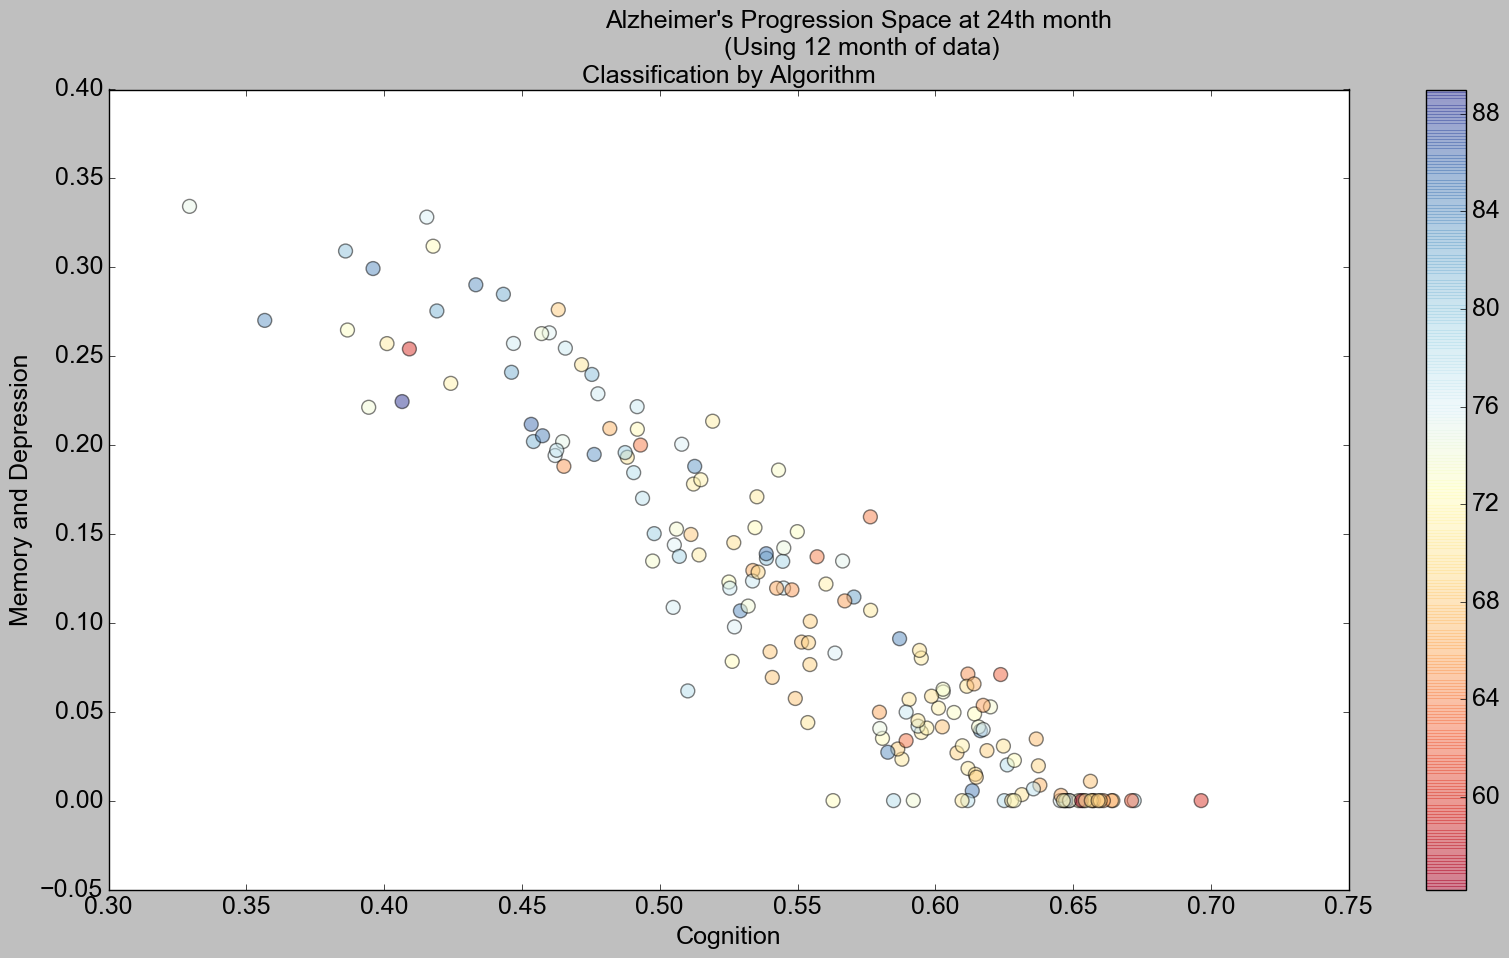

In [42]:
result_control = result[result['DXCHANGE']==1]

plot_age(result_control, redued_item_24, colors_categories_item_24)


In [43]:
def plot_age3(M_mci_dem_nmf_proj, redued_item_24, colors_categories_item_24):
    f9 = plt.figure(figsize=(20,10))
    ax= plt.axes(projection='3d')
    cm = plt.cm.get_cmap('RdYlBu')
    colors =    np.array(  M_mci_dem_nmf_proj['AGE']      )
    plot = ax.scatter(M_mci_dem_nmf_proj[['NMF_3_1']], M_mci_dem_nmf_proj[['NMF_3_2']],M_mci_dem_nmf_proj[['NMF_3_3']] , alpha=0.5, c = colors, s = 50, cmap = cm)
    ax.set_xlabel('Cognition', fontsize = 18)
    ax.set_ylabel('Memory and Depression', fontsize = 18)
    ax.set_zlabel(' Depression', fontsize = 18)
    ax.set_title(" Classification by Algorithm ", fontsize = 18)
    plt.colorbar(plot)
    ax.view_init(30,30)
    plt.show()



In [44]:
result_control = result[result['DXCHANGE']==1]

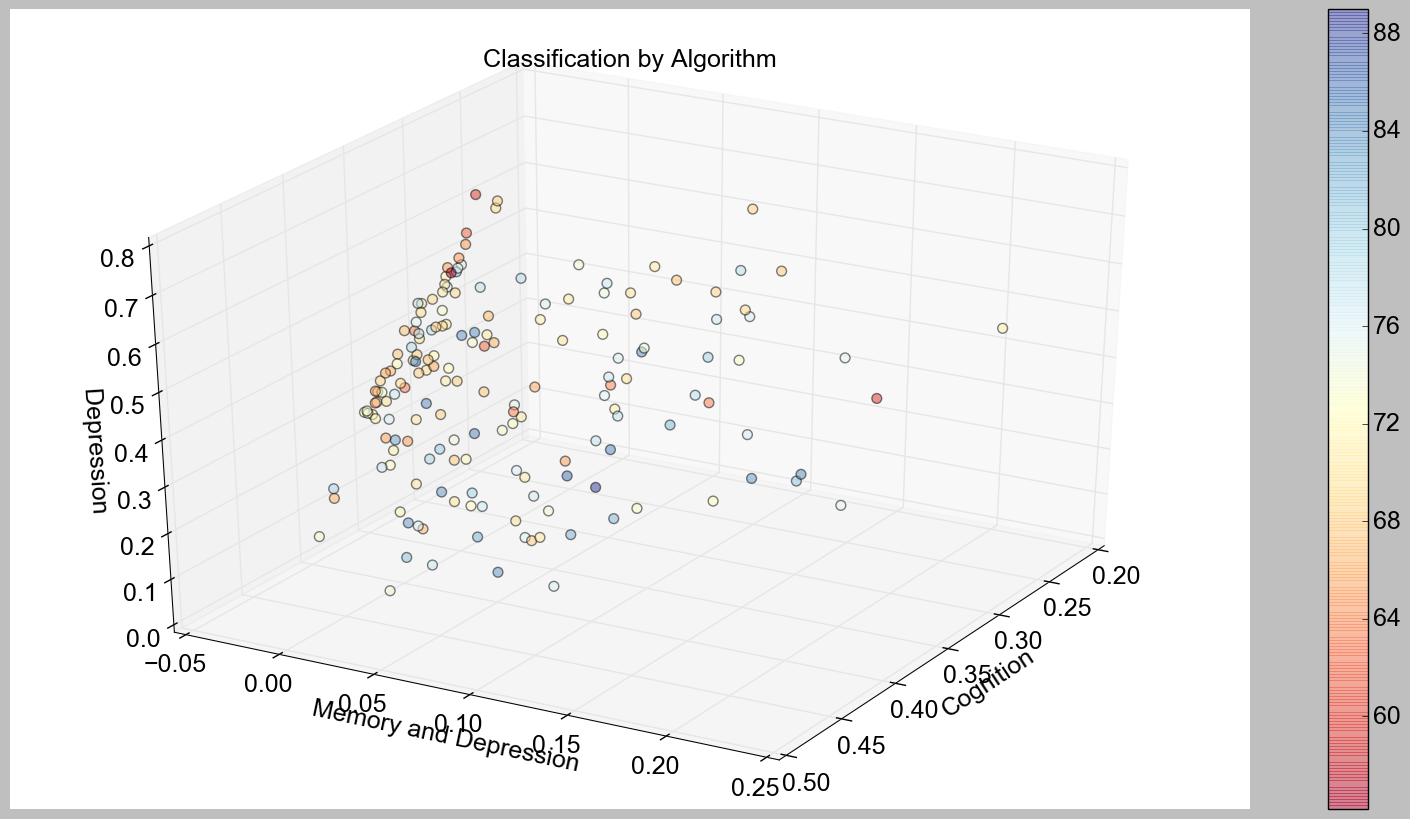

In [45]:
plot_age3(result_control, redued_item_24, colors_categories_item_24)

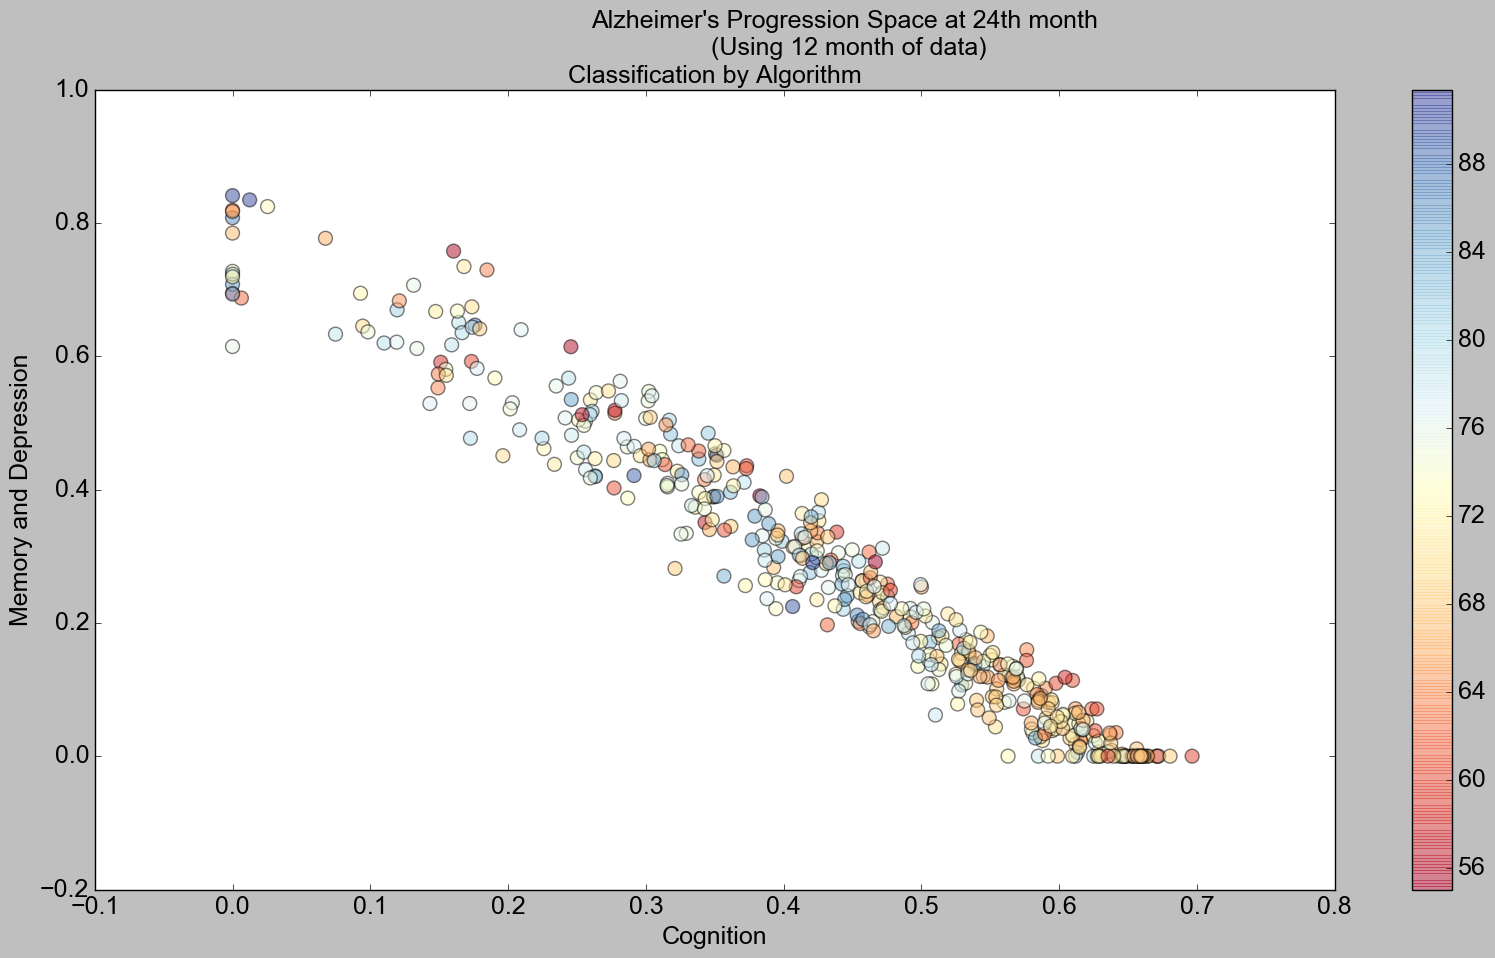

In [46]:
plot_age(result, redued_item_24, colors_categories_item_24)

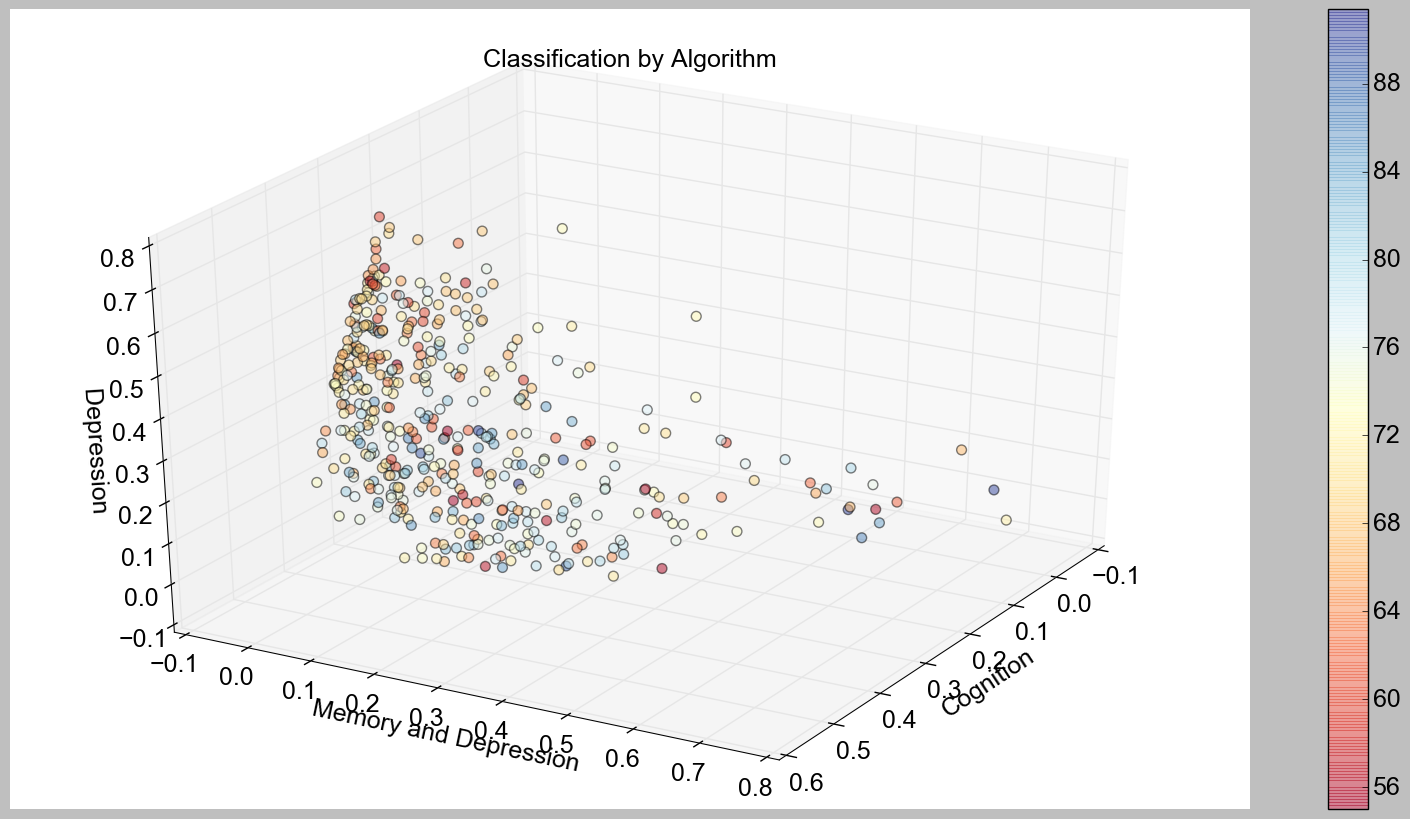

In [47]:
plot_age3(result, redued_item_24, colors_categories_item_24)

## NMF VAriance

In [99]:
def project_data_mchosen(Max_intersection_dataset, visit, list_months_to_be_considered):
    patno_filtered_visited = dict_datasets[Max_intersection_dataset[0]]

    for t in range(len(Max_intersection_dataset)):
        patients = dict_datasets[Max_intersection_dataset[t]]
        patno_filtered_visited = pd.merge(patno_filtered_visited, patients, left_index = True, right_index = True, how='inner')
        
    print('AAAAAAAAAAAAAAAAAAAA')
    M_chosen = normalize(patno_filtered_visited,'m')
    M_chosen = M_chosen.T[ M_chosen.T.isnull().sum(axis = 1)== 0 ].T
    return M_chosen




In [100]:
M_chosen = project_data_mchosen(Max_intersection_dataset_item, visits, list_months_to_be_considered)


AAAAAAAAAAAAAAAAAAAA


In [101]:
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics

def get_score(model, data, scorer=metrics.explained_variance_score):
    """ Estimate performance of the model on the data """
    prediction = model.inverse_transform(model.transform(data))
    return scorer(data, prediction)

[0.05622759854744342, 0.2355672122064018, 0.27008771268537884, 0.2882196692462479, 0.319033643635318, 0.33522501734793214, 0.35223494879410827, 0.3635899124828666, 0.3731634615638803]


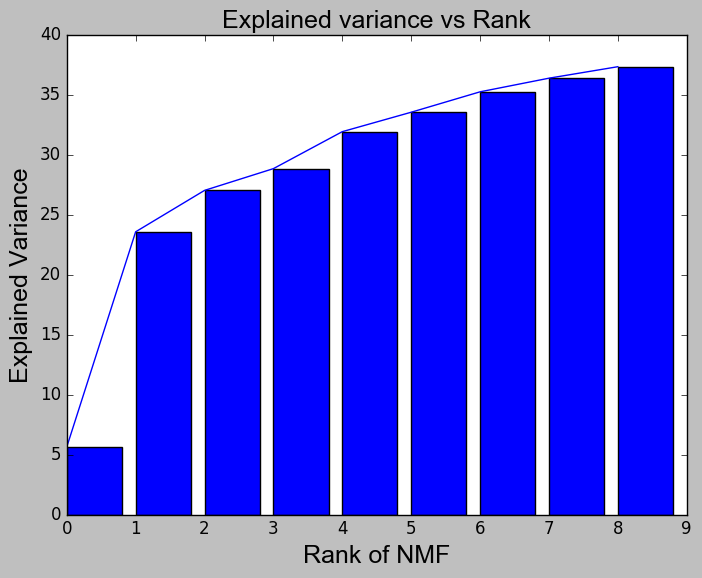

In [102]:
ks = list(range(1,10))
perfs_train = []
for k in ks:
    nmf = decomposition.NMF(n_components=k).fit(M_chosen)
    perfs_train.append(get_score(nmf, M_chosen))
print(perfs_train)
nmf_vals = perfs_train
nmf_vals[:] = [x * 100 for x in nmf_vals]


plt.plot(nmf_vals)
plt.bar( range(len(nmf_vals)) , nmf_vals)
plt.xlabel('Rank of NMF', fontsize = 18)
plt.ylabel('Explained Variance', fontsize = 18)
plt.title(" Explained variance vs Rank ", fontsize = 18)    
plt.show()  


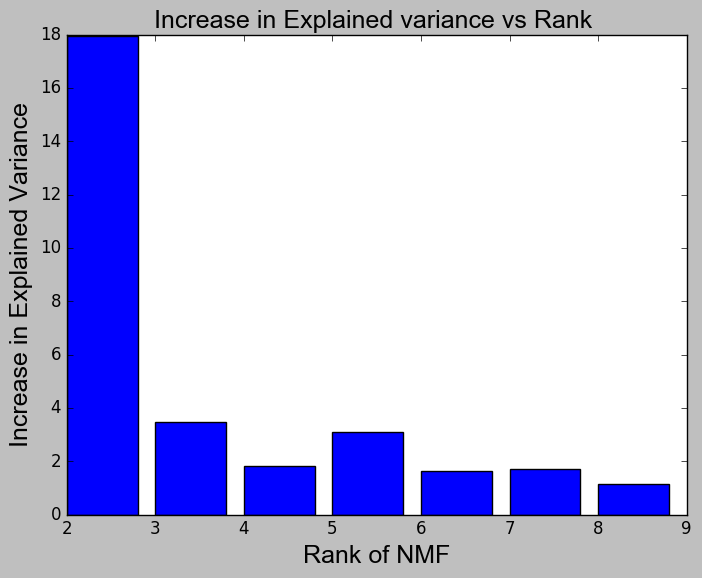

In [103]:
diff = [ (nmf_vals[i+1] - nmf_vals[i]) for i in range(0,len(ks)-2 ) ] 
plt.bar(range(2, (len(diff)+2) ),diff)
plt.xlabel('Rank of NMF', fontsize = 18)
plt.ylabel('Increase in Explained Variance', fontsize = 18)
plt.title(" Increase in Explained variance vs Rank  ", fontsize = 18)
plt.show() 
 

## Reversion 

In [39]:
def project_data_CN_MCI_DMN(Max_intersection_dataset, visit, list_months_to_be_considered):
    patno_filtered_visited = dict_datasets[Max_intersection_dataset[0]]

    for t in range(len(Max_intersection_dataset)):
        patients = dict_datasets[Max_intersection_dataset[t]]
        patno_filtered_visited = pd.merge(patno_filtered_visited, patients, left_index = True, right_index = True, how='inner')
        
    print('AAAAAAAAAAAAAAAAAAAA')
    M_chosen = normalize(patno_filtered_visited,'m')
    M_chosen = M_chosen.T[ M_chosen.T.isnull().sum(axis = 1)== 0 ].T
    M_W_columns = ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_2_1', 'PCA_2_2','ICA_1', 'ICA_2', 'NMF_2_1', 'NMF_2_2', 
               'NMF_3_1', 'NMF_3_2', 'NMF_3_3','ICA_3_1', 'ICA_3_2', 'ICA_3_3']
    M_W = pd.DataFrame(index=M_chosen.index, columns=M_W_columns)
    
    # PCA
    model_pca = sklearnPCA(n_components=3)
    M_W[['PCA_1', 'PCA_2', 'PCA_3']] = model_pca.fit_transform(M_chosen)
    model_pca = sklearnPCA(n_components=2)
    M_W[['PCA_2_1', 'PCA_2_2']] = model_pca.fit_transform(M_chosen)
    print('pcaaaaaaaaaaaaaaaaaaaaa')
    # ICA
    model_ICA = decomposition.FastICA(n_components=2)
    M_W[['ICA_1', 'ICA_2']] = model_ICA.fit_transform(M_chosen)
    model_ICA = decomposition.FastICA(n_components=3)
    M_W[['ICA_3_1', 'ICA_3_2', 'ICA_3_3']] = model_ICA.fit_transform(M_chosen)
    print('iiiiiiiiiiiiiiiiiiiiiAAAAAAAAAAAAAAAAAAAA')
    # NMF
    model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=200)
    model_NMF3 = decomposition.NMF(n_components=3, init='nndsvda', max_iter=200)
    M_W[['NMF_2_1', 'NMF_2_2']] = model_NMF.fit_transform(M_chosen)
    M_W[['NMF_3_1', 'NMF_3_2', 'NMF_3_3']] = model_NMF3.fit_transform(M_chosen)
    print('nmffffffffffffffffff')

    redued_data = pd.DataFrame(M_W) # this datset contains all the ICA, PCA and NMF vectors
    # plot the dimension reduction color makrked with participants' "categories", and "gender"
    dignosis = pd.read_csv("ADNI\\Raw_Data\\Assessment\\dxsum.csv",  usecols= ['RID','DXCHANGE','DXMDUE','DXCONFID','VISCODE'])
    dignosis = dignosis[ ~(dignosis['DXCHANGE'].isnull())]
    dignosis = dignosis[ ~(dignosis['DXMDUE'] == 'MCI due to other etiology')]
    dignosis = dignosis[ ~(dignosis['DXCONFID'] == 'Mildly Confident')]
    dignosis = dignosis[ ~(dignosis['DXCONFID'] == 'Uncertain')]
    dignosis = dignosis[dignosis['RID'].isin(redued_data.index)]
    dignosis = dignosis.set_index('RID')
    dignosis = dignosis[dignosis['VISCODE'] == visit]
    redued = redued_data.merge(dignosis, how = 'inner', left_index = True, right_index = True)
    redued = redued[ ~(redued['DXCHANGE'].isnull())]
    redued.DXCHANGE = redued.DXCHANGE.replace(['Stable: NL to NL', 'Stable: NL','Stable: MCI','Stable: MCI to MCI',\
                                               'Stable: Dementia', 'Stable: Dementia to Dementia',\
                                               'Conversion: NL to MCI','Conversion: MCI to Dementia','Conversion: NL to Dementia',\
                                               'Reversion: MCI to NL', 'Reversion: Dementia to MCI'],[1,1,2,2,3,3,4,5,6,7,8])
    # Replacing the codes as described earlier
    redued.DXCHANGE = redued.DXCHANGE.replace([1,2,3,4,5,6,7,8],[1,2,3,2,3,3,1,2]) 
    colors_categories = redued.DXCHANGE.replace([1,2,3], ['red', 'blue', 'green'])
    # use this or above 2 lines
    #colors_categories = redued.DXCHANGE.replace([1,2,3,4,5,6,7,8,9], ['red', 'blue', 'green', 'yellow','purple','pink','black','cyan','magenta'])
    list_of_colors = ['red', 'blue', 'green']

    return redued, colors_categories, M_chosen,dignosis, list_of_colors


In [40]:




def project_data(Max_intersection_dataset, visit, list_months_to_be_considered):
    patno_filtered_visited = dict_datasets[Max_intersection_dataset[0]]

    for t in range(len(Max_intersection_dataset)):
        patients = dict_datasets[Max_intersection_dataset[t]]
        patno_filtered_visited = pd.merge(patno_filtered_visited, patients, left_index = True, right_index = True, how='inner')
        
    print('AAAAAAAAAAAAAAAAAAAA')
    M_chosen = normalize(patno_filtered_visited,'m')
    M_chosen = M_chosen.T[ M_chosen.T.isnull().sum(axis = 1)== 0 ].T
    M_W_columns = ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_2_1', 'PCA_2_2','ICA_1', 'ICA_2', 'NMF_2_1', 'NMF_2_2', 
               'NMF_3_1', 'NMF_3_2', 'NMF_3_3','ICA_3_1', 'ICA_3_2', 'ICA_3_3']
    M_W = pd.DataFrame(index=M_chosen.index, columns=M_W_columns)
    
    # PCA
    model_pca = sklearnPCA(n_components=3)
    M_W[['PCA_1', 'PCA_2', 'PCA_3']] = model_pca.fit_transform(M_chosen)
    model_pca = sklearnPCA(n_components=2)
    M_W[['PCA_2_1', 'PCA_2_2']] = model_pca.fit_transform(M_chosen)
    print('pcaaaaaaaaaaaaaaaaaaaaa')
    # ICA
    model_ICA = decomposition.FastICA(n_components=2)
    M_W[['ICA_1', 'ICA_2']] = model_ICA.fit_transform(M_chosen)
    model_ICA = decomposition.FastICA(n_components=3)
    M_W[['ICA_3_1', 'ICA_3_2', 'ICA_3_3']] = model_ICA.fit_transform(M_chosen)
    print('iiiiiiiiiiiiiiiiiiiiiAAAAAAAAAAAAAAAAAAAA')
    # NMF
    model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=200)
    model_NMF3 = decomposition.NMF(n_components=3, init='nndsvda', max_iter=200)
    M_W[['NMF_2_1', 'NMF_2_2']] = model_NMF.fit_transform(M_chosen)
    M_W[['NMF_3_1', 'NMF_3_2', 'NMF_3_3']] = model_NMF3.fit_transform(M_chosen)
    print('nmffffffffffffffffff')
    
    
    H = model_NMF.components_
    H_columns = M_chosen.columns
    M_H = pd.DataFrame(columns=H_columns)
    M_H.loc[0] = H[0,:]
    M_H.loc[1] = H[1,:]
    M_H_T = M_H.T.sort_values(by=[1],ascending=False)
    M_H_T.columns = ['axis 1','axis 2']
    M_H_T = pd.DataFrame(M_H_T)
    M_H_T = M_H_T.div(M_H_T.sum(axis=1), axis=0)
    M_H_T['new'] = 0
    M_H_T['new'] = M_H_T.apply(lambda M_H_T :  'axis 1' if (M_H_T['axis 1']> M_H_T['axis 2']+(M_H_T['axis 2'] *0.05) ) else 'axis 2' if (M_H_T['axis 2'] > M_H_T['axis 1'] +(M_H_T['axis 1']*0.05) ) else 'ambigious', axis=1)
    
    M_H_T.to_csv(address + "all_2d_list.csv") 
    
    H = model_NMF3.components_
    H_columns = M_chosen.columns
    M_H = pd.DataFrame(columns=H_columns)
    M_H.loc[0] = H[0,:]
    M_H.loc[1] = H[1,:]
    M_H.loc[2] = H[2,:]
    M_H_T = M_H.T.sort_values(by=[2],ascending=False)
    M_H_T.columns = ['axis 1','axis 2', 'axis 3']
    M_H_T = pd.DataFrame(M_H_T)
    M_H_T = M_H_T.div(M_H_T.sum(axis=1), axis=0)
    M_H_T['new'] = 0
    M_H_T['new'] = M_H_T.apply(lambda M_H_T :  'axis 1' if (M_H_T['axis 1']> M_H_T['axis 2']+M_H_T['axis 3'] ) else 'axis 2' if (M_H_T['axis 2'] > M_H_T['axis 1'] +M_H_T['axis 3']) else 'axis 3' if (M_H_T['axis 3'] > M_H_T['axis 1'] +M_H_T['axis 2']) else 'ambigious'  , axis=1)
    M_H_T.to_csv(address + "all_3d_list.csv") 
    
    redued_data = pd.DataFrame(M_W) # this datset contains all the ICA, PCA and NMF vectors
    # plot the dimension reduction color makrked with participants' "categories", and "gender"
    dignosis = pd.read_csv("ADNI\\Raw_Data\\Assessment\\dxsum.csv",  usecols= ['RID','DXCHANGE','DXMDUE','DXCONFID','VISCODE'])
    dignosis = dignosis[ ~(dignosis['DXCHANGE'].isnull())]
    dignosis = dignosis[ ~(dignosis['DXMDUE'] == 'MCI due to other etiology')]
    dignosis = dignosis[ ~(dignosis['DXCONFID'] == 'Mildly Confident')]
    dignosis = dignosis[ ~(dignosis['DXCONFID'] == 'Uncertain')]
    dignosis = dignosis[dignosis['RID'].isin(redued_data.index)]
    dignosis = dignosis.set_index('RID')
    dignosis = dignosis[dignosis['VISCODE'] == visit]
    redued = redued_data.merge(dignosis, how = 'inner', left_index = True, right_index = True)
    redued = redued[ ~(redued['DXCHANGE'].isnull())]
#     redued.DXCHANGE = redued.DXCHANGE.replace(['Stable: NL to NL', 'Stable: NL','Stable: MCI','Stable: MCI to MCI',\
#                                                'Stable: Dementia', 'Stable: Dementia to Dementia',\
#                                                'Conversion: NL to MCI','Conversion: MCI to Dementia','Conversion: NL to Dementia',\
#                                                'Reversion: MCI to NL', 'Reversion: Dementia to MCI'],[1,1,2,2,3,3,4,5,6,7,8])
    
    redued['DXCHANGE_2'] = redued.DXCHANGE
    redued['DXCHANGE_original'] = redued.DXCHANGE
    redued.DXCHANGE = redued.DXCHANGE.replace(['Stable: NL to NL', 'Stable: NL','Stable: MCI','Stable: MCI to MCI','Stable: Dementia', 'Stable: Dementia to Dementia','Conversion: NL to MCI','Conversion: MCI to Dementia','Conversion: NL to Dementia','Reversion: MCI to NL', 'Reversion: Dementia to MCI'],[1,1,2,2,3,3,4,5,6,7,8])
    redued.DXCHANGE_2 = redued.DXCHANGE_2.replace(['Stable: NL to NL', 'Stable: NL','Stable: MCI','Stable: MCI to MCI','Stable: Dementia', 'Stable: Dementia to Dementia','Conversion: NL to MCI','Conversion: MCI to Dementia','Conversion: NL to Dementia','Reversion: MCI to NL', 'Reversion: Dementia to MCI'],[1,1,2,2,3,3,4,5,6,7,8])
    
    # Replacing the codes as described earlier
#     redued.DXCHANGE = redued.DXCHANGE.replace([1,2,3,4,5,6,7,8],[1,2,3,2,3,3,1,2]) 
#     colors_categories = redued.DXCHANGE.replace([1,2,3], ['red', 'blue', 'green'])
    # use this or above 2 lines
    redued.DXCHANGE  = redued.DXCHANGE.replace( [1,1,2,2,3,3,4,5,6,7,8] , ['#377eb8', '#377eb8', '#ff7f00', '#ff7f00', '#4daf4a', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999','#e41a1c' ] )
    colors_categories = redued.DXCHANGE
    list_of_colors = ['#377eb8', '#377eb8', '#ff7f00', '#ff7f00', '#4daf4a', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999','#e41a1c' ]                                            
    list_prog = ['Stable: NL to NL', 'Stable: NL','Stable: MCI','Stable: MCI to MCI','Stable: Dementia', 'Stable: Dementia to Dementia','Conversion: NL to MCI','Conversion: MCI to Dementia','Conversion: NL to Dementia','Reversion: MCI to NL','Reversion: Dementia to MCI']
    list_replace = [1,1,2,2,3,3,4,5,6,7,8]
    return redued, colors_categories, M_chosen,dignosis, list_of_colors,list_prog,list_replace
#CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']




In [41]:
list_months_to_be_considered = ['bl', 'm06','m12']
visits = 'm24'
redued_item_CN_MCI_DMN, colors_categories_item_CN_MCI_DMN, M_chosen_item_CN_MCI_DMN,dignosis_CN_MCI_DMN,list_of_colors_CN_MCI_DMN = project_data_CN_MCI_DMN(Max_intersection_dataset_item, visits, list_months_to_be_considered)
print('************************')




AAAAAAAAAAAAAAAAAAAA
pcaaaaaaaaaaaaaaaaaaaaa
iiiiiiiiiiiiiiiiiiiiiAAAAAAAAAAAAAAAAAAAA
nmffffffffffffffffff
************************


In [42]:
list_months_to_be_considered = ['bl', 'm06','m12']
visits = 'm24'
redued_item_24, colors_categories_item_24, M_chosen_item_24,dignosis,list_of_colors ,list_prog, list_replace= project_data(Max_intersection_dataset_item, visits, list_months_to_be_considered)
print('************************')
print('Number of observations :')
print(len(redued_item_24))
print(redued_item_24['DXCHANGE'].unique())
print('************************')

AAAAAAAAAAAAAAAAAAAA
pcaaaaaaaaaaaaaaaaaaaaa
iiiiiiiiiiiiiiiiiiiiiAAAAAAAAAAAAAAAAAAAA
nmffffffffffffffffff
************************
Number of observations :
453
['#377eb8' '#ff7f00' '#4daf4a' '#a65628' '#999999' '#f781bf' '#e41a1c']
************************


In [72]:

def projections(redued,colors_categories, colors_categories_item_CN_MCI_DMN,list_of_colors, list_prog,list_replace,show):
    redued.merge(colors_categories.to_frame(), left_index=True, right_index=True)
    if show == 'MCI to DEMENTIA':
        a = 7
    elif show== 'NL to Dementia':
        a = 8
    elif show== 'MCI to NL':
        a = 9
    elif show== 'Dementia to MCI':
        a = 10
    elif show== 'NL to MCI':
        a = 6    
        
    redued_1 = redued[ redued.DXCHANGE_2.isin([list_replace[a]])]
#        reduced_columns = list( reduced.columns)
#        reduced_columns = reduced_columns.remove(2)
    colors_categories = redued_1['DXCHANGE']
        
    fig = plt.figure(4, figsize=(18,18))
    ax1 = fig.add_subplot(111)
    ax1.scatter(redued_1[['NMF_2_1']], redued_1[['NMF_2_2']], c = redued_1['DXCHANGE'], s=700, marker='v')
    plt.title(show, fontsize = 40)
    ax1.scatter(redued[['NMF_2_1']], redued[['NMF_2_2']], edgecolors = colors_categories_item_CN_MCI_DMN, s= 600,facecolors='none', alpha = 0.95)#,linewidth= 1.5)


    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'red')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'green')
    p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc= list_of_colors[a])
    plt.legend((p1, p2, p3, p4), ('Control', 'MCI','Dementia', list_prog[a] ), loc='best', fontsize = 30);

    plt.xlim((-.02, 0.8))
    plt.ylim((-.02, 1.0)) 
    plt.xlabel('Cognition', fontsize = 40)
    plt.ylabel('Memory and Deprtession', fontsize = 40)
    plt.grid(True)
    plt.savefig(address + 'reversion_' + show + '_.png',dpi = 200)
    plt.show()

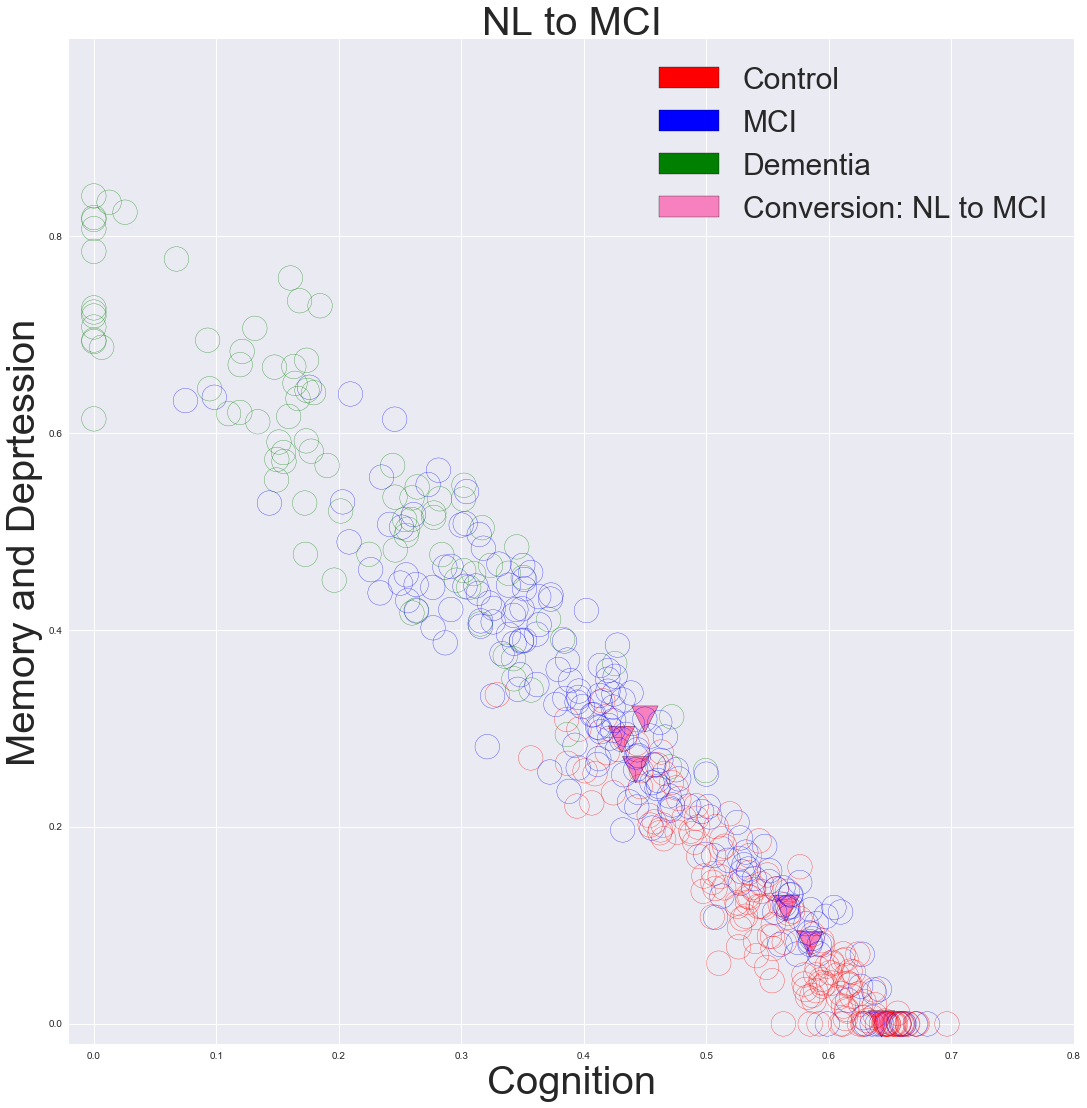

In [73]:
projections(redued_item_24,colors_categories_item_24, colors_categories_item_CN_MCI_DMN \
            ,list_of_colors,list_prog,list_replace, 'NL to MCI')

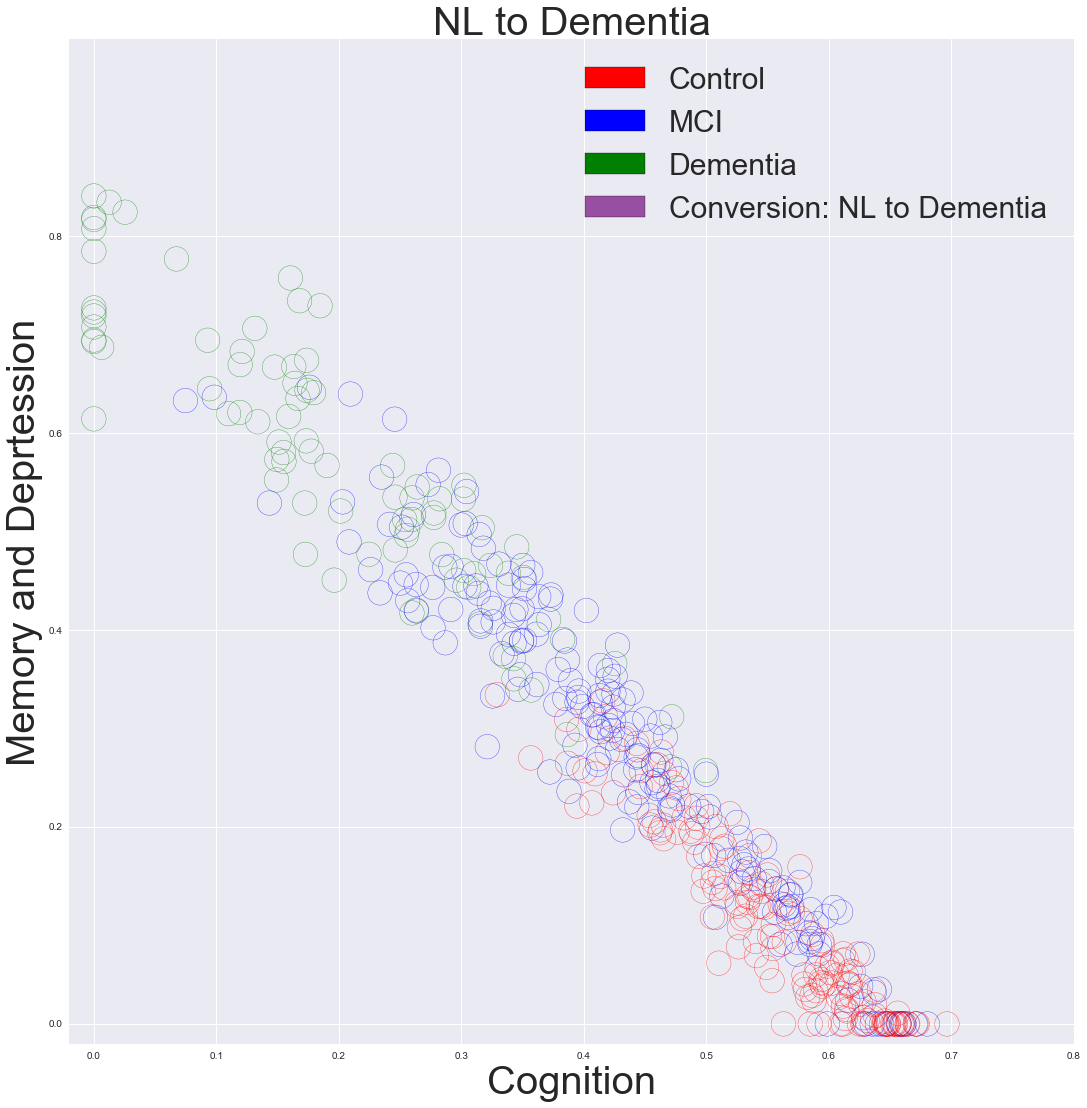

In [74]:
projections(redued_item_24,colors_categories_item_24, colors_categories_item_CN_MCI_DMN \
            ,list_of_colors,list_prog,list_replace, 'NL to Dementia')


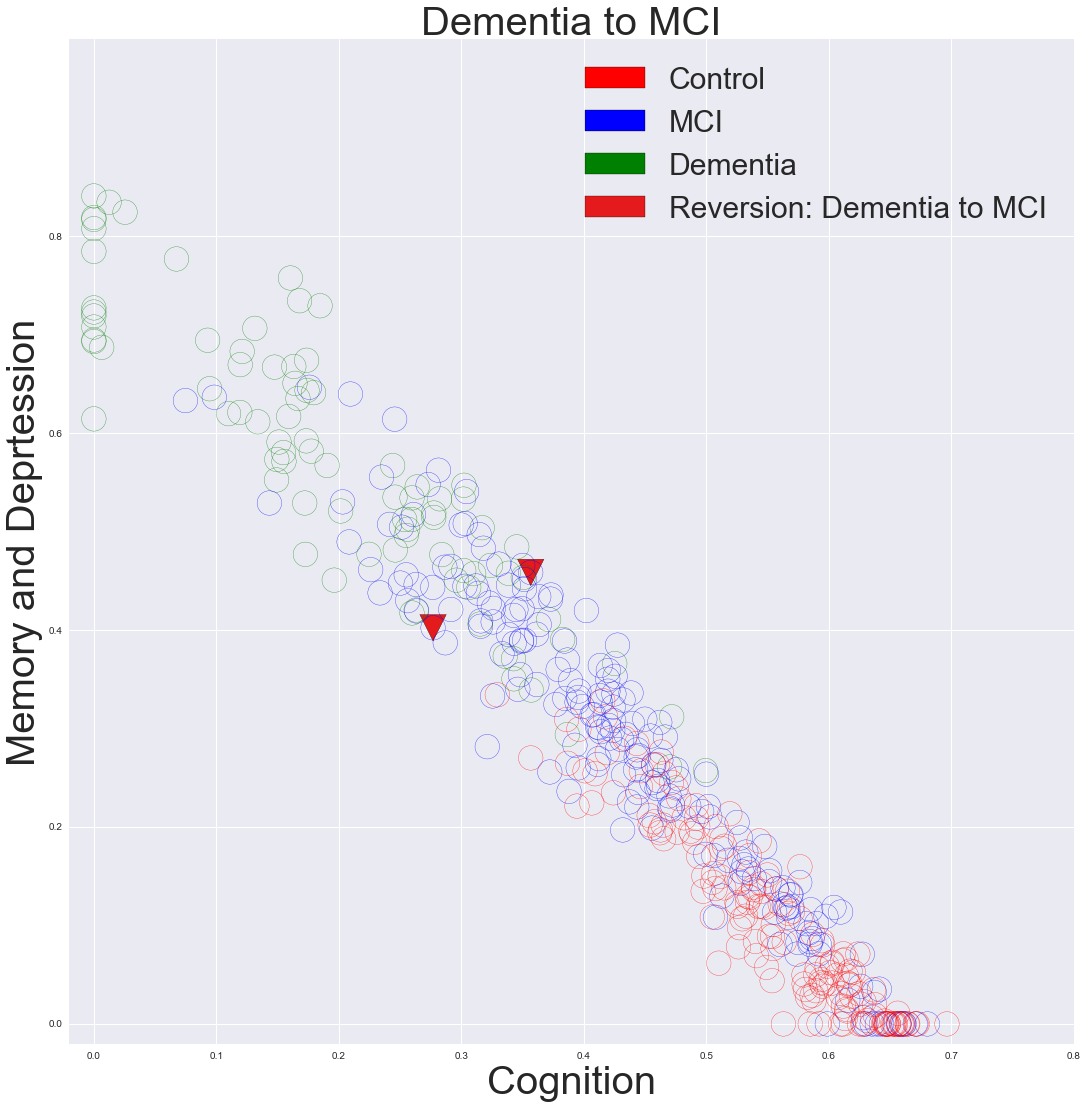

In [75]:
projections(redued_item_24,colors_categories_item_24, colors_categories_item_CN_MCI_DMN \
            ,list_of_colors,list_prog,list_replace, 'Dementia to MCI')



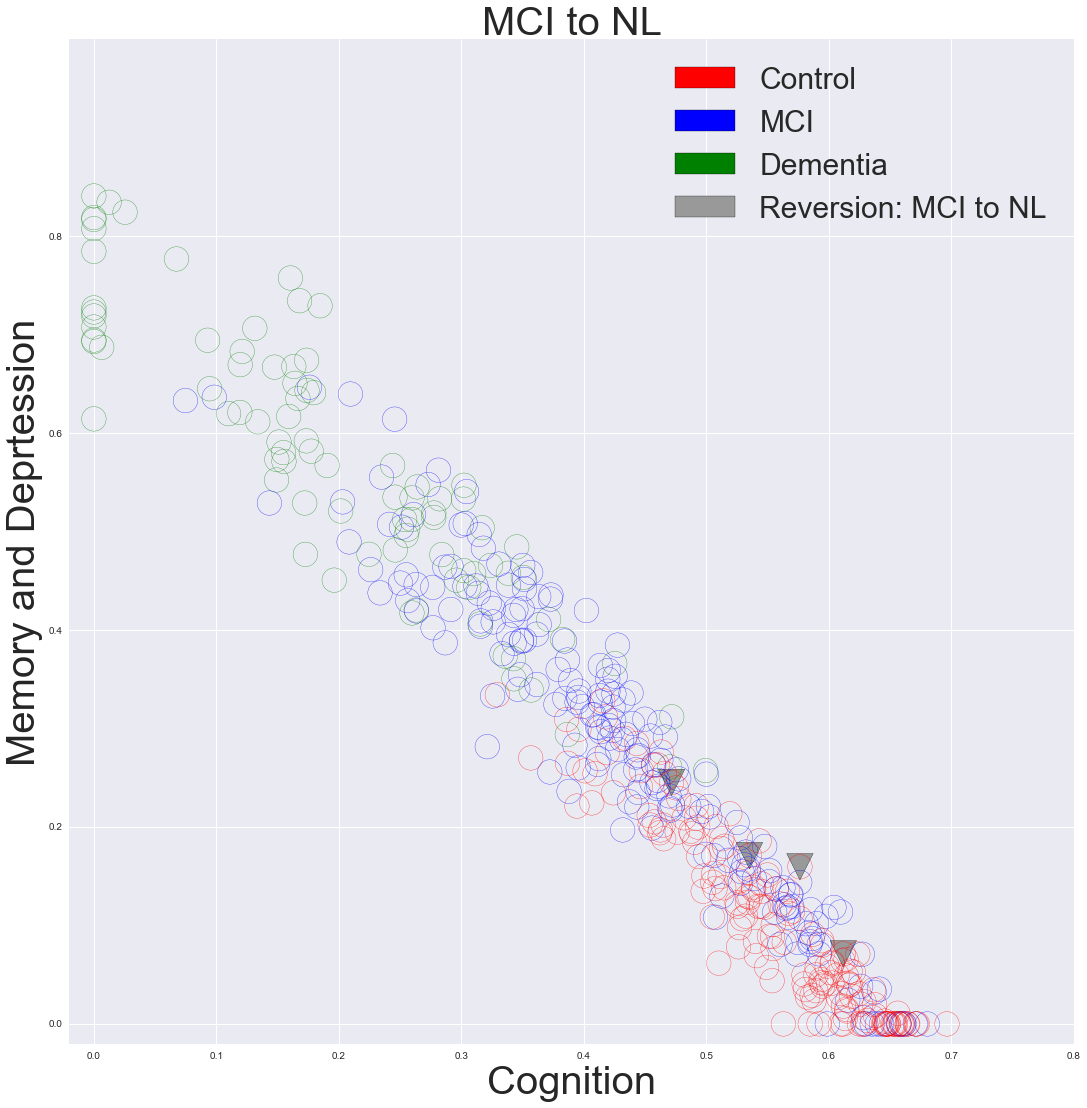

In [76]:
projections(redued_item_24,colors_categories_item_24, colors_categories_item_CN_MCI_DMN \
            ,list_of_colors,list_prog,list_replace, 'MCI to NL')



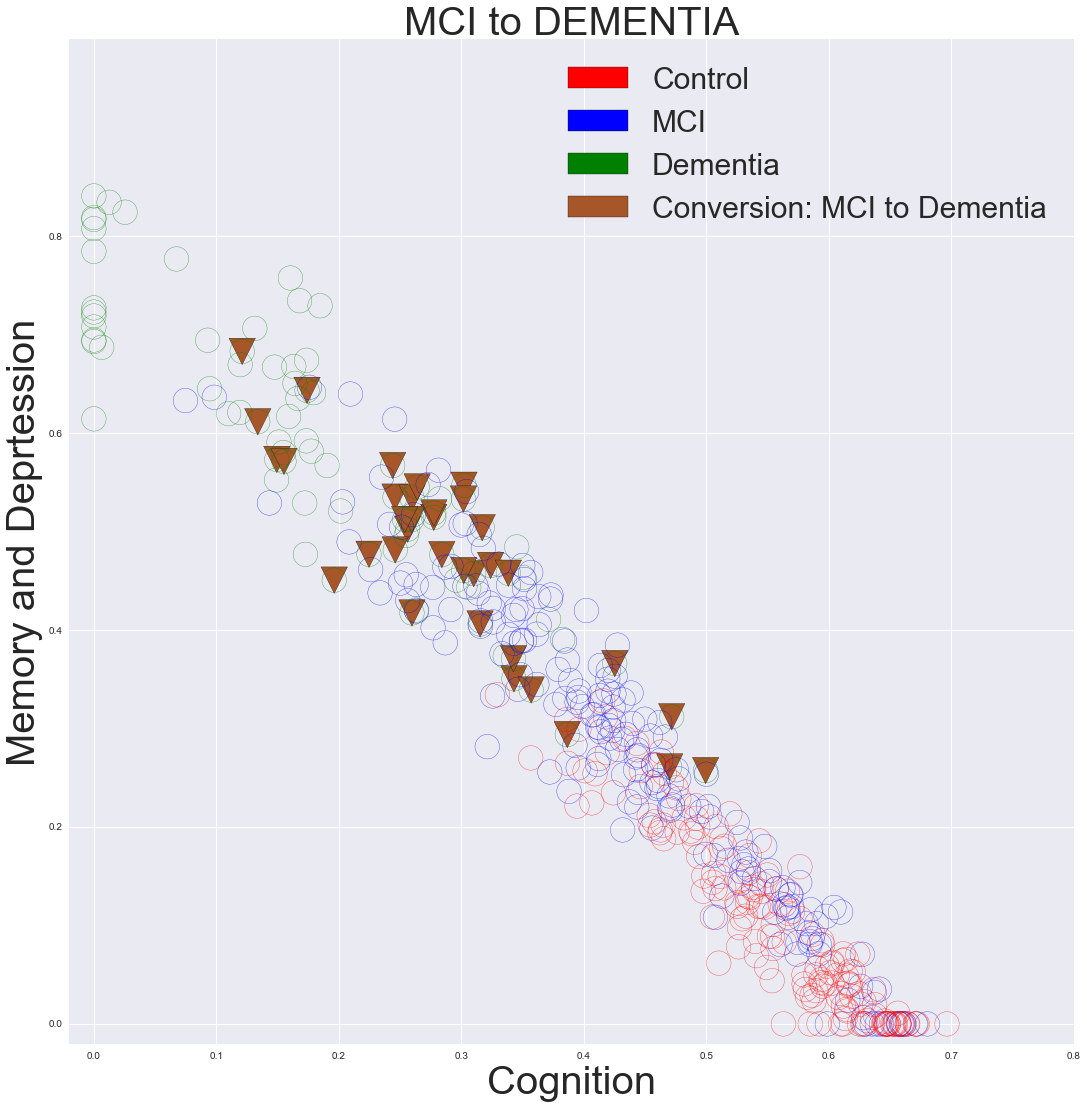

In [77]:
projections(redued_item_24,colors_categories_item_24, colors_categories_item_CN_MCI_DMN \
            ,list_of_colors,list_prog,list_replace, 'MCI to DEMENTIA')

In [114]:
def projections_two(redued,colors_categories, colors_categories_item_CN_MCI_DMN,list_of_colors, list_prog,list_replace):
    redued.merge(colors_categories.to_frame(), left_index=True, right_index=True)
        
    redued_1 = redued[ redued.DXCHANGE_2.isin([7,8])]
#        reduced_columns = list( reduced.columns)
#        reduced_columns = reduced_columns.remove(2)
    colors_categories = redued_1['DXCHANGE']
        
    fig = plt.figure(4, figsize=(18,18))
    ax1 = fig.add_subplot(111)
    ax1.scatter(redued_1[['NMF_2_1']], redued_1[['NMF_2_2']], c = redued_1['DXCHANGE'], s=700, marker='v')
    #plt.title('Reversion: MCI to NL and Reversion: Dementia to MCI')
    ax1.scatter(redued[['NMF_2_1']], redued[['NMF_2_2']], edgecolors = colors_categories_item_CN_MCI_DMN, s= 700,facecolors='none', alpha = 0.5)#,linewidth= 1.5)


    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'red')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'green')
    p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc= '#999999')
    p5 = plt.Rectangle((0, 0), 0.1, 0.1, fc= '#e41a1c')
    plt.legend((p1, p2, p3, p4,p5), ('Control', 'MCI','Dementia', 'MCI to Control','Dementia to MCI' ), loc='best', fontsize = 40);

    plt.xlim((-.02, 0.75))
    plt.ylim((-.02, 0.9)) 
    plt.xlabel('Cognitive decline', fontsize = 40)
    plt.ylabel('Memory decline', fontsize = 40)
    plt.grid(True)
    plt.savefig(address + 'Figure4.png',dpi = 200)
    plt.show()

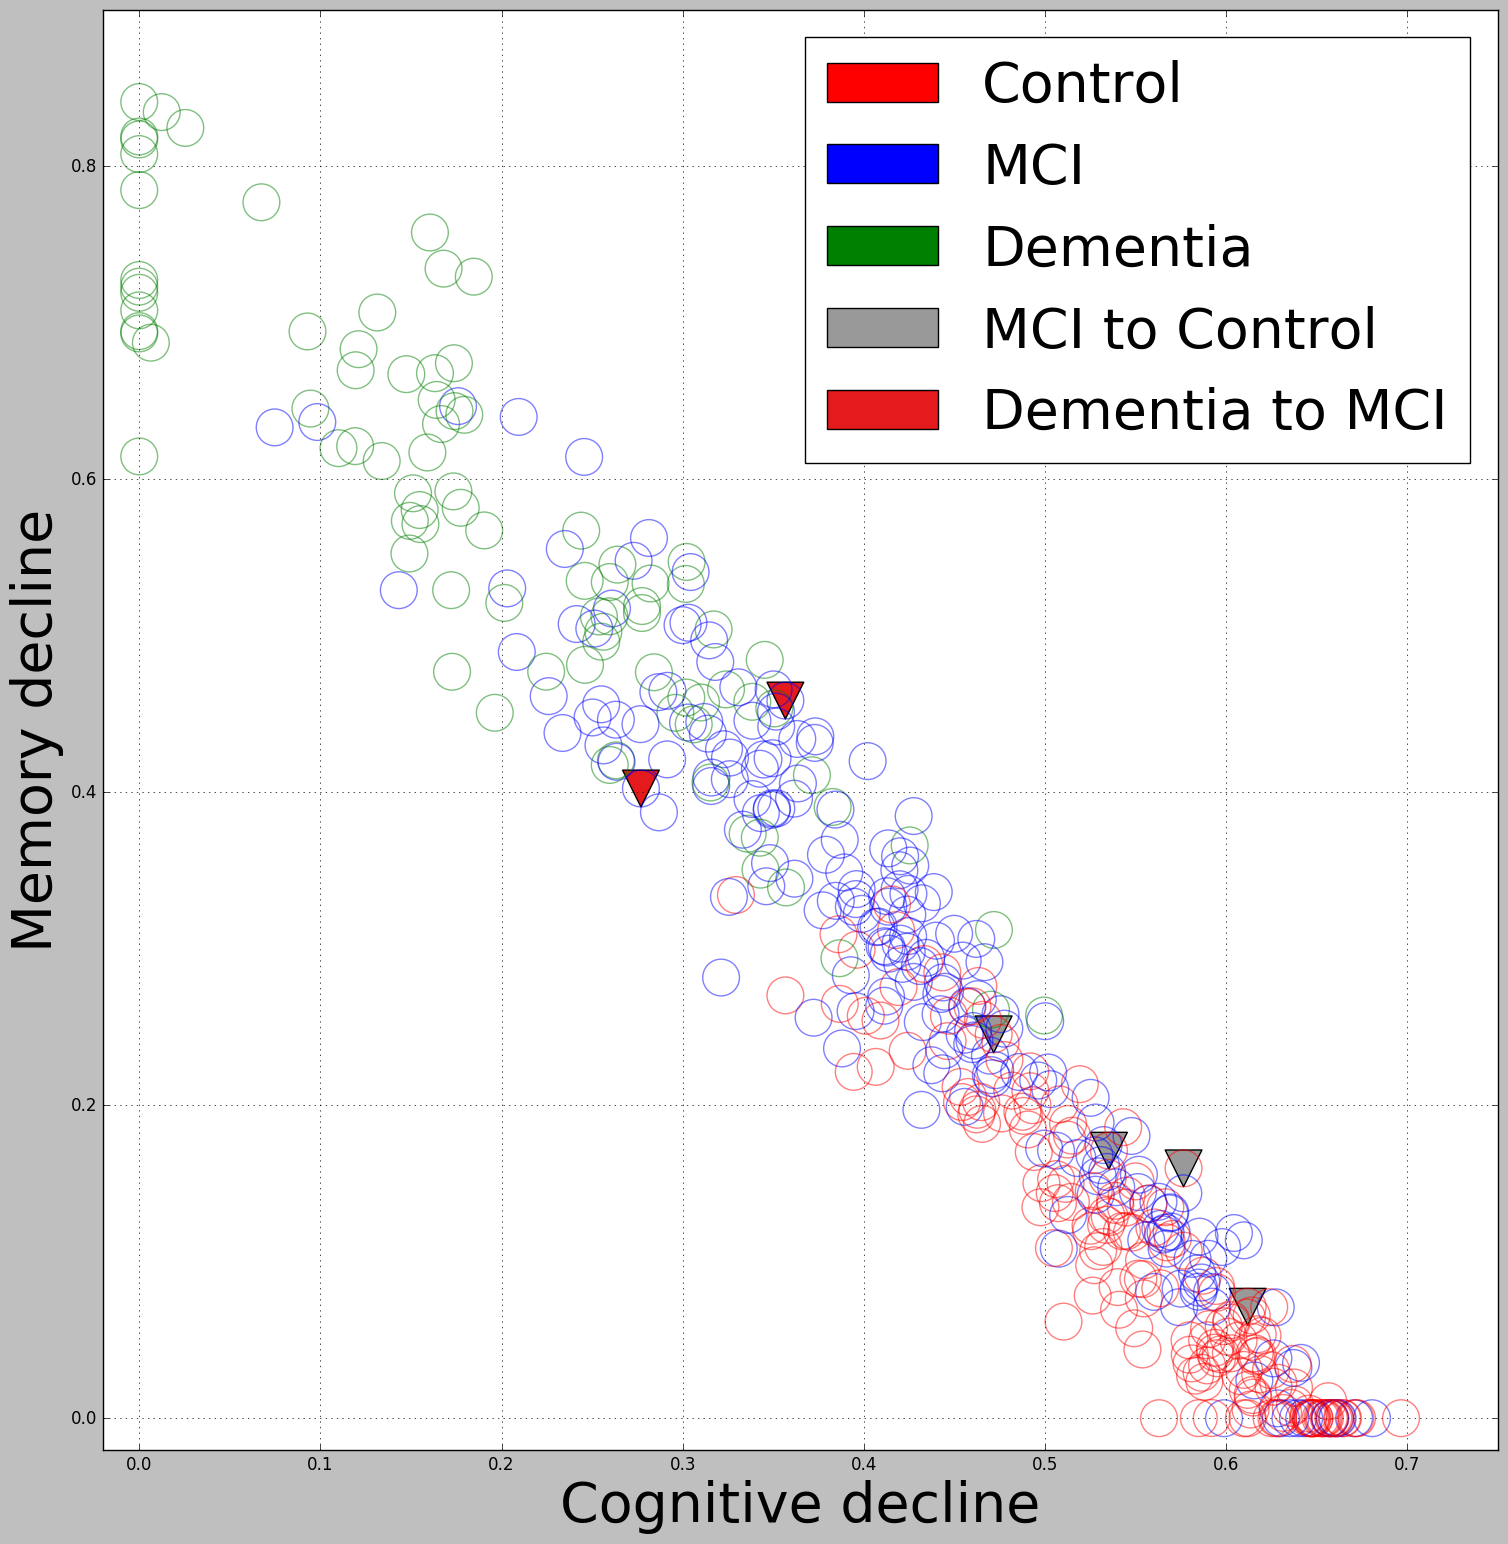

In [115]:
projections_two(redued_item_24,colors_categories_item_24, colors_categories_item_CN_MCI_DMN \
            ,list_of_colors,list_prog,list_replace)

In [116]:
def projections_reversion(redued,colors_categories,list_of_colors):
    redued.merge(colors_categories.to_frame(), left_index=True, right_index=True)
    plt.figure(4, figsize=(18,24))
    plt.scatter(redued[['NMF_2_1']], redued[['NMF_2_2']], c =  redued['DXCHANGE'], s=120)
    plt.title('NMF')

    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= list_of_colors[0])
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc= list_of_colors[1])
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc= list_of_colors[2])
    p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc= list_of_colors[3])
    p5 = plt.Rectangle((0, 0), 0.1, 0.1, fc= list_of_colors[4])
    p6 = plt.Rectangle((0, 0), 0.1, 0.1, fc= list_of_colors[5])
    p7 = plt.Rectangle((0, 0), 0.1, 0.1, fc= list_of_colors[6])
    p8 = plt.Rectangle((0, 0), 0.1, 0.1, fc= list_of_colors[7])
    p9 = plt.Rectangle((0, 0), 0.1, 0.1, fc=list_of_colors[8])
    p10 = plt.Rectangle((0, 0), 0.1, 0.1, fc= list_of_colors[9])
    p11 = plt.Rectangle((0, 0), 0.1, 0.1, fc= list_of_colors[10])
    plt.legend((p1, p2, p3, p4, p5, p6, p7,p8,p9,p10,p11), ('Stable: NL to NL', 'Stable: NL','Stable: MCI','Stable: MCI to MCI','Stable: Dementia', 'Stable: Dementia to Dementia','Conversion: NL to MCI','Conversion: MCI to Dementia','Conversion: NL to Dementia','Reversion: MCI to NL', 'Reversion: Dementia to MCI'), loc='best');

    plt.xlim((-.02, 0.8))
    plt.ylim((-.02, 1.0)) 
    plt.xlabel('Cognition', fontsize = 18)
    plt.ylabel('Memory and Deprtession', fontsize = 18)
    plt.title('NMF')
    plt.grid(True)
    plt.savefig(address + 'nmf_prog.png',dpi = 200)
    plt.show()



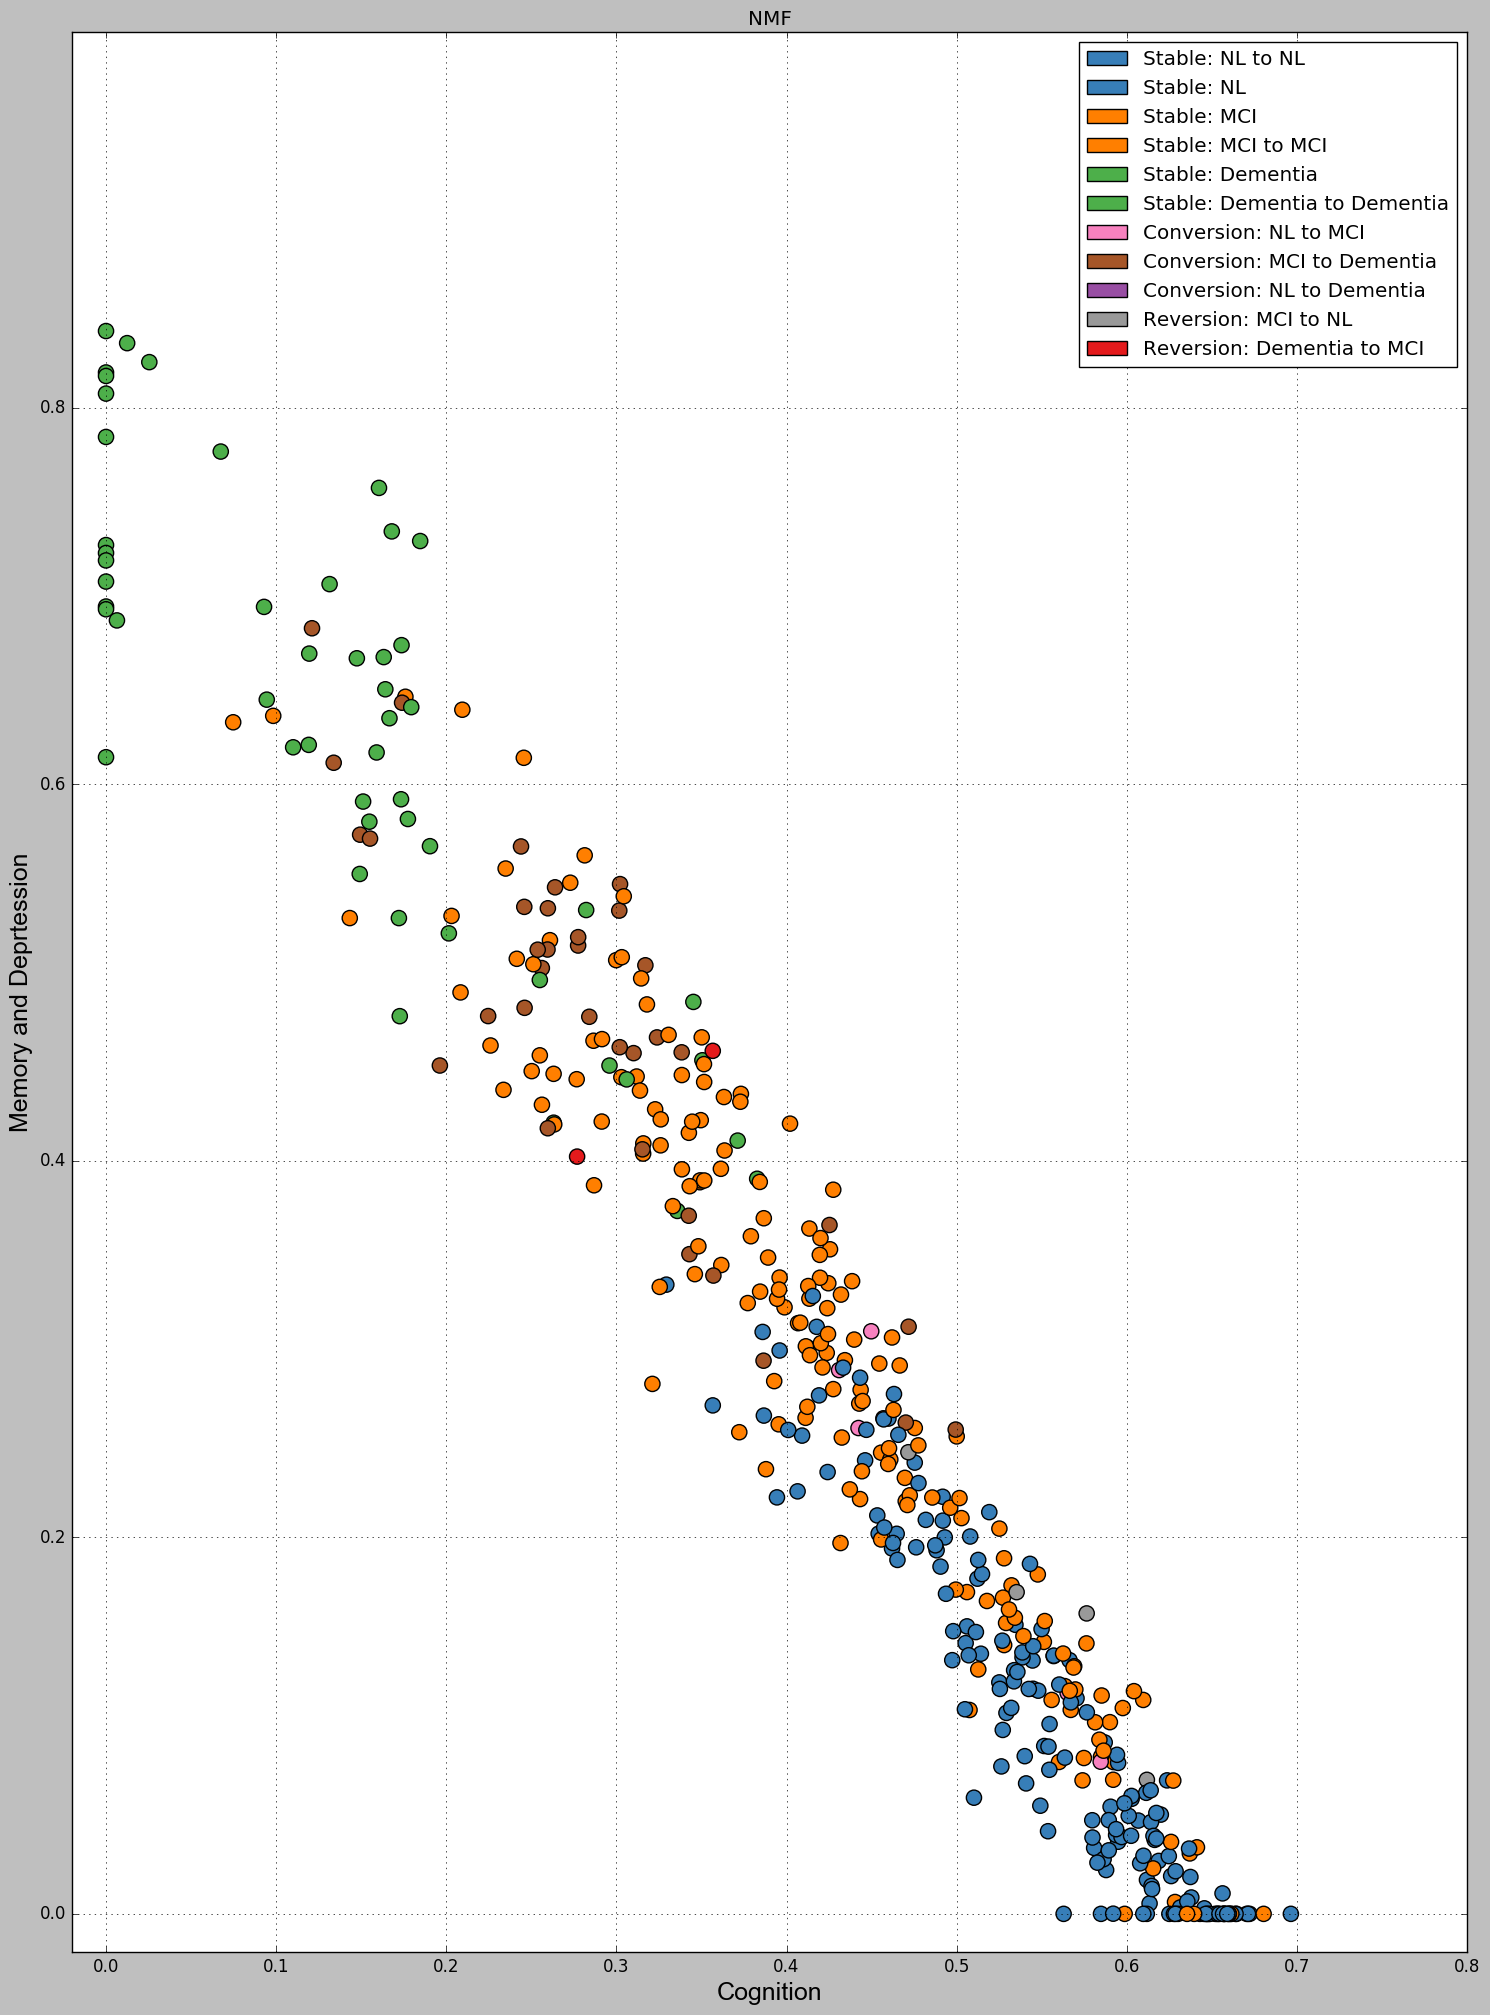

In [117]:
projections_reversion(redued_item_24,colors_categories_item_24,list_of_colors)

In [121]:
def projections_CN_MCI_DMN(redued,colors_categories,list_of_colors):
    
    plt.figure(4, figsize=(18,18))
    
    plt.scatter(redued[['NMF_2_1']], redued[['NMF_2_2']], c = colors_categories, s=700, alpha = 0.5)


    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= list_of_colors[0])
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc= list_of_colors[1])
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc= list_of_colors[2])
    
    plt.legend((p1, p2, p3), ('Control', 'MCI','Dementia',), loc='best', fontsize = 40);


    #plt.title('Projection Space')
    plt.grid(True)
    plt.xlim((-.02, 0.75))
    plt.ylim((-.02, 0.9)) 
    plt.xlabel('Cognitive decline', fontsize = 40)
    plt.ylabel('Memory decline', fontsize = 40)
    plt.savefig(address + 'Figure1.png',dpi = 200)
    plt.show()

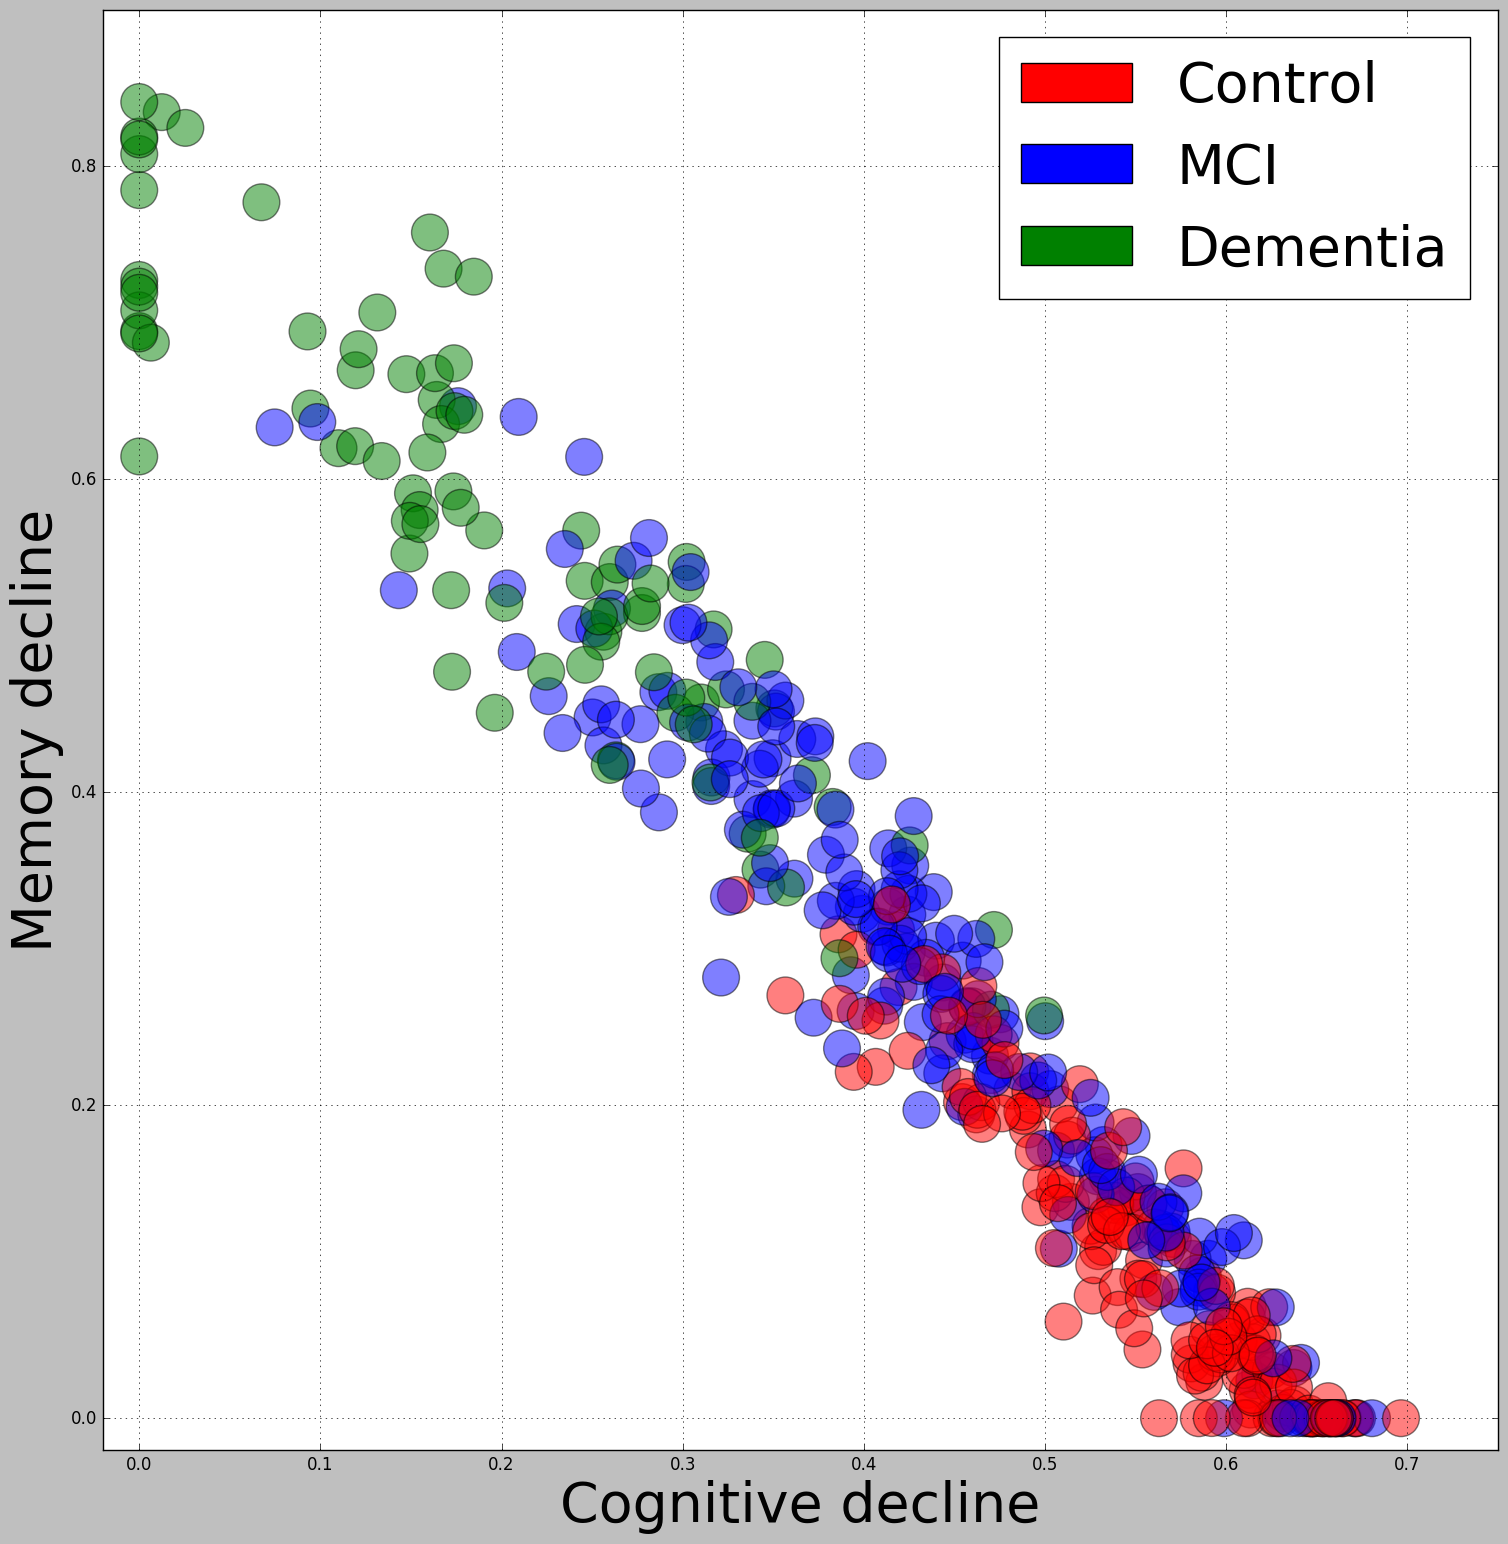

In [122]:
projections_CN_MCI_DMN(redued_item_CN_MCI_DMN,colors_categories_item_CN_MCI_DMN,list_of_colors_CN_MCI_DMN)

## APOE$

In [120]:

import matplotlib.lines as mlines
import matplotlib.pyplot as plt


In [70]:
redued = redued_item_24
cols['apoe4'] = ['RID' , 'VISCODE' , 'APOE4'   ]
apoe4 = pd.read_csv("C:\\Users\\Vipul Satone\\health data\\ADNI\\Raw_Data\\Assessment\\apoe4\\ADNIMERGE.csv",index_col='RID', usecols=cols['apoe4'])

apoe4['VISCODE2'] = apoe4['VISCODE']
apoe4['VISCODE'].value_counts()
del apoe4['VISCODE']
apoe4 = apoe4[apoe4['VISCODE2'].isin(['m24']) ]  

In [71]:
# def plot_apoe4(redued, apoe4):
#     redued = redued.merge(apoe4['APOE4'].to_frame(), left_index=True, right_index=True)
#     mlp.rc('font', size= 18)
#     mlp.rc('axes', titlesize= 18)
#     f9 = plt.figure(figsize=(20,10))
#     #f9.suptitle("Alzheimer's Progression Space at 24th month\n (Using 12 month of data)", fontsize = 18)
#     cm = plt.cm.get_cmap('RdYlBu')
#     colors =    np.array(  redued['APOE4']      )
#     plot = plt.scatter(redued[['NMF_2_1']], redued[['NMF_2_2']], alpha=0.5, c = colors, s = 100, cmap = cm)
#     plt.xlabel('Cognition', fontsize = 18)
#     plt.ylabel('Memory and Depression', fontsize = 18)
#     plt.title(" Projection of Apoe4 ", fontsize = 18)
#     plt.colorbar(plot)
#     plt.show()

In [72]:
def plot_apoe4(redued1, apoe4,a,list_final):
    redued = redued1.merge(apoe4['APOE4'].to_frame(), left_index=True, right_index=True)
    if isinstance(a, int):
        redued = redued[redued['APOE4']  == a]  
    else:
        redued = redued
    redued = redued[ redued['DXCHANGE_2'].isin(list_final)  ]
    redued['APOE4_original'] = redued['APOE4']
    redued['APOE4'] = redued['APOE4'].replace([0,1,2],[ '#377eb8', '#ff7f00', '#4daf4a'])
    f9 = plt.figure(figsize=(20,10))
    f9.suptitle("Projection of Baseline Dignosis \n (Using 12 month of data)", fontsize = 18)
    plot = plt.scatter(redued[['NMF_2_1']], redued[['NMF_2_2']], alpha=0.5, c = redued['APOE4'], s = 100 )
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= '#377eb8')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc= '#ff7f00')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc= '#4daf4a')
#     p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc= '#f781bf')
#     p5 = plt.Rectangle((0, 0), 0.1, 0.1, fc= '#a65628')
#     p6 = plt.Rectangle((0, 0), 0.1, 0.1, fc= '#984ea3')
    plt.legend((p1, p2, p3), ('0 APOE4 Present','1 APOE4 Present' , '2 APOE4 Present' ), loc='best');
    plt.grid(True)
    plt.xlim((-.02, 0.8))
    plt.ylim((-.02, 1.0)) 
    plt.show()

In [73]:
NL = [1,7]
MCI = [2,4,8]
AD = [5,6,3]

ALL = [1,2,3,4,5,6,7,8]

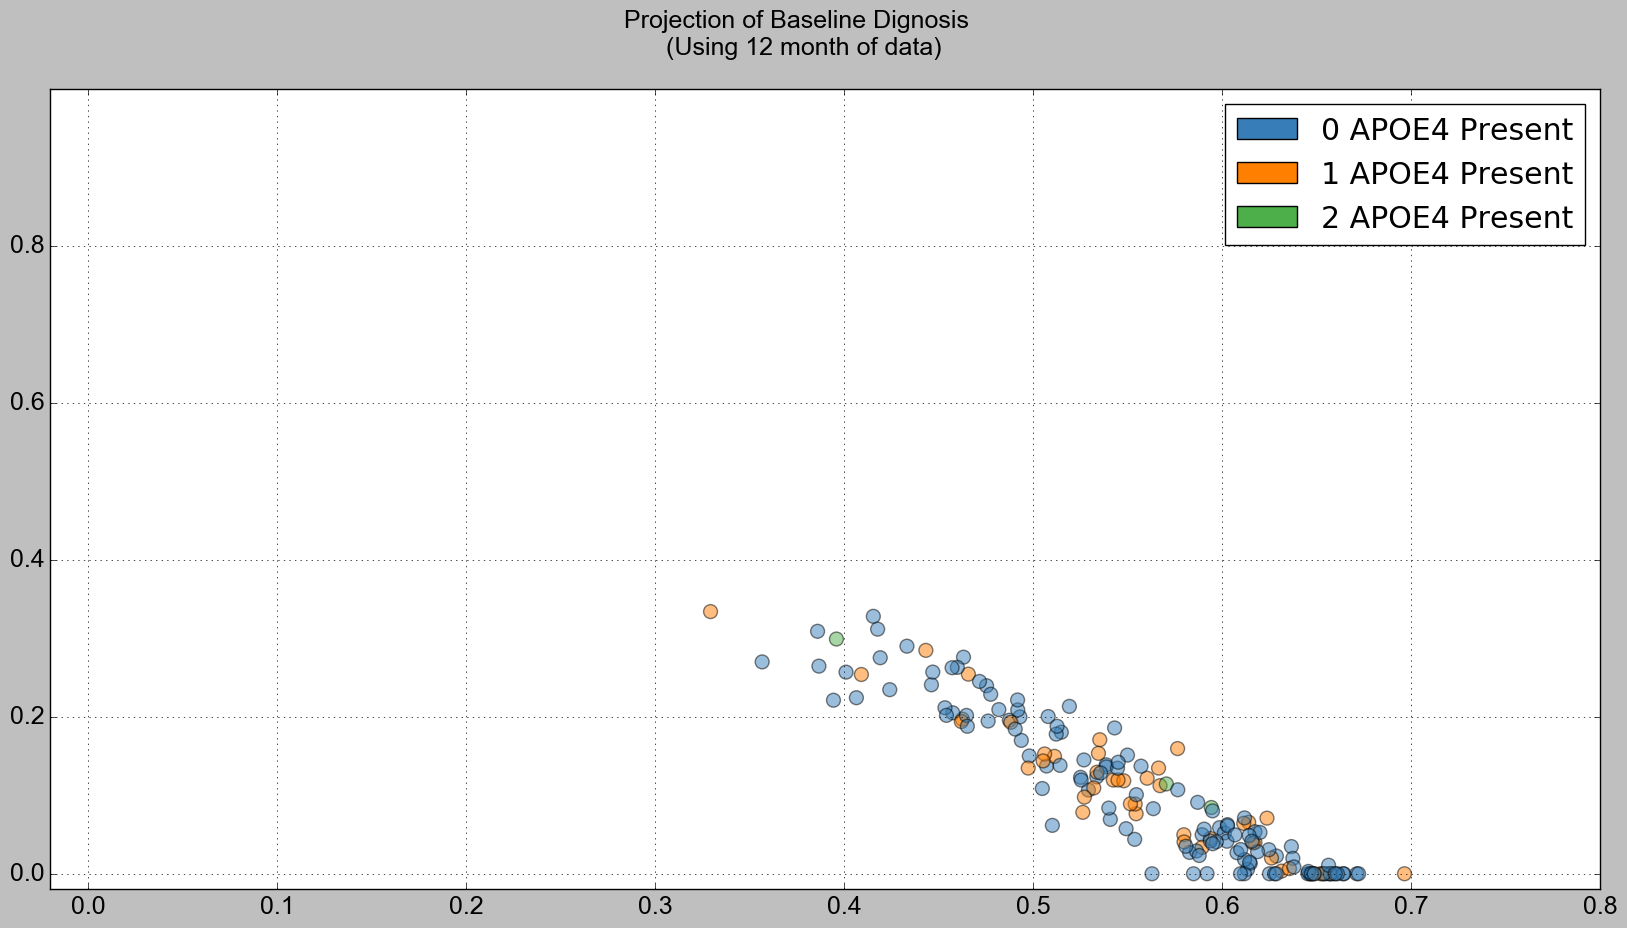

In [74]:
plot_apoe4(redued, apoe4,'all',NL)

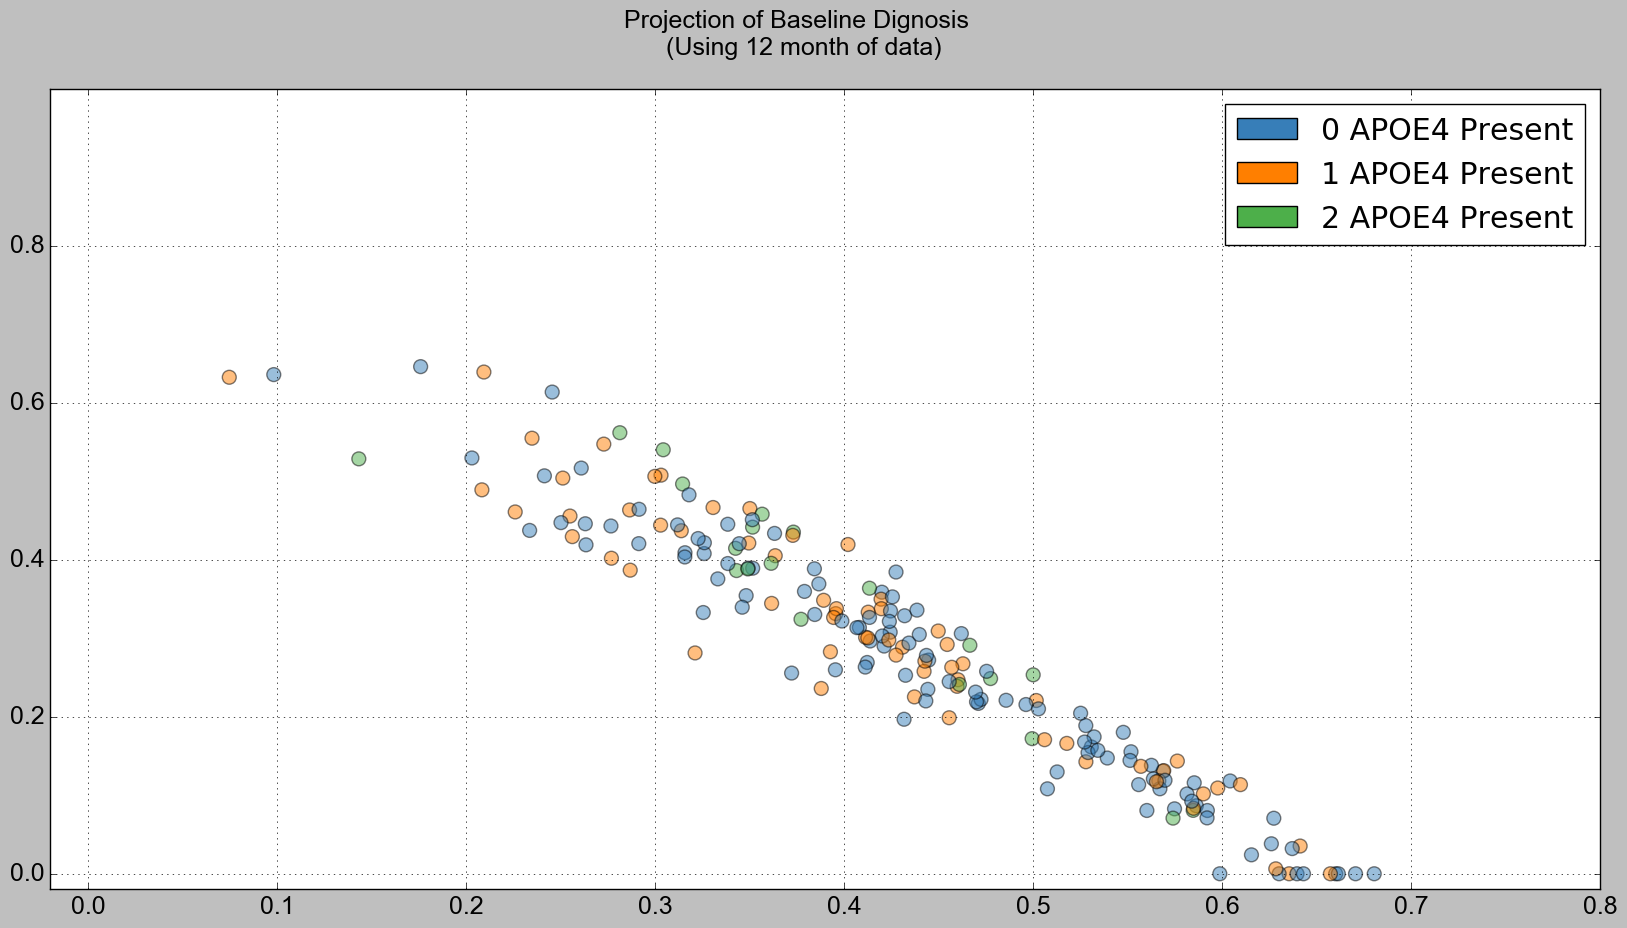

In [75]:
plot_apoe4(redued, apoe4,'all',MCI)

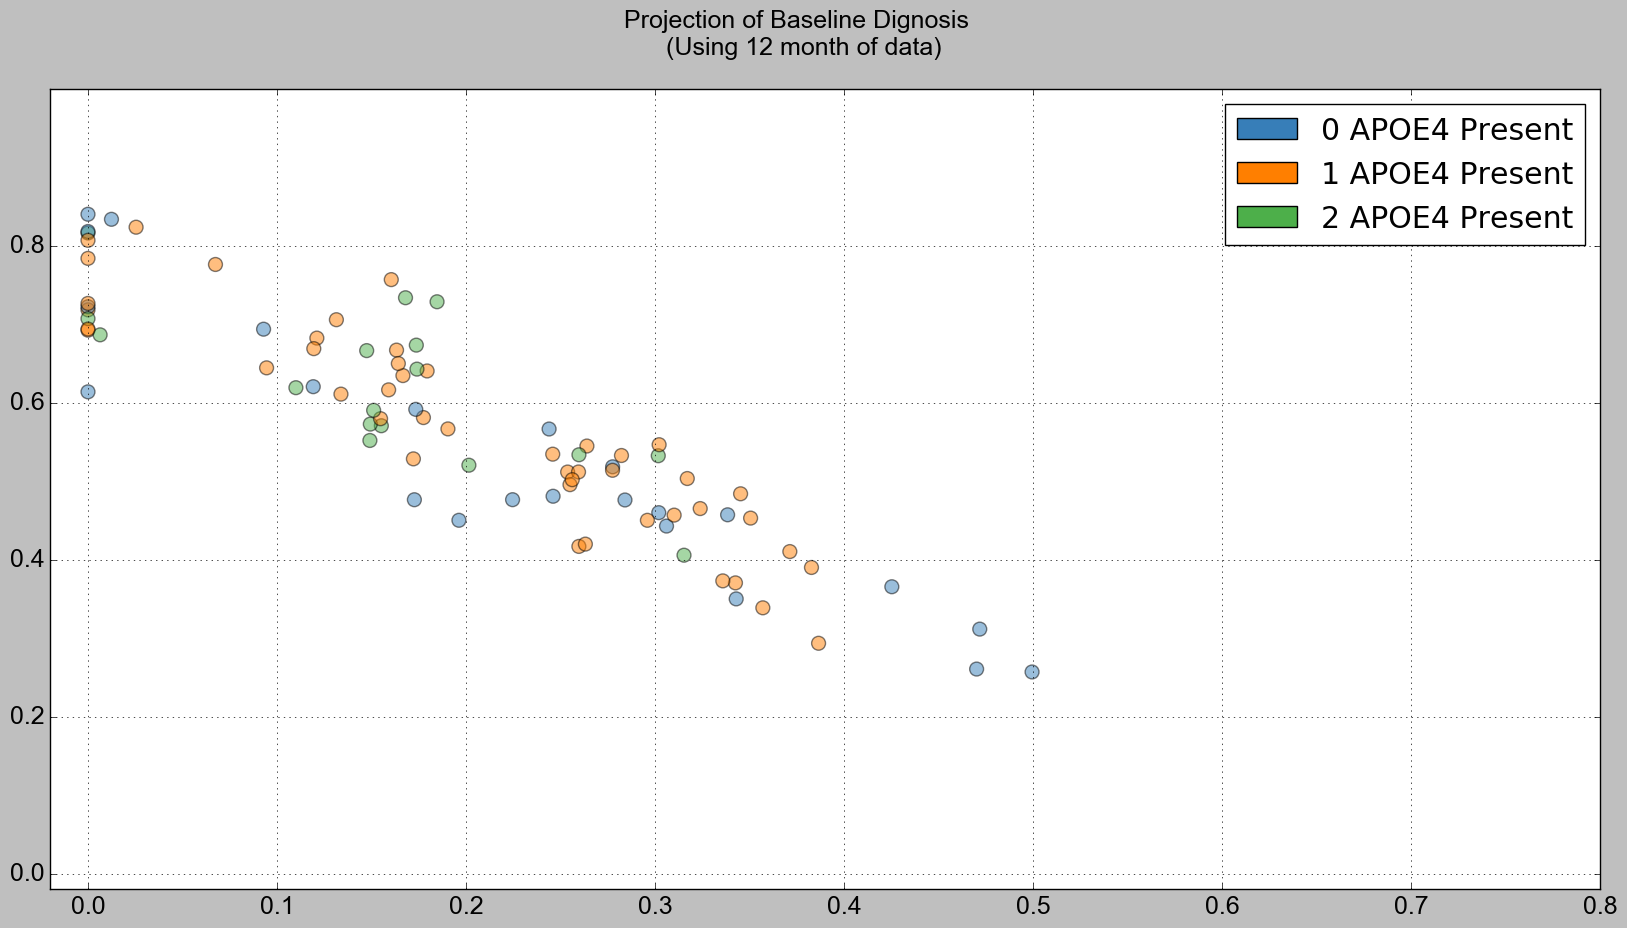

In [76]:
plot_apoe4(redued, apoe4,'all',AD)

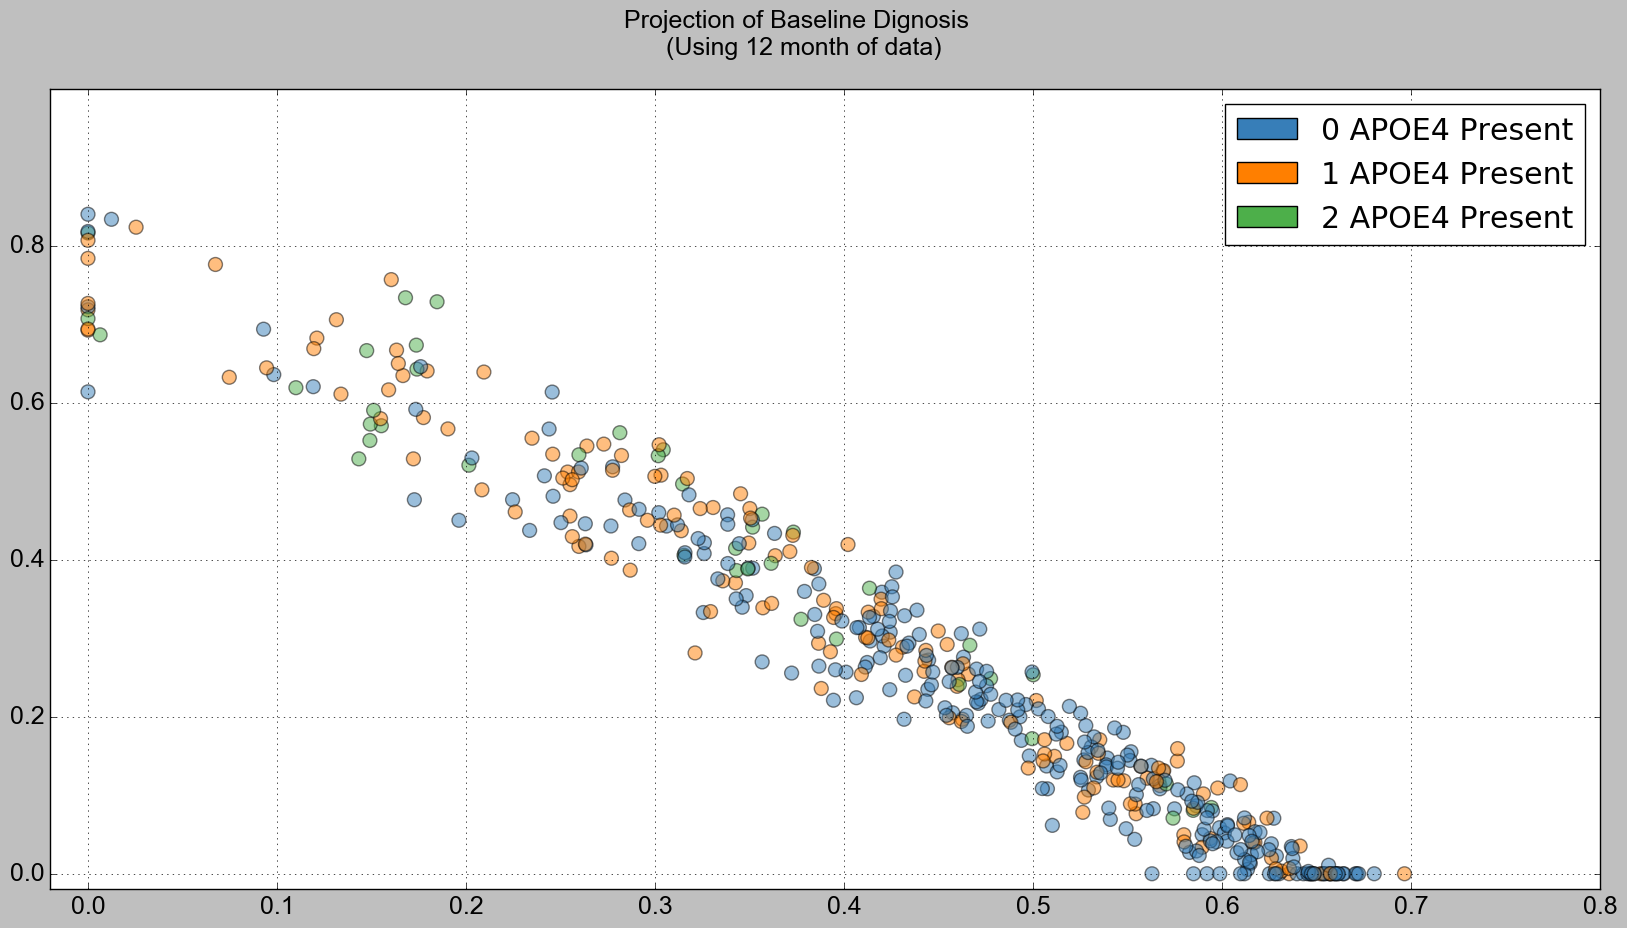

In [77]:
plot_apoe4(redued, apoe4,'all',ALL)

In [78]:
def plot_apoe4(redued1, apoe4,a,list_final):
    redued = redued1.merge(apoe4['APOE4'].to_frame(), left_index=True, right_index=True)
    redued_0 = redued[redued['APOE4']  == 0]  
    redued_1 = redued[redued['APOE4']  == 1]  
    redued_2 = redued[redued['APOE4']  == 2]  
    
    redued_0 = redued_0[ redued_0['DXCHANGE_2'].isin(list_final)  ]
    redued_1 = redued_1[ redued_1['DXCHANGE_2'].isin(list_final)  ]
    redued_2 = redued_2[ redued_2['DXCHANGE_2'].isin(list_final)  ]
    
    redued_0['APOE4_original'] = redued_0['APOE4']
    redued_1['APOE4_original'] = redued_1['APOE4']
    redued_2['APOE4_original'] = redued_2['APOE4']
    
    redued_0['APOE4'] = redued_0['APOE4'].replace([0,1,2],[ '#377eb8', '#ff7f00', '#4daf4a'])
    redued_1['APOE4'] = redued_1['APOE4'].replace([0,1,2],[ '#377eb8', '#ff7f00', '#4daf4a'])
    redued_2['APOE4'] = redued_2['APOE4'].replace([0,1,2],[ '#377eb8', '#ff7f00', '#4daf4a'])

    f9 = plt.figure(figsize=(18,18))
    #f9.suptitle("APOE4 Projection on Projecton space", fontsize = 18)
    plot = plt.scatter(redued_0[['NMF_2_1']], redued_0[['NMF_2_2']], alpha=0.25, c = redued_0['APOE4'], s = 700)
    plot = plt.scatter(redued_1[['NMF_2_1']], redued_1[['NMF_2_2']], alpha=0.25, c = redued_1['APOE4'], s = 700)
    plot = plt.scatter(redued_2[['NMF_2_1']], redued_2[['NMF_2_2']], alpha=1, c = redued_2['APOE4'], s = 700)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= '#377eb8')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc= '#ff7f00')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc= '#4daf4a')
#     p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc= '#f781bf')
#     p5 = plt.Rectangle((0, 0), 0.1, 0.1, fc= '#a65628')
#     p6 = plt.Rectangle((0, 0), 0.1, 0.1, fc= '#984ea3')
    plt.legend((p1, p2, p3), ('0 APOE4 Present','1 APOE4 Present' , '2 APOE4 Present' ), loc='best', fontsize = 40);
    plt.xlim((-.02, 0.75))
    plt.ylim((-.02, 0.9)) 
    plt.xlabel('Cognition', fontsize = 40)
    plt.ylabel('Memory', fontsize = 40)
    plt.grid(True)
    plt.savefig(address + 'Figure5.png',dpi = 200)
    plt.show()

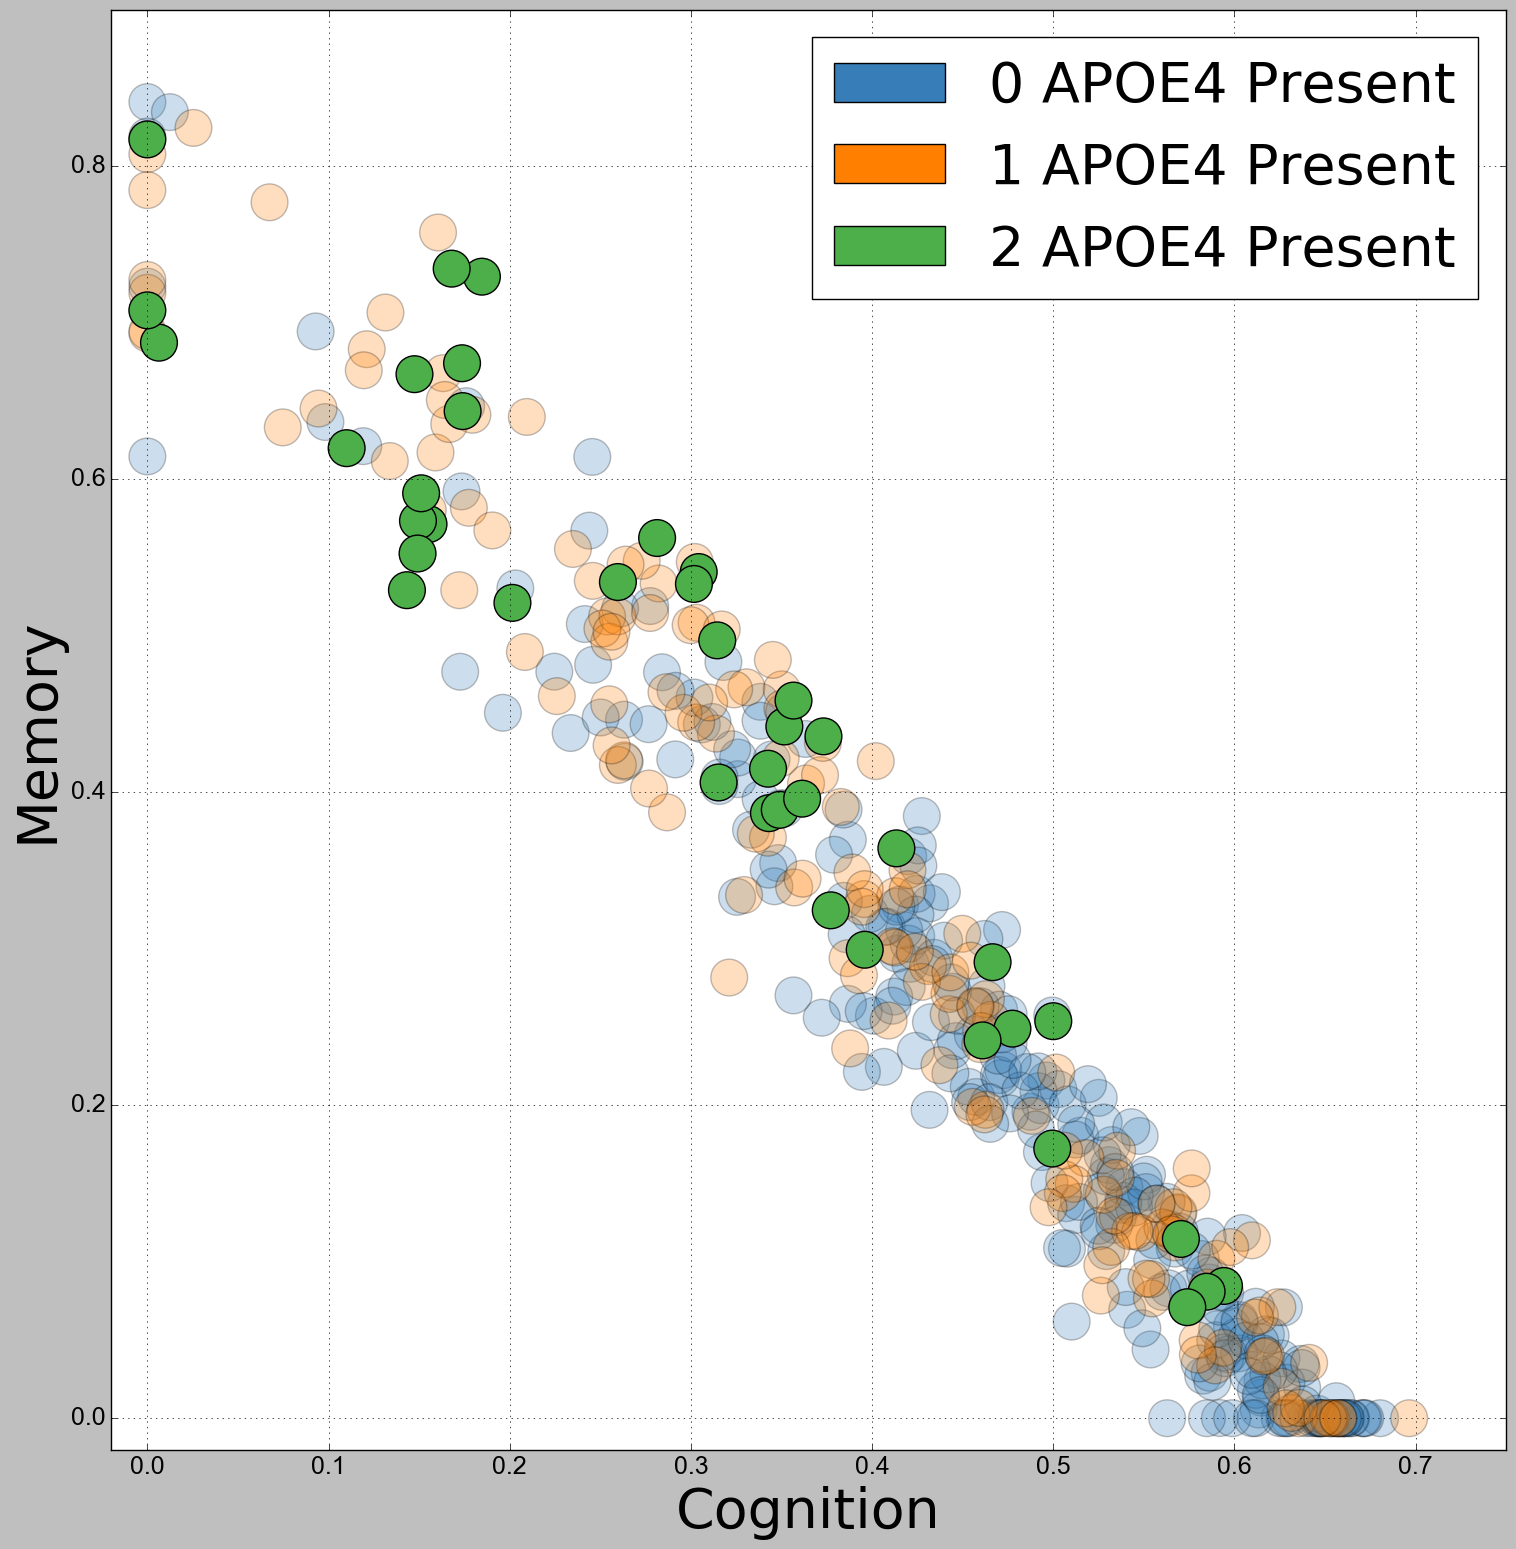

In [79]:
plot_apoe4(redued, apoe4,'all',ALL)

### basline vs future

In [80]:


cols['DX_bl'] = ['RID' , 'VISCODE' , 'DX_bl'   ]
baseline_dig = pd.read_csv("C:\\Users\\Vipul Satone\\health data\\ADNI\\Raw_Data\\Assessment\\apoe4\\ADNIMERGE.csv",index_col='RID', usecols=cols['DX_bl'])

baseline_dig['VISCODE2'] = baseline_dig['VISCODE']
baseline_dig['VISCODE'].value_counts()
del baseline_dig['VISCODE']
baseline_dig['DX_bl'].value_counts()
baseline_dig = baseline_dig[baseline_dig['VISCODE2'].isin(['m24']) ]  

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
def plot_baseline_comparison(redued1, baseline_dig,quant):
    
    if quant == 'all':
        redued = redued1.merge(baseline_dig['DX_bl'].to_frame(), left_index=True, right_index=True)
        redued['DX_bl_original'] = redued['DX_bl']
        redued['DX_bl'] = redued['DX_bl'].replace(['LMCI','CN','EMCI','AD','SMC','MCI'],[ '#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3' ])
        f9 = plt.figure(figsize=(20,10))
        f9.suptitle("Projection of Baseline Dignosis \n (Using 12 month of data)", fontsize = 18)
        plot = plt.scatter(redued[['NMF_2_1']], redued[['NMF_2_2']], alpha=0.5, c = redued['DX_bl'], s = 100 )
        p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= '#377eb8')
        p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc= '#ff7f00')
        p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc= '#4daf4a')
        p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc= '#f781bf')
        p5 = plt.Rectangle((0, 0), 0.1, 0.1, fc= '#a65628')
        p6 = plt.Rectangle((0, 0), 0.1, 0.1, fc= '#984ea3')
        plt.legend((p1, p2, p3, p4,p5,p6), ('LMCI','CN','EMCI','AD','SMC','MCI' ), loc='best');
    
    else:
        
        
        redued = redued1.merge(baseline_dig['DX_bl'].to_frame(), left_index=True, right_index=True)
        redued = redued[ ~( redued['DX_bl'].isin(['SMC']) )]
        redued['DX_bl_original'] = redued['DX_bl']
        redued['DXCHANGE_original'] = redued['DXCHANGE_original'].replace(['Stable: NL to NL', 'Stable: NL','Stable: MCI','Stable: MCI to MCI','Stable: Dementia', 'Stable: Dementia to Dementia','Conversion: NL to MCI','Conversion: MCI to Dementia','Conversion: NL to Dementia','Reversion: MCI to NL','Reversion: Dementia to MCI'],['CN','CN','MCI','MCI','AD','AD','MCI','AD','AD','CN','MCI'])
        redued['DX_bl_original'] = redued['DX_bl_original'].replace(['LMCI','EMCI'],['MCI','MCI'])
        redued = redued[ ~ ( redued['DX_bl_original'] == redued['DXCHANGE_original'] )    ]
        redued['DXCHANGE_original'] = redued['DXCHANGE_original'].replace(['CN','MCI','AD'],['red','blue','green'])
        #redued['DX_bl'] = redued['DX_bl'].replace(['LMCI','CN','EMCI','AD','SMC','MCI'],[ '#377eb8', '#ff7f00', '#377eb8','#f781bf', '#a65628', '#377eb8' ])
        redued['DX_bl_original'] = redued['DX_bl_original'].replace(['CN','MCI','AD'],[  'red',  'blue','green' ])
        f9 = plt.figure(figsize=(20,10))
        f9.suptitle("Projection of Baseline Dignosis \n (Using 12 month of data)", fontsize = 18)
        plot = plt.scatter(redued[['NMF_2_1']], redued[['NMF_2_2']], alpha=0.5, c = redued['DX_bl_original'], s = 150, marker = '*')
        plot = plt.scatter(redued[['NMF_2_1']], redued[['NMF_2_2']]-0.0235, alpha=0.5, c = redued['DXCHANGE_original'], s = 150, marker = 'o' )
#         plot = plt.scatter(redued[['NMF_2_1']], redued[['NMF_2_2']], edgecolors = colors_categories_item_CN_MCI_DMN, s= 40,facecolors='none', alpha = 0.9)#,linewidth= 1.5)

#         p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'red')
#         p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'blue')
#         p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'green')
# #        p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'red')
# #        p5 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'blue')
# #        p6 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'green')
#         #plt.legend((p1, p2, p3,p4,p5,p6), ('CN - baseline','AD - baseline','MCI - baseline','CN - m24','MCI - m24','AD - m24' ), loc='best');    
#         plt.legend((p1, p2, p3), ('CN','MCI','AD'), loc='best');    
        
        red_star_bl = mlines.Line2D([], [], color='red', marker='*', linestyle='None',
                          markersize=10, label='Control - Baseline')
        blue_star_bl = mlines.Line2D([], [], color='blue', marker='*', linestyle='None',
                  markersize=10, label='MCI - Baseline')
        green_star_bl = mlines.Line2D([], [], color='green', marker='*', linestyle='None',\
                                  markersize=10, label='Dementia Baseline')
        red_circle_later = mlines.Line2D([], [], color='red', marker='o', linestyle='None',
                          markersize=10, label='Control - m24')
        blue_circle_later = mlines.Line2D([], [], color='blue', marker='o', linestyle='None',
                          markersize=10, label='MCI - m24')
        green_circle_later = mlines.Line2D([], [], color='green', marker='o', linestyle='None',
                          markersize=10, label='Dementia - m24')        
        
    plt.legend(handles=[red_star_bl, blue_star_bl, green_star_bl,red_circle_later ,blue_circle_later ,green_circle_later])
    plt.xlabel('Cognition', fontsize = 18)
    plt.ylabel('Memory and Depression', fontsize = 18)
    #plt.title(" Projection of Baseline Dignosis ", fontsize = 18)
    plt.show()

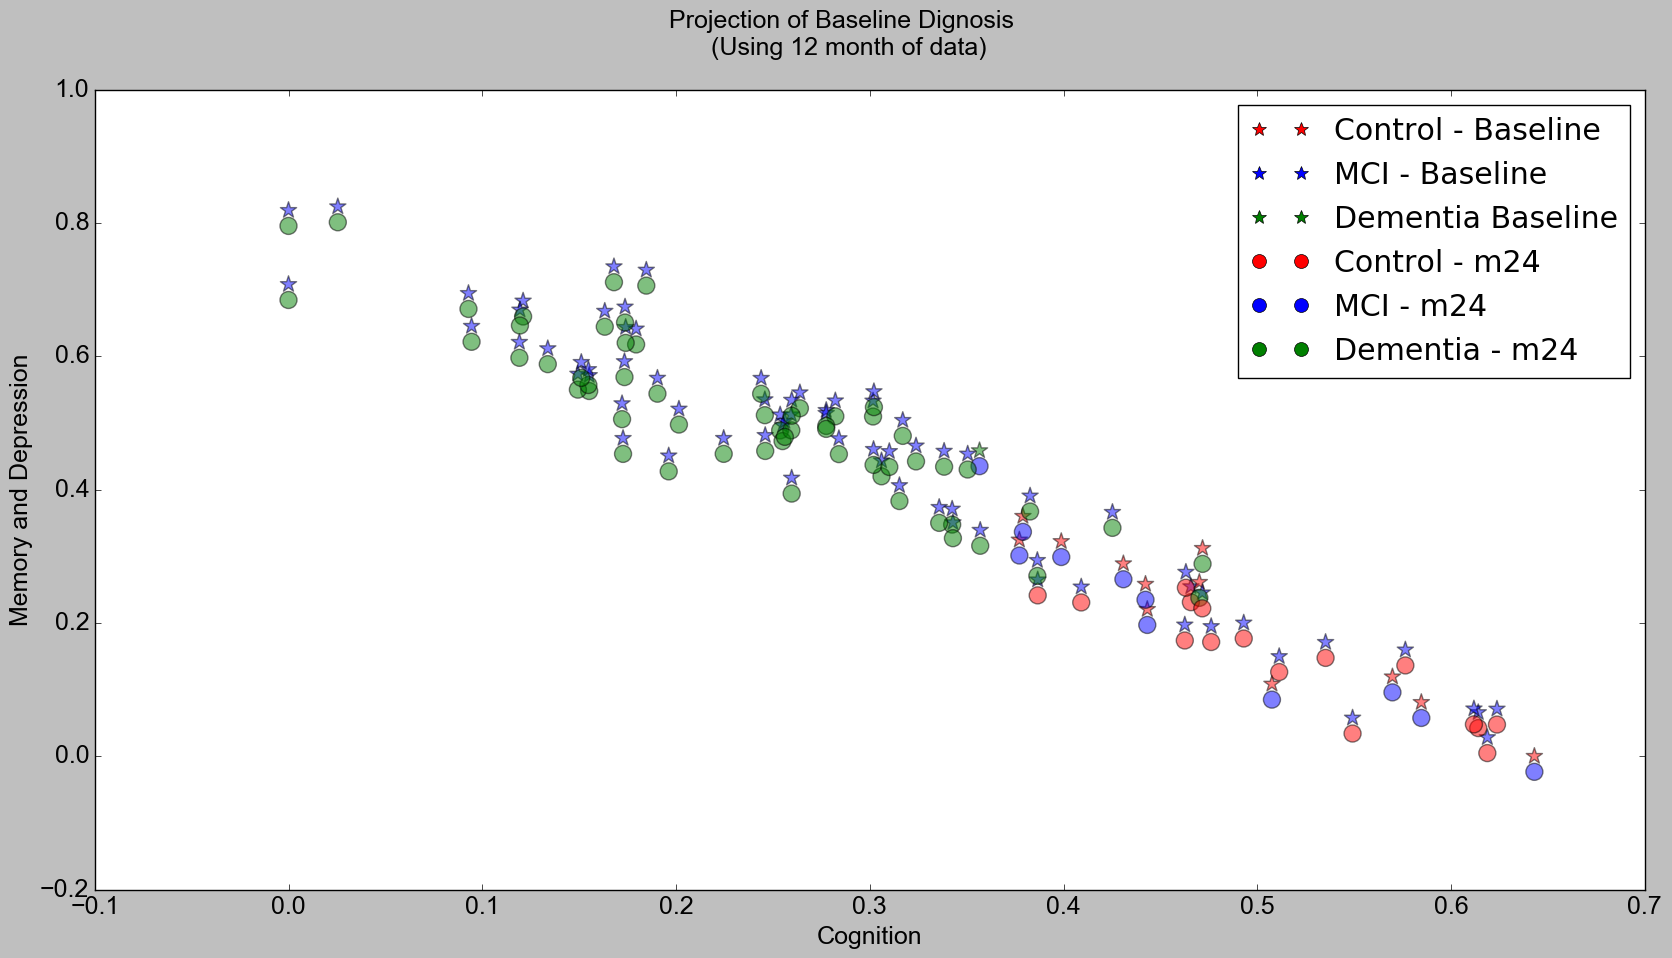

In [81]:
plot_baseline_comparison(redued_item_24, baseline_dig, 'no')

### We are not considering crane lab UW because it s memory score was developed using codnitive abilities as well

### they were more interested in developing functioning vs meory/codnition

# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3806057/

# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3684181/

# Binding of human apolipoprotein E to synthetic amyloid beta peptide: isoform-specific effects and implications for late-onset Alzheimer disease

In [82]:
#Plotting the labels information for all the patients - REPEATED RIDS'
diagnosis1 = pd.read_csv("ADNI\\Raw_Data\\Assessment\\DXSUM_PDXCONV_ADNIALL.csv",  usecols= ['RID','DXCHANGE','DXCURREN', 'DIAGNOSIS', 'VISCODE2'])
diagnosis1['Label_all'] = diagnosis1[['DXCHANGE', 'DXCURREN', 'DIAGNOSIS']].sum(skipna = True, numeric_only = True, axis = 1)
#Keeping only Labelled Non NULL values 
diagnosis1_label = diagnosis1[~diagnosis1['Label_all'].isnull()]
diagnosis1_label = diagnosis1_label.set_index('RID')

In [83]:
#These labels only exist for all ADNI
def label_plots(data, visit_code):
    dataset = eval(data)
    dataset= dataset[dataset['VISCODE2']==visit_code] #Plotting only for a particular visit code
    plt.figure(figsize = (20,6))
    sns.countplot(x = 'Label_all', data=dataset, palette="Greens_d");
    plt.xlabel('Labels ')
    plt.title('Labels ')
    plt.xticks(range(9), ('Stable: NL', 'Stable: MCI', 'Stable: Dementia', 'Conversion: NL to MCI', 'Conversion: MCI to Dementia', 'Conversion: NL to Dementia', 'Reversion: MCI to NL','Reversion: Dementia to MCI','Reversion: Dementia to NL'))
    plt.savefig('ADNI/Raw_Data/Demographic_Plots/Labels_'+str(data)+'_'+str(visit_code)+'.jpg')
    plt.show()

In [84]:
#Without true label discritization 
#Demographic Plots
adni_merge_chosen = adni_merge[adni_merge.index.isin(redued_item_24.index)] #CHANGE HERE FOR DIFFERENT DATASETS 

In [85]:
#Demographic Plots 
def plots(data):
    dataset = eval(data)
    mlp.rc('font', size= 24)
    mlp.rc('axes', titlesize= 24)
    '''
    #Plotting the VISCODE Distribution of all the patients 
    plt.figure(figsize = (15,10))
    sns.countplot(x='VISCODE', data=adni_merge, palette="Greens_d");
    plt.show()
    plt.savefig('ADNI/Raw_Data/Demographic_Plots/VISCODE_'+str(data)+'.jpg')
    '''
              
    #Plotting the COLPROT (Data Collection Protocol ) for all the patients  (Phase) 
    plt.figure(figsize = (12, 12))
    sns.countplot(x='COLPROT', data=dataset, palette="Greens_d");
    plt.xlabel('Data Collection Protocol', fontsize = 22)
    plt.title('Data Collection Protocol', fontsize = 22)
    plt.ylabel('Counts', fontsize = 22)
    plt.savefig(address + 'COLPROT_'+str(data)+'.png')
    plt.show()
    print(dataset['COLPROT'].value_counts())
    
    #Plotting the AGE Distribution of all the patients 
    plt.figure(figsize = (12, 12))
    sns.distplot(dataset['AGE'], bins=20, kde=False, rug=True);
    plt.xlabel('Age', fontsize = 22)
    plt.title('Age', fontsize = 22)
    plt.ylabel('Counts', fontsize = 22)
    plt.savefig(address + 'AGE_'+str(data)+'.png')
    plt.show()
    print(dataset['AGE'].mean())
    print(dataset['AGE'].std())
    
    #Plotting the Gender Distribution of all the patients 
    plt.figure(figsize = (12, 12))
    sns.countplot(x='PTGENDER', data=dataset, palette="Greens_d");
    plt.xlabel('Gender', fontsize = 22)
    plt.title('Gender', fontsize = 22)
    plt.ylabel('Counts', fontsize = 22)
    plt.savefig(address + 'GENDER_'+str(data)+'.png')
    plt.show()
    print(dataset['PTGENDER'].value_counts())
    
    
    #Plotting the Education distribution of all the patients
    plt.figure(figsize = (12, 12))
    sns.countplot(x='PTEDUCAT', data=dataset, palette="Greens_d");
    plt.xlabel('Education', fontsize = 22)
    plt.title('Education', fontsize = 22)
    plt.ylabel('Counts', fontsize = 22)
    plt.savefig(address + 'EDUCATION_'+str(data)+'.png')
    plt.show()
    print(dataset['PTEDUCAT'].value_counts())
    
    #Plotting Ethinicity of all the patients
    plt.figure(figsize = (12, 12))
    sns.countplot(x='PTETHCAT', data=dataset, palette="Greens_d");
    plt.xlabel('Ethnicity', fontsize = 22)
    plt.title('Ethnicity', fontsize = 22)
    plt.ylabel('Counts', fontsize = 22)
    plt.savefig(address + 'Ethnicity_'+str(data)+'.png')
    plt.show()
    print(dataset['PTETHCAT'].value_counts())
    
    #Plotting Race of all the patients
    plt.figure(figsize = (20, 12))
    sns.countplot(x='PTRACCAT', data=dataset, palette="Greens_d");
    plt.xlabel('Race', fontsize = 28)
    plt.title('Race', fontsize = 22)
    plt.ylabel('Counts', fontsize = 28)
    plt.savefig(address + 'RACE_'+str(data)+'.png')
    plt.show()
    print(dataset['PTRACCAT'].value_counts())
    
    #Plotting Marital Status of all the patients 
    plt.figure(figsize = (12, 12))
    sns.countplot(x='PTMARRY', data=dataset, palette="Greens_d");
    plt.xlabel('Marital Status', fontsize = 22)
    plt.title('Marital Status', fontsize = 22)
    plt.ylabel('Counts', fontsize = 22)
    plt.savefig(address + 'MARRY_'+str(data)+'.png')
    plt.show()
    print(dataset['PTMARRY'].value_counts())

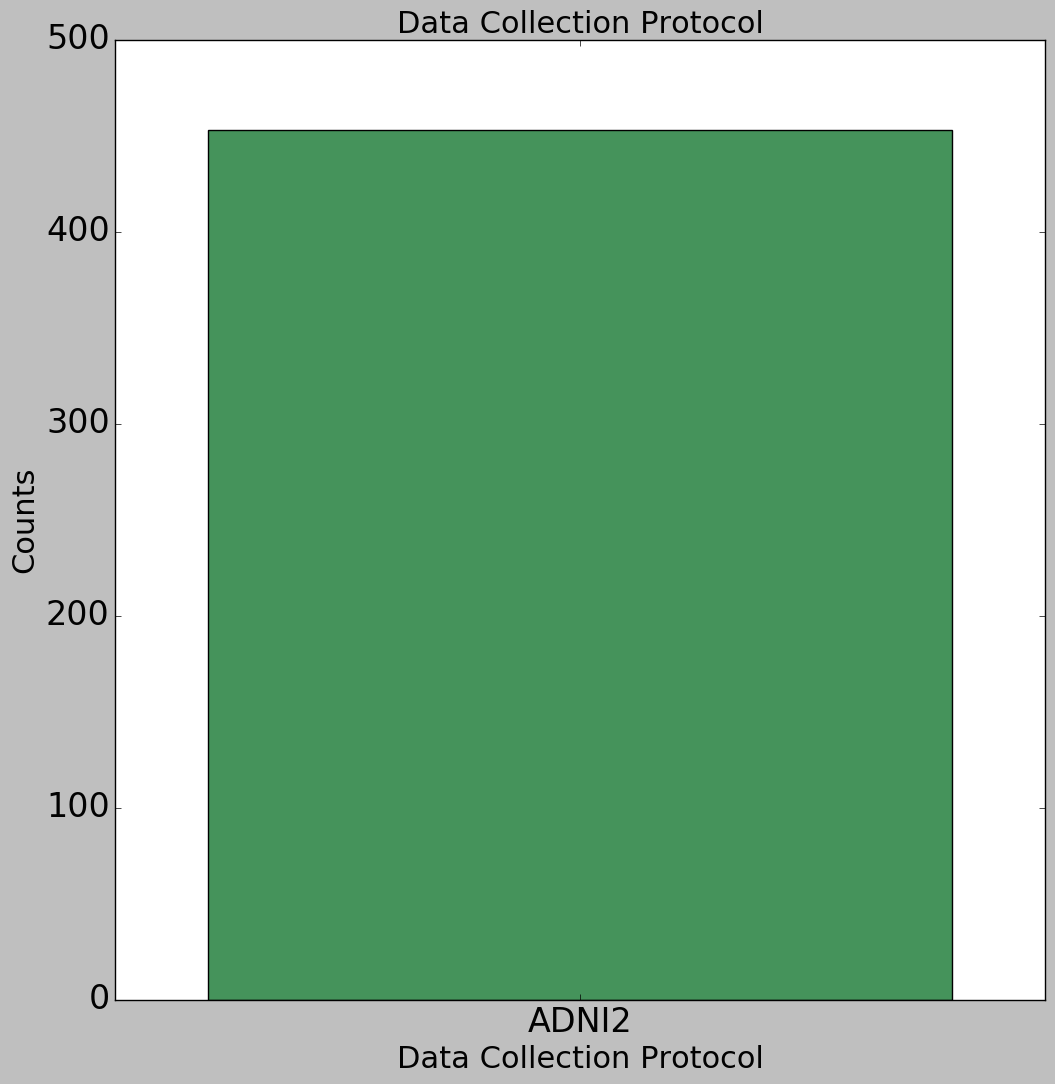

ADNI2    453
Name: COLPROT, dtype: int64


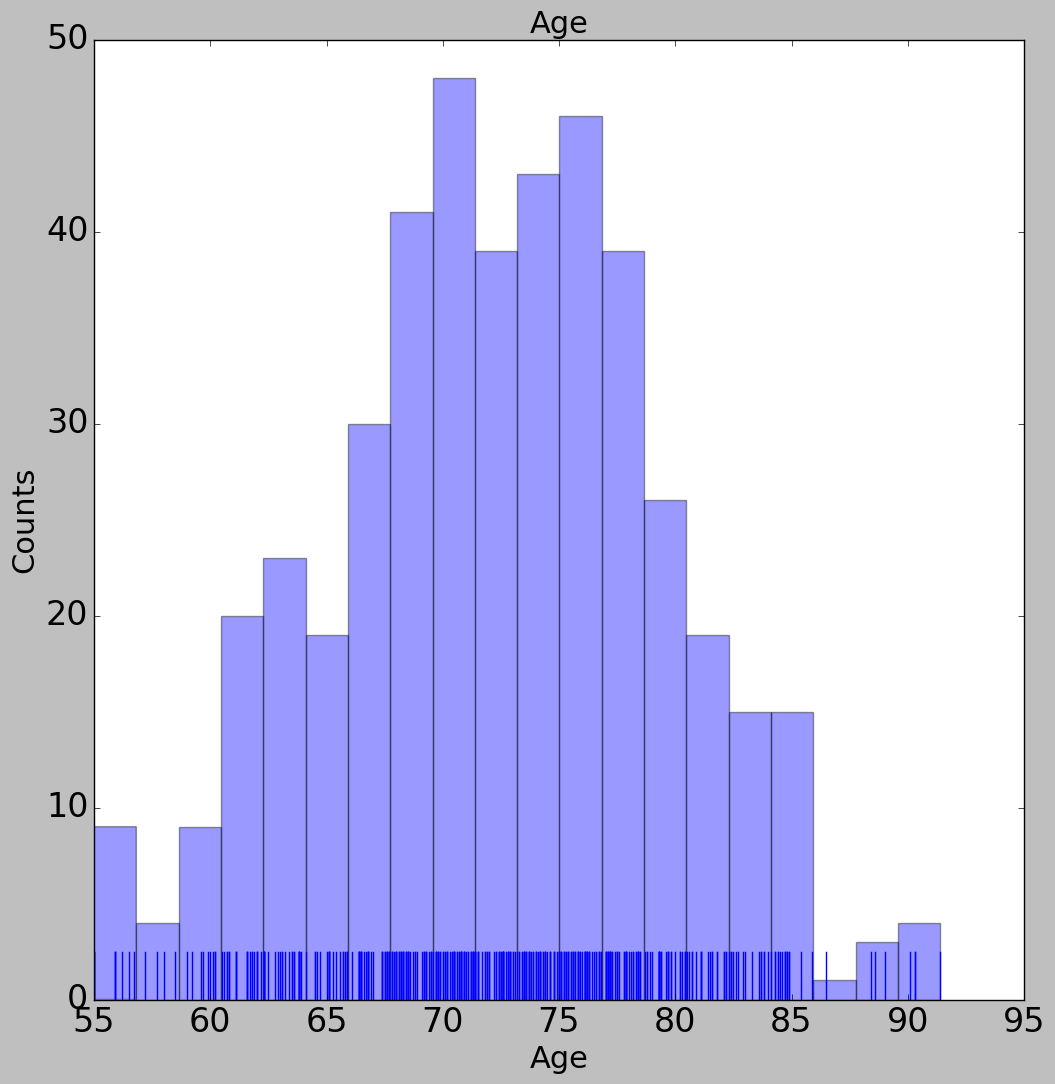

72.34282560706399
7.125063139484711


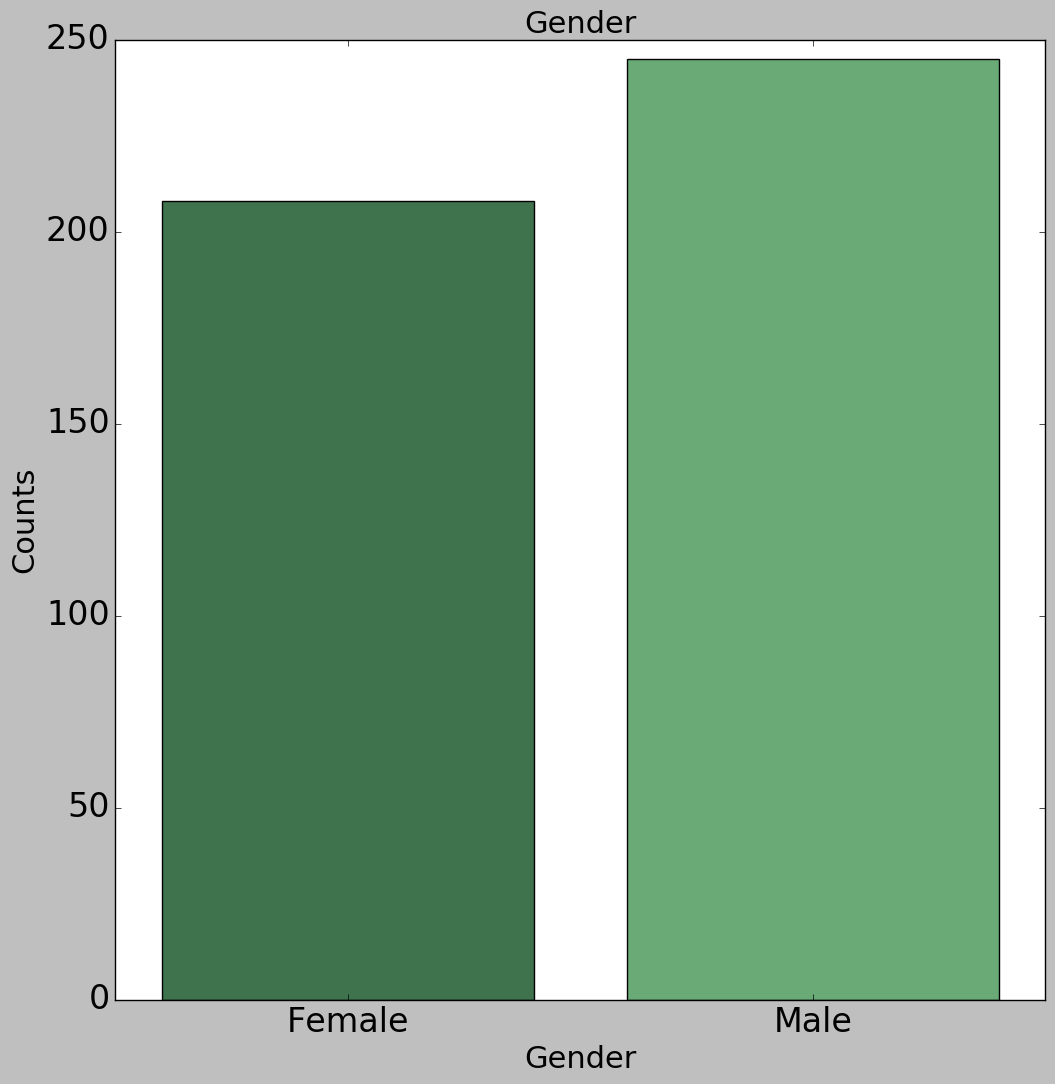

Male      245
Female    208
Name: PTGENDER, dtype: int64


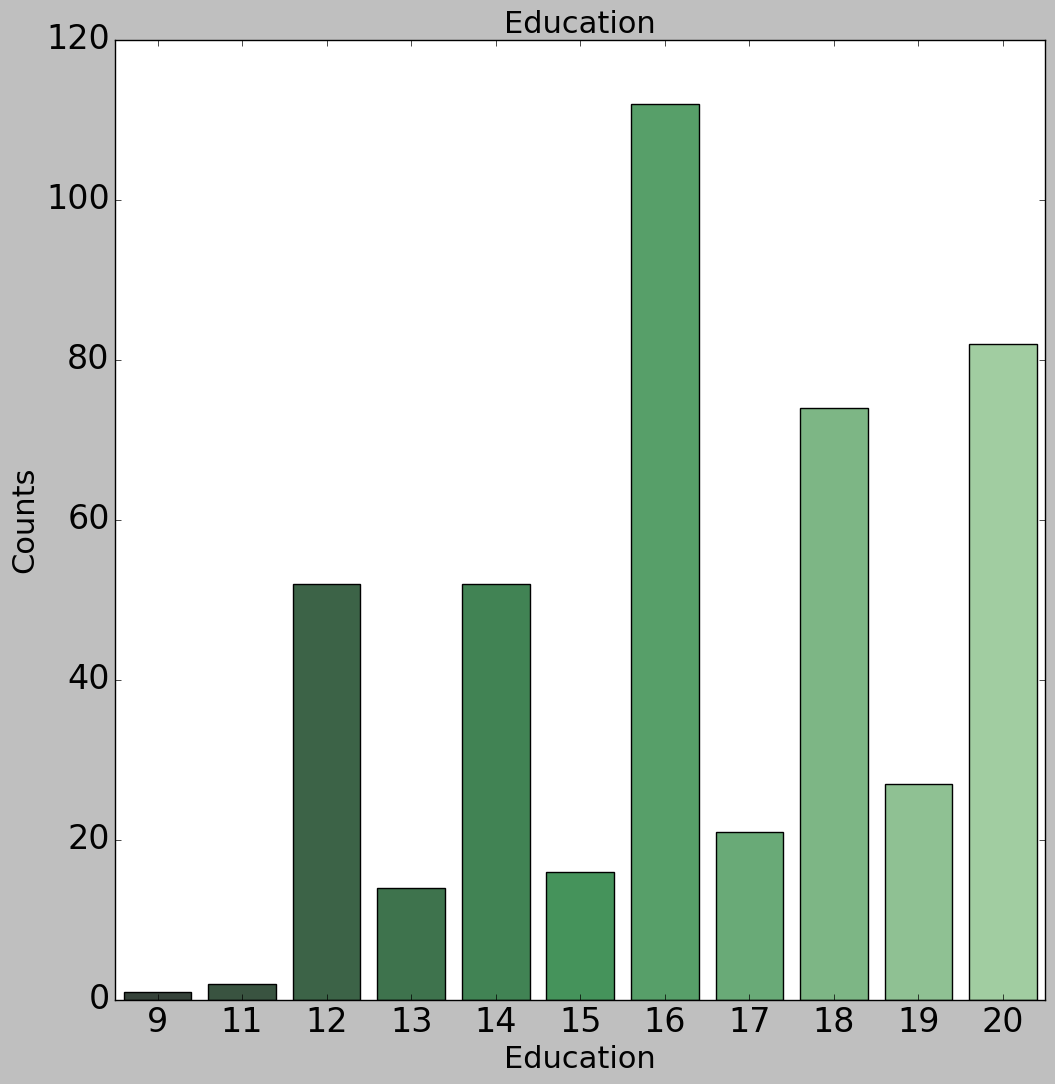

16    112
20     82
18     74
14     52
12     52
19     27
17     21
15     16
13     14
11      2
9       1
Name: PTEDUCAT, dtype: int64


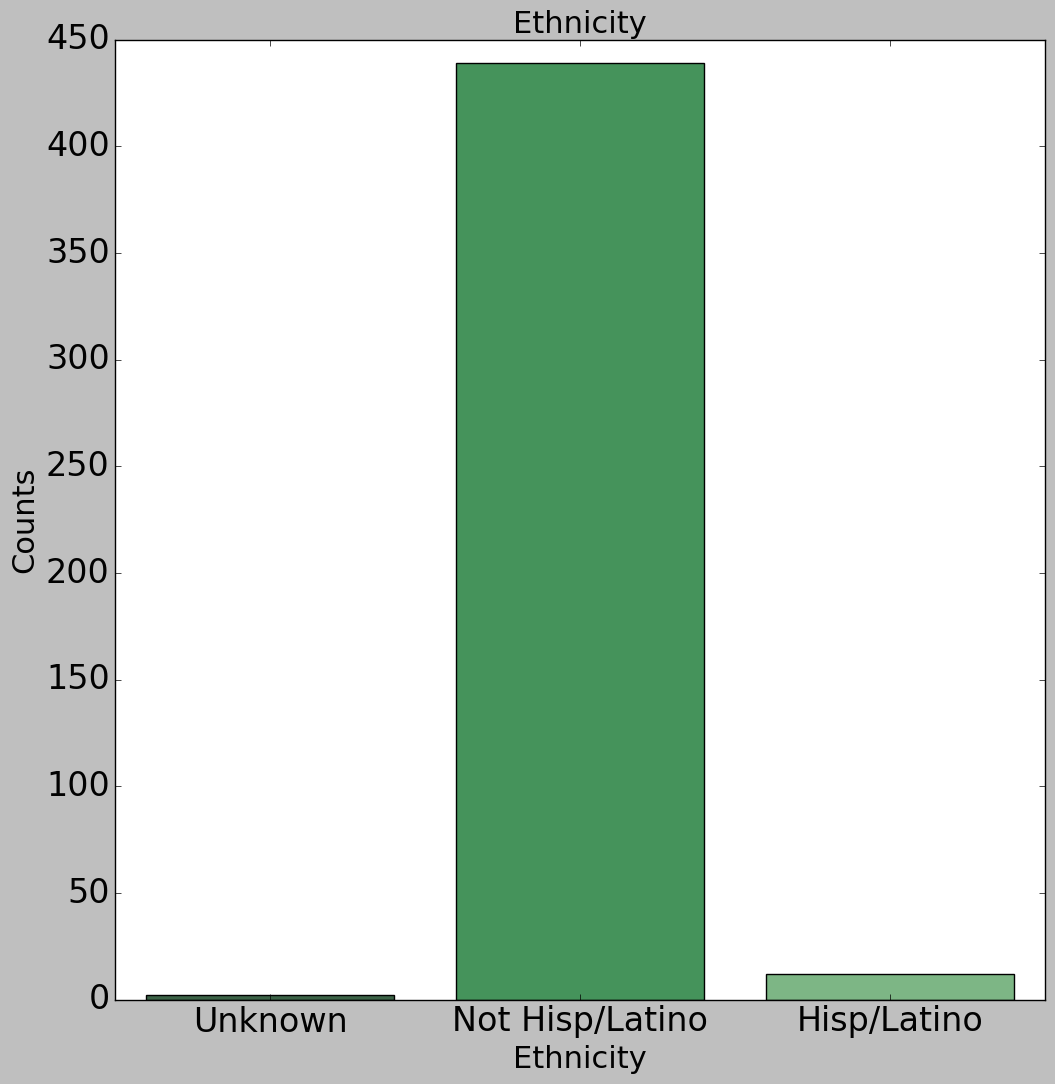

Not Hisp/Latino    439
Hisp/Latino         12
Unknown              2
Name: PTETHCAT, dtype: int64


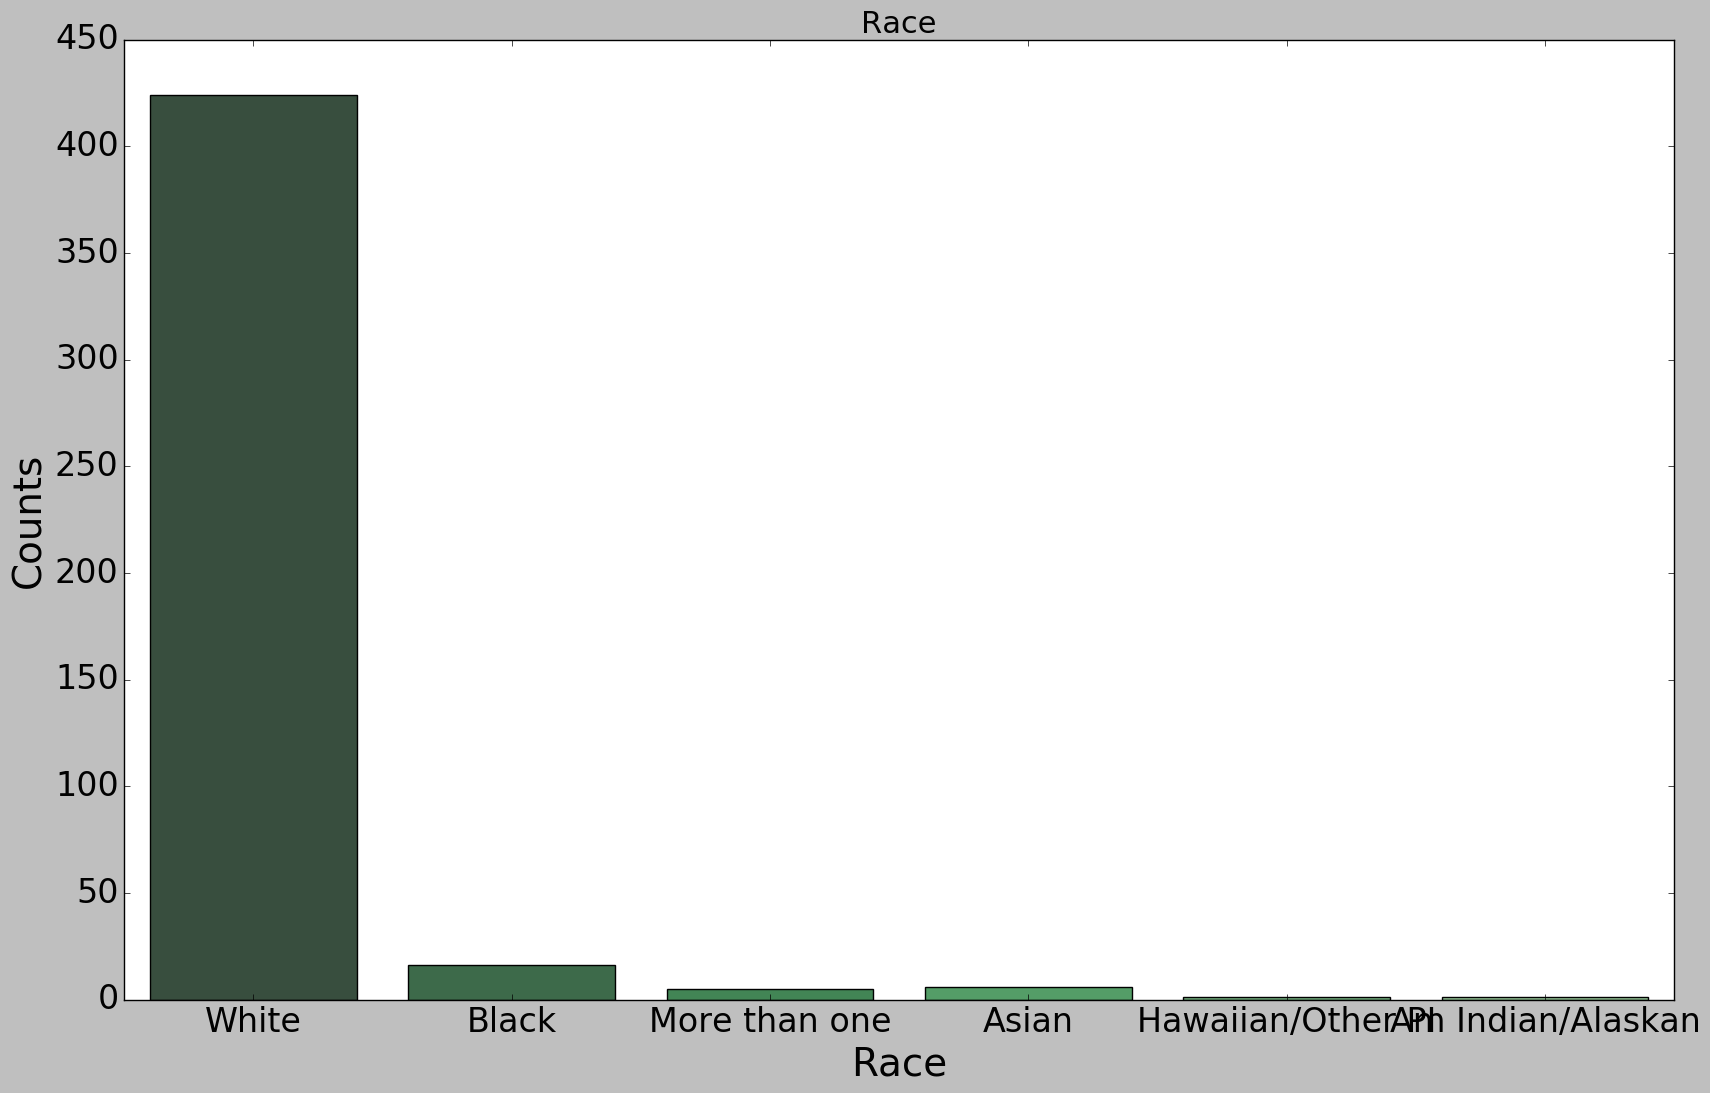

White                424
Black                 16
Asian                  6
More than one          5
Am Indian/Alaskan      1
Hawaiian/Other PI      1
Name: PTRACCAT, dtype: int64


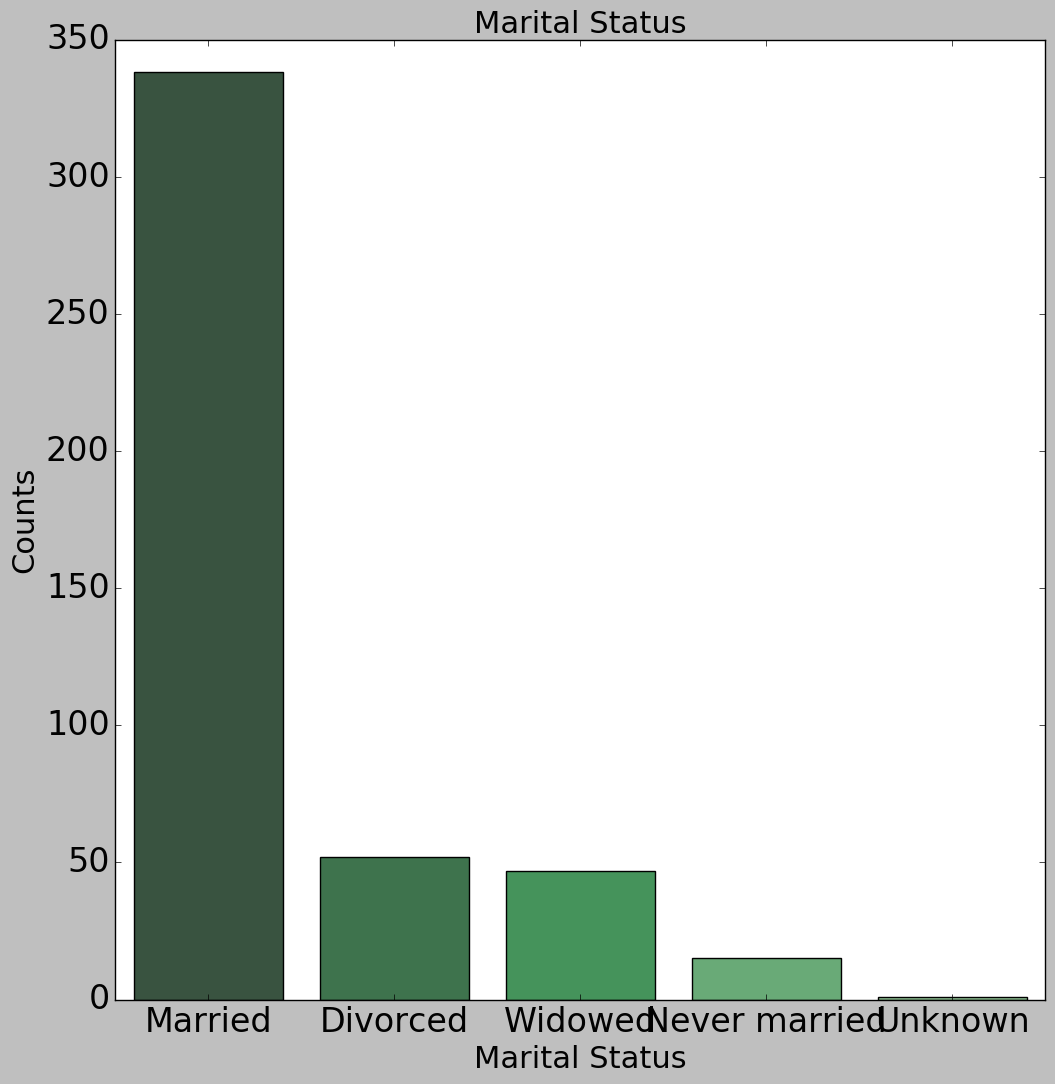

Married          338
Divorced          52
Widowed           47
Never married     15
Unknown            1
Name: PTMARRY, dtype: int64


In [86]:
#Only for all selected cohort, the visualizations of demographic information 
plots('adni_merge_chosen')

In [87]:
redued = redued_item_24
cols['apoe4'] = ['RID' , 'VISCODE' , 'APOE4'   ]
apoe4 = pd.read_csv("ADNI\\Raw_Data\\Demographic_Plots\\ADNIMERGE.csv",index_col='RID', usecols=cols['apoe4'])

apoe4['VISCODE2'] = apoe4['VISCODE']
apoe4['VISCODE'].value_counts()
del apoe4['VISCODE']
apoe4 = apoe4[apoe4['VISCODE2'].isin(['m24']) ]  

In [88]:
c =  colors_categories_item_24.T.squeeze()
#NMF and age distinction for controls 
controls_nmf = redued_item_24[['NMF_2_1','NMF_2_2']].loc[c=='red']
controls_nmf['APOE4'] = apoe4['APOE4'][controls_nmf.index] #Way 1 
#controls_nmf['predicted'] = 0 #Way 2
#controls_nmf['predicted'][result['AGE']>60] = 1

#NMF and age distinction for MCI
mci_nmf = redued_item_24[['NMF_2_1','NMF_2_2']].loc[c=='blue']
mci_nmf ['APOE4'] = apoe4['APOE4'][mci_nmf.index] #Way 1 
#mci_nmf['predicted'] = 0 #Way 2
#mci_nmf['predicted'][result['AGE']>60] = 1

#NMF and age distinction for Dimentia
dimentia_nmf = redued_item_24[['NMF_2_1','NMF_2_2']].loc[c=='green']
dimentia_nmf['APOE4'] = apoe4['APOE4'][dimentia_nmf.index] #Way 1 
#dimentia_nmf['predicted'] = 0 #Way 2
#dimentia_nmf['predicted'][result['AGE']>75] = 1

In [89]:
controls_nmf = controls_nmf.append(dimentia_nmf).append(mci_nmf) #To combine MCI and dimentia both

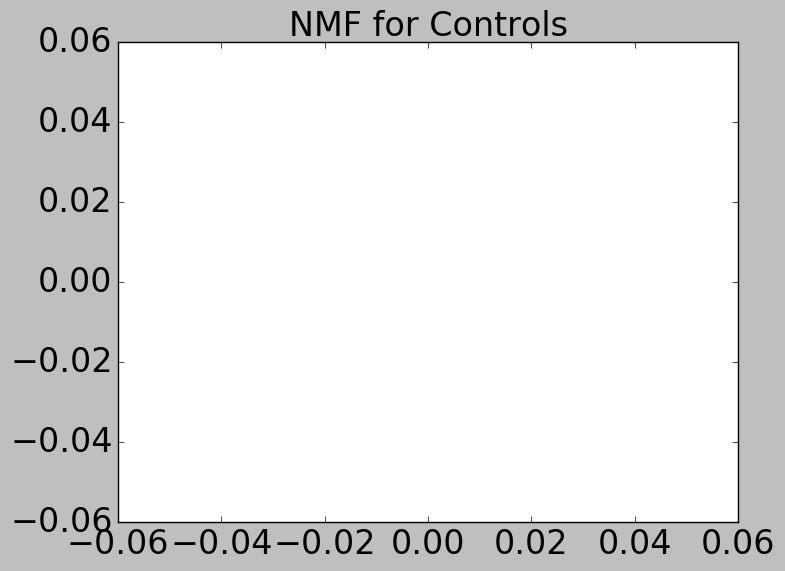

In [90]:
#NMF projection for only controls 
plt.scatter(controls_nmf.iloc[:,0], controls_nmf.iloc[:,1])
plt.title('NMF for Controls')
plt.show()

TypeError: only integer scalar arrays can be converted to a scalar index

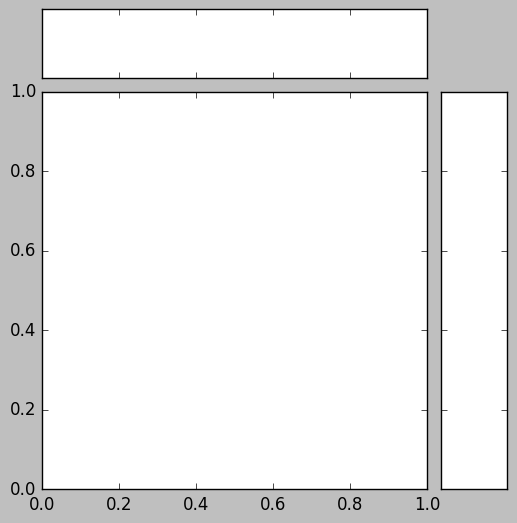

In [91]:
import seaborn as sns 
#Considering controls_nmf

x_red = list(controls_nmf[(controls_nmf['APOE4']==0).values]['NMF_2_1'].values) #Less than 75
y_red = list(controls_nmf[(controls_nmf['APOE4']==0).values]['NMF_2_2'].values)

x_blue = list(controls_nmf[(controls_nmf['APOE4']==1).values]['NMF_2_1'].values) #Greater than 75
y_blue = list(controls_nmf[(controls_nmf['APOE4']==1).values]['NMF_2_2'].values)

x_green = list(controls_nmf[(controls_nmf['APOE4']==2).values]['NMF_2_1'].values) #Greater than 75
y_green = list(controls_nmf[(controls_nmf['APOE4']==2).values]['NMF_2_2'].values)

'''
x_red = list(controls_nmf[(Predict_gmm==0).values]['NMF_2_1'].values) #Less than 75
y_red = list(controls_nmf[(Predict_gmm==0).values]['NMF_2_2'].values)

x_blue = list(controls_nmf[(Predict_gmm==1).values]['NMF_2_1'].values) #Greater than 75
y_blue = list(controls_nmf[(Predict_gmm==1).values]['NMF_2_2'].values)

x_green = list(controls_nmf[(Predict_gmm==2).values]['NMF_2_1'].values) #Greater than 75
y_green = list(controls_nmf[(Predict_gmm==2).values]['NMF_2_2'].values)
'''
import matplotlib as mpl
mpl.style.use('default')

plt.ion()
plt.show()
plt.pause(0.001)
a = 0.02
l = 10
zo = 0


p = sns.JointGrid(x = x_red, y = y_red)
p = p.plot_joint(plt.scatter, c="r", alpha = 0.2)

p.plot_marginals(sns.distplot, color='r', axlabel=[])
#p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Reds")
'''
p = sns.JointGrid(x = x_red, y = y_red)
p = p.plot_joint(plt.scatter, c="r", alpha = a)

p.plot_marginals(sns.distplot, color='r', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Reds")
'''
'''
p.x = x_red
p.y = y_red
p.plot_joint(plt.scatter, c="r", alpha = a)
p.plot_marginals(sns.distplot, color='r', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Reds")
'''

p.x = x_green
p.y = y_green
p.plot_joint(plt.scatter, c="g", alpha = 0.5)
p.plot_marginals(sns.distplot, color='g', axlabel=[])
#p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Greens")
p.set_axis_labels(xlabel='Cognition', ylabel='Memory')
p.ax_joint.set_xticklabels([])
p.ax_joint.set_yticklabels([])
# p.ax_marg_x.legend_.remove()

#p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
#p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')

plt.legend(['0 APOE4 present', '2 APOE4 present'], loc = 'upper right')
print('APOE4 distribution')


plt.show()